In [7]:
# !pip install yahoo_fin

!pip install yfinance

In [10]:
import yfinance as yf

def get_company_info(ticker):
    # Fetch data for the given ticker
    stock = yf.Ticker(ticker)
    
    # Extracting information
    info = stock.info
    company_name = info.get('longName')
    full_description = info.get('longBusinessSummary')
    industry = info.get('industry')

    # Limiting description to first three sentences
    sentences = full_description.split('. ') if full_description else []
    company_description = '. '.join(sentences[:3]) + ('.' if len(sentences) > 3 else '')

    return company_name, company_description, industry

# Example usage
ticker = "GME" # Replace with any ticker
company_name, company_description, industry = get_company_info(ticker)
print(f"Company Name: {company_name}")
print(f"Description: {company_description}")
print(f"Industry: {industry}")


Company Name: GameStop Corp.
Description: GameStop Corp., a specialty retailer, provides games and entertainment products through its stores and ecommerce platforms in the United States, Canada, Australia, and Europe. The company sells new and pre-owned gaming platforms; accessories, such as controllers, gaming headsets, and virtual reality products; new and pre-owned gaming software; and in-game digital currency, digital downloadable content, and full-game downloads. It also sells collectibles comprising apparel, toys, trading cards, gadgets, and other retail products for pop culture and technology enthusiasts, as well as engages in the digital asset wallet and NFT marketplace activities.
Industry: Specialty Retail


In [1]:
import pandas as pd
import numpy as np
from yahoo_fin import stock_info as finance

# Get SPY data
df_spy = finance.get_data('SPY', '20100101', '20231115')
df_spy_returns = df_spy['close'].pct_change().dropna()

# Mock function to mimic the behavior of finance.get_data
def get_data(ticker, sdate = '20180101', edate = '20231115', beta_adjust = True):
    # Assume this function returns a DataFrame similar to the one produced by finance.get_data
    # For demonstration, we're generating a DataFrame with a date range and mock data
    df = finance.get_data(ticker, sdate, edate)
    stock_returns = df.close.pct_change().dropna()
    
    if beta_adjust:
        global df_spy_returns
        
        # Align dates for stock and market returns
        aligned_returns = pd.concat([stock_returns, df_spy_returns], axis=1, join='inner')
        aligned_returns.columns = ['stock', 'market']
        
        # Calculate Beta
        cov_matrix = np.cov(aligned_returns['stock'], aligned_returns['market'])
        beta = cov_matrix[0, 1] / cov_matrix[1, 1]

        # Calculate Beta-Adjusted Returns
        adjusted_returns = aligned_returns['stock'] - beta * aligned_returns['market']
        
        # Reconstruct beta-adjusted close price series
        adjusted_close = [df['close'].iloc[0]]
        for ret in adjusted_returns[1:]:
            adjusted_close.append(adjusted_close[-1] * (1 + ret))

        adjusted_close = pd.Series(adjusted_close, index=adjusted_returns.index)
        adjusted_close.name = 'close'
        
        # Join and return 
        return df.drop('close', axis = 1).join(adjusted_close)
    
    return df
        
        
        


In [2]:
def identify_price_jumps(df, z_score_threshold=2, stability_threshold=1, lookback_period=90, lag_days_start=2, lag_days_end=5, 
                         include_negative_class=False, remove_duplicate_price_jump_dates=False):
    # Calculating daily price changes
    df['PriceChange'] = df['close'].pct_change()
    
    # Calculating rolling statistics
    rolling_mean = df['PriceChange'].rolling(window=lookback_period).mean()
    rolling_std = df['PriceChange'].rolling(window=lookback_period).std()
    
    # Identifying potential price jumps
    positive_results = []
    for i in range(lookback_period, len(df) - lag_days_end):
        current_z_score = (df.iloc[i]['PriceChange'] - rolling_mean[i]) / rolling_std[i]
        if abs(current_z_score) < stability_threshold:
            for lag_day in range(lag_days_start, lag_days_end+1):
                if i+lag_day < len(df):
                    future_price_change = df.iloc[i+lag_day]['PriceChange']
                    future_z_score = (future_price_change - rolling_mean[i+lag_day]) / rolling_std[i+lag_day]
                    if future_z_score > z_score_threshold:
                        positive_results.append({
                            'TriggerDate': df.index[i].date(),
                            'TriggerClose': df.iloc[i]['close'],
                            'PriceJumpDate': df.index[i+lag_day].date(),
                            'Close': df.iloc[i+lag_day]['close'],
                            'PriceJumpZScore': future_z_score,
                            'DaysAfterTrigger': lag_day,
                            'SignificantPriceJump': True,
                            'Ticker': df.iloc[0]['ticker']
                        })
                        break
                        
    # Convert positive results to DataFrame
    positive_results_df = pd.DataFrame(positive_results)

    # If remove_duplicate_price_jump_dates flag is set, remove duplicates
    if remove_duplicate_price_jump_dates:
        # Group by PriceJumpDate and randomly keep one record per group
        positive_results_df = positive_results_df.groupby('PriceJumpDate').apply(lambda x: x.sample(1)).reset_index(drop=True)


    # Sample negative class instances if required
    negative_results = []
    if include_negative_class:
        num_positive = len(positive_results_df)
        sampled_rows = df.iloc[lookback_period:len(df) - lag_days_end].sample(n=num_positive)
        for _, row in sampled_rows.iterrows():
            negative_results.append({
                'TriggerDate': row.name.date(),
                'TriggerClose': row['close'],
                'PriceJumpDate': None,  # No price jump date for negative class
                'Close': None,
                'PriceJumpZScore': None,
                'DaysAfterTrigger': None,
                'SignificantPriceJump': False,
                'Ticker': df.iloc[0]['ticker']
            })

    # Combine positive and negative results
    combined_results = pd.DataFrame(positive_results_df.to_dict('records') + negative_results).fillna(0)


    return combined_results

# Example usage
df = get_data('GME', '2019-01-01', '2023-11-15')
price_jumps_df = identify_price_jumps(df, z_score_threshold=2.5, stability_threshold=1, include_negative_class=True, remove_duplicate_price_jump_dates = True)
price_jumps_df.sample(5)


/tmp/ipykernel_10554/323460992.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_z_score = (df.iloc[i]['PriceChange'] - rolling_mean[i]) / rolling_std[i]
/tmp/ipykernel_10554/323460992.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  future_z_score = (future_price_change - rolling_mean[i+lag_day]) / rolling_std[i+lag_day]


TriggerDate  TriggerClose PriceJumpDate      Close  PriceJumpZScore  \
36  2020-07-08      0.802638             0   0.000000         0.000000   
23  2023-02-17     12.443774             0   0.000000         0.000000   
17  2022-03-24     17.084442    2022-03-28  22.480612         3.442880   
3   2020-06-02      0.806139    2020-06-08   0.914322         2.658270   
0   2020-04-06      0.698627    2020-04-13   1.023979         3.941324   

    DaysAfterTrigger  SignificantPriceJump Ticker  
36               0.0                 False    GME  
23               0.0                 False    GME  
17               2.0                  True    GME  
3                4.0                  True    GME  
0                4.0                  True    GME

In [3]:
# Short sale volume

class ShortSaleVolume:
    
    bucket = 'mads-capstone-2023' 
    data_key = 'FINRA_Short_Sale_Data2.csv' 
    data_location = 's3://{}/{}'.format(bucket, data_key) 
    
    def __init__(self):
        self.has_downloaded = False 
    
    # Function to download data from S3
    def get_data(self):
        if not self.has_downloaded:
            self.df = pd.read_csv(self.data_location)
            self.df.drop(['Unnamed: 0'], axis = 1, inplace = True)
            self.df['shortvolume'] = self.df['totalvolume'] - self.df['shortvolume']
            self.df['longvolume'] = self.df['totalvolume'] - self.df['shortvolume']
            self.df['short_ratio'] = 1 - self.df['short_ratio']
            self.has_downloaded = True
        else:
            pass
        
    def short_ratio(self, ticker):
        # Check if data has been downloaded locally
        self.get_data()
        
        # Return data for ticker 
        df_ = self.df[self.df['ticker'] == ticker].copy()
        df_['date'] = pd.to_datetime(df_['date'])
        df_.set_index('date', inplace=True)
        return df_

    
    def calculate_short_ratio_means(self, ticker='GME', include_diff=False, include_roc=False):
        df = self.short_ratio(ticker)
        periods = [1, 5, 10, 21, 42]
        for period in periods:
            df[f'short_ratio_mean_{period}'] = df['short_ratio'].rolling(window=period).mean()

        if include_diff:
            for i in range(len(periods)):
                for j in range(i + 1, len(periods)):
                    df[f'short_ratio_mean_{periods[i]}_div_mean_{periods[j]}'] = df[f'short_ratio_mean_{periods[i]}'] / df[f'short_ratio_mean_{periods[j]}']
                    df[f'short_ratio_mean_{periods[j]}_div_mean_{periods[i]}'] = df[f'short_ratio_mean_{periods[j]}'] / df[f'short_ratio_mean_{periods[i]}']

        if include_roc:
            # print('working')
            for col in df.columns:
                if 'short_ratio_mean_' in col:
                    df[f'{col}_roc'] = df[col].pct_change() * 100

        result_df = df[[col for col in df.columns if 'short_ratio_mean_' in col or ('roc' in col and 'short_ratio_mean_' in col)]]
        return result_df

    def calculate_short_exempt_means(self, ticker='GME', include_diff=False, include_roc=False):
        df = self.short_ratio(ticker)
        periods = [1, 5, 10, 21, 42]

        df['short_exempt_percent'] = (df['shortexemptvolume'] / df['totalvolume'])

        for period in periods:
            df[f'short_exempt_percent_mean_{period}'] = df['short_exempt_percent'].rolling(window=period).mean()

        if include_diff:
            for i in range(len(periods)):
                for j in range(i + 1, len(periods)):
                    df[f'short_exempt_percent_mean_{periods[i]}_div_mean_{periods[j]}'] = df[f'short_exempt_percent_mean_{periods[i]}'] / df[f'short_exempt_percent_mean_{periods[j]}']
                    df[f'short_exempt_percent_mean_{periods[j]}_div_mean_{periods[i]}'] = df[f'short_exempt_percent_mean_{periods[j]}'] / df[f'short_exempt_percent_mean_{periods[i]}']

        if include_roc:
            for col in df.columns:
                if 'short_exempt_percent_mean_' in col:
                    df[f'{col}_roc'] = df[col].pct_change() * 100

        result_df = df[[col for col in df.columns if 'short_exempt_percent_mean_' in col or ('roc' in col and 'short_exempt_percent_mean_' in col)]]
        return result_df
    
    def calculate_investment_values(self, ticker='GME', days=20, investment_amount=1_000_000, include_diff=False, include_roc=False):
        df = self.short_ratio(ticker)

        # Retrieve closing prices from finance API
        closing_prices = finance.get_data(ticker, df.index.min(), df.index.max())['close']
        
        # Merge closing prices with short ratio data
        df = df.merge(closing_prices, left_index=True, right_index=True, how='left')

        # Ensure short_exempt_percent column is calculated before its usage
        df['short_exempt_percent'] = df['shortexemptvolume'] / df['totalvolume']

        # Calculate net short volume and net short shares
        df['net_short_volume'] = df['shortvolume'] - df['longvolume']
        df['net_short_shares'] = investment_amount / df['close']

        # Calculate cumulative net short volume and short exempt volume
        df['cumulative_net_short'] = (df['net_short_volume'] * df['net_short_shares']).rolling(window=days).sum()
        df['cumulative_short_exempt'] = (df['short_exempt_percent'] * df['net_short_shares']).rolling(window=days).sum()

        # Calculate the cumulative values as a percent of total volume
        df['cumulative_net_short_percent'] = df['cumulative_net_short'] / (df['totalvolume'] * df['net_short_shares']).rolling(window=days).sum() * 100
        df['cumulative_short_exempt_percent'] = df['cumulative_short_exempt'] / (df['totalvolume'] * df['net_short_shares']).rolling(window=days).sum() * 100

        if include_diff:
            periods = [1, 5, 10, 21, 42]
            for i in range(len(periods)):
                for j in range(i + 1, len(periods)):
                    df[f'cumulative_net_short_percent_{periods[i]}_div_{periods[j]}'] = df['cumulative_net_short_percent'].rolling(window=periods[i]).mean() / df['cumulative_net_short_percent'].rolling(window=periods[j]).mean()
                    df[f'cumulative_short_exempt_percent_{periods[i]}_div_{periods[j]}'] = df['cumulative_short_exempt_percent'].rolling(window=periods[i]).mean() / df['cumulative_short_exempt_percent'].rolling(window=periods[j]).mean()

        if include_roc:
            for col in ['cumulative_net_short_percent', 'cumulative_short_exempt_percent']:
                df[f'{col}_roc'] = df[col].pct_change() * 100

        selected_cols = ['cumulative_net_short_percent', 'cumulative_short_exempt_percent']
        if include_diff or include_roc:
            selected_cols += [col for col in df.columns if 'cumulative_net_short_percent' in col or 'cumulative_short_exempt_percent' in col]

        return df[selected_cols]

# Example usage 
analysis = ShortSaleVolume()
# df_gme_short_ratio = analysis.calculate_short_ratio_means('GME', include_roc = True)
# df_gme_short_sale_exempt = analysis.calculate_short_exempt_means('GME', include_roc = False)
# df_gme_investment_values = analysis.calculate_investment_values('GME', include_roc = False)


In [4]:
analysis.df

AttributeError: 'ShortSaleVolume' object has no attribute 'df'

In [7]:
df_gme_short_ratio.head()

In [5]:
import psycopg2
import pandas as pd

class GreekAnalysis:
    def __init__(self):
        self.db_params = {
            'user': 'USER_STRING',   #Removed for Git
            'password': 'PW_STRING', #Removed for Git
            'host': 'mads-capstone.cmohac77hep9.eu-north-1.rds.amazonaws.com',
            'port': 5432,
            'database': 'mads'
        }

    def get_greeks_data(self, ticker, greek_type):
        with psycopg2.connect(**self.db_params) as db_connection:
            db_connection.autocommit = True
            with db_connection.cursor() as cursor:
                select_query = "SELECT * FROM greeks3 WHERE ticker=%s AND GREEK=%s"
                cursor.execute(select_query, (ticker, greek_type))
                rows = cursor.fetchall()
                df = pd.DataFrame(rows, columns=["ID", "DATE", "INCREMENT", "VALUE", "TICKER", "GREEK", "OPTION_TYPE"])
        return df

    def analyze_data(self, df, greek_type):
        merged_df = self._prepare_merged_dataframe(df, greek_type)
        merged_df[f'{greek_type}_Skew'] = merged_df[f'{greek_type}_Call'] / merged_df[f'{greek_type}_Put']
        merged_df[f'{greek_type}_Time_Spread'] = merged_df[f'{greek_type}_30'] / merged_df[f'{greek_type}_90']
        return merged_df[[f'{greek_type}_30', f'{greek_type}_Skew', f'{greek_type}_Time_Spread']]

    def _prepare_merged_dataframe(self, df, greek_type):
        inc30_all = df[(df['INCREMENT'] == 30) & (df['OPTION_TYPE'] == 'all')]
        inc30_call = df[(df['INCREMENT'] == 30) & (df['OPTION_TYPE'] == 'call')]
        inc30_put = df[(df['INCREMENT'] == 30) & (df['OPTION_TYPE'] == 'put')]
        inc90_all = df[(df['INCREMENT'] == 90) & (df['OPTION_TYPE'] == 'all')]

        merged_df = pd.DataFrame(index=inc30_all['DATE'].unique())
        merged_df[f'{greek_type}_30'] = inc30_all.groupby('DATE')['VALUE'].mean()
        merged_df[f'{greek_type}_Call'] = inc30_call.groupby('DATE')['VALUE'].mean()
        merged_df[f'{greek_type}_Put'] = inc30_put.groupby('DATE')['VALUE'].mean()
        merged_df[f'{greek_type}_90'] = inc90_all.groupby('DATE')['VALUE'].mean()

        return merged_df

    def _add_rolling_features(self, df, greek_type):
        periods = [1, 5, 10, 21, 42]
        for col in [f'{greek_type}_30', f'{greek_type}_Skew', f'{greek_type}_Time_Spread']:
            for period in periods:
                df[f'{col}_rolling_{period}'] = df[col].rolling(window=period).mean()
        return df

    def _add_z_score_features(self, df, greek_type):
        rolling_window = 90
        for col in [f'{greek_type}_30', f'{greek_type}_Skew', f'{greek_type}_Time_Spread']:
            df[f'{col}_z_score'] = (df[col] - df[col].rolling(window=rolling_window).mean()) / df[col].rolling(window=rolling_window).std()
        return df

    def get_analysis_for_ticker(self, ticker, greek_type='iv', include_rolling=False, include_z_score=False):
        df = self.get_greeks_data(ticker, greek_type)
        analysis_df = self.analyze_data(df, greek_type)
        if include_rolling:
            analysis_df = self._add_rolling_features(analysis_df, greek_type)
        if include_z_score:
            analysis_df = self._add_z_score_features(analysis_df, greek_type)
        return analysis_df.sort_index()

# Example usage:
greek_analysis = GreekAnalysis()
# df_gme_iv = greek_analysis.get_analysis_for_ticker('GME', 'iv', include_rolling = True, include_z_score = True)
# df_gme_gamma = greek_analysis.get_analysis_for_ticker('GME', 'gamma', include_rolling = True, include_z_score = True)


In [6]:
class VolatilityAnalysis(GreekAnalysis):
    def __init__(self):
        super().__init__()
        self.sdate = '20160101'
        self.edate = '20231110'
        
    # Function to calculate HV for a given OHLCV DataFrame
    def calculate_hv(self, ohlcv_df, look_forward=30):
        # Calculate daily returns
        daily_returns = ohlcv_df['close'].pct_change()

        # Compute rolling standard deviation of daily returns
        rolling_std = daily_returns.rolling(window = look_forward).std()

        # HV is the annualized standard deviation
        hv = rolling_std * np.sqrt(252)

        return hv

    def compare_iv_hv(self, ticker, shift_hv = False):
        
        # Get ticker data
        ohlcv_df = finance.get_data(ticker, self.sdate, self.edate)
        
        # Pull IV30 data
        iv30_df = self.get_greeks_data(ticker, 'iv')
        iv30_df = iv30_df[(iv30_df['GREEK'] == 'iv') & (iv30_df['OPTION_TYPE'] == 'all') & (iv30_df['INCREMENT'] == 30)].copy()
        iv30_df['date'] = pd.to_datetime(iv30_df['DATE'])
        iv30_df.rename({'VALUE':'iv30'}, inplace = True, axis = 1)

        # Calculate HV
        hv_df = self.calculate_hv(ohlcv_df)

        # Align and compare IV30 and HV
        # Ensure iv30_df and hv_df have the same date index
        comparison_df = pd.DataFrame()
        comparison_df['IV30'] = iv30_df.set_index('date').sort_index()['iv30']
        
        # Are we shifting HV? 
        if shift_hv:
            comparison_df['HV'] = hv_df.shift(-30)  # Adjust as necessary
        else:
            comparison_df['HV'] = hv_df
        
        # Add to dataframe and return 
        comparison_df['IV_HV_Difference'] = comparison_df['IV30'] - comparison_df['HV']

        return comparison_df['IV_HV_Difference']
    
    def calculate_vwap(self, ohlcv_df, rolling_window = 90):  
        ohlcv_df['Typical_Price'] = (ohlcv_df['high'] + ohlcv_df['low'] + ohlcv_df['close']) / 3
        ohlcv_df['TP_Volume'] = ohlcv_df['Typical_Price'] * ohlcv_df['volume']

        # Calculate rolling TP_Volume and rolling volume
        ohlcv_df['Rolling_TP_Volume'] = ohlcv_df['TP_Volume'].rolling(window=rolling_window).sum()
        ohlcv_df['Rolling_Volume'] = ohlcv_df['volume'].rolling(window=rolling_window).sum()

        # Compute rolling VWAP
        ohlcv_df['VWAP'] = ohlcv_df['Rolling_TP_Volume'] / ohlcv_df['Rolling_Volume']

        # Calculate the percentage difference between close and VWAP
        ohlcv_df['vwap_close_pct'] = ohlcv_df['close'] / ohlcv_df['VWAP']

        return ohlcv_df

    def compare_price_to_vwap(self, ticker = None, ohlcv_df = None):
        
        # Optionally, grab data
        if not isinstance(ohlcv_df, pd.DataFrame):
            ohlcv_df = finance.get_data(ticker, self.sdate, self.edate)
            
        ohlcv_df = self.calculate_vwap(ohlcv_df)
        return ohlcv_df['vwap_close_pct']
    
# Example usage
price_iv_analysis = VolatilityAnalysis()
df_iv_hv = price_iv_analysis.compare_iv_hv('GME')
df_vwap = price_iv_analysis.compare_price_to_vwap('GME')

<AxesSubplot:xlabel='date'>

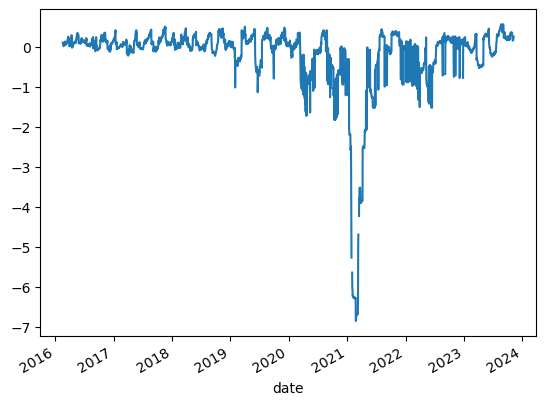

In [8]:
df_iv_hv.plot()

In [10]:
# Function for merging data together

# Merge additional data into price_jumps_df
def merge_additional_data(price_jumps_df, additional_dfs):
    for additional_df in additional_dfs:
        # Convert TriggerDate to datetime for merging
        price_jumps_df['TriggerDate'] = pd.to_datetime(price_jumps_df['TriggerDate'])
        
        # Merge each additional dataframe
        price_jumps_df = price_jumps_df.merge(additional_df, left_on='TriggerDate', right_index=True, how='left')
    
    return price_jumps_df

In [11]:
def return_etf_holdings(ticker = 'SPTM'):

    headers = requests.utils.default_headers()
    headers['User-Agent'] = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36'
    res = requests.get("https://www.zacks.com/funds/etf/%s/holding"%ticker,  headers=headers)
    soup = BeautifulSoup(res.text, 'html.parser')

    js = None
    for script in soup.find_all("script"):
        if "etf_holdings.formatted_data = " in str(script):
    #    if "etf_holdings" in str(script):
            js = str(script)
    holdings = []
    # for line in js.text.split("["):
    for line in js.split("["):
        if "rel=" in line:
            line_soup = BeautifulSoup(line, 'html.parser')
            #holding = line_soup.find("a")["alt"].strip('\\"')
            holding = line_soup.find('a')['rel'][0].strip('\\"')
            holdings.append(holding)

    return holdings

### Sample 50 tickers from the S&P 500 to build training data

In [12]:
import random
import requests
from bs4 import BeautifulSoup

tickers = return_etf_holdings('SPTM')
tickers = random.sample(tickers, k = 100)
tickers.append('GME')
tickers = list(set(tickers))
tickers[:5]

['MDLZ', 'ACM', 'NGVT', 'HSIC', 'ENPH']

In [13]:
from tqdm import tqdm
sdate = '20180816'
edate = '20231115'
beta_adjust = False

# What are our day forward / day back ranges
lag_days_start, lag_days_end = 2, 8
static_lag_period = 2


df_repo = []
for ticker in tqdm(tickers):
    
    try:
        # Get data
        df_data = get_data(ticker, sdate, edate, beta_adjust = beta_adjust)

        # Calc positive and negative classes
        price_jumps_df = identify_price_jumps(df_data, 
                                              z_score_threshold=2.5, 
                                              stability_threshold=1, 
                                              include_negative_class=True, 
                                              remove_duplicate_price_jump_dates = False,
                                              lag_days_start=lag_days_start, 
                                              lag_days_end=lag_days_end)

        # Get other data
        df_short_ratio = analysis.calculate_short_ratio_means(ticker, include_diff=True, include_roc=True)
        df_short_sale_exempt = analysis.calculate_short_exempt_means(ticker, include_diff=True, include_roc=True)
        df_investment_values = analysis.calculate_investment_values(ticker, include_diff=True, include_roc=True)

        df_iv = greek_analysis.get_analysis_for_ticker(ticker, 'iv', include_rolling = True, include_z_score = True)
        df_gamma = greek_analysis.get_analysis_for_ticker(ticker, 'gamma', include_rolling = True, include_z_score = True)

        df_iv_hv = price_iv_analysis.compare_iv_hv(ticker)
        df_vwap = price_iv_analysis.compare_price_to_vwap(ticker)

        # Merge datasets together
        additional_dfs = [df_short_ratio, df_short_sale_exempt, df_investment_values, df_iv, df_gamma, df_iv_hv, df_vwap]
        for df_ in additional_dfs:
            df_.index = pd.to_datetime(df_.index)
        merged_df = merge_additional_data(price_jumps_df, additional_dfs)

        # Save to repo and continue
        df_repo.append(merged_df)
        
    except Exception as e:
        print(ticker, type(e), e)

 33%|███▎      | 33/101 [03:32<06:09,  5.44s/it]

ETD <class 'ValueError'> NaTType does not support timestamp


 37%|███▋      | 37/101 [03:56<05:33,  5.22s/it]

GEHC <class 'ValueError'> NaTType does not support timestamp


 41%|████      | 41/101 [04:16<04:48,  4.80s/it]

PECO <class 'ValueError'> NaTType does not support timestamp


 45%|████▍     | 45/101 [04:39<04:43,  5.05s/it]

GXO <class 'ValueError'> NaTType does not support timestamp


 59%|█████▉    | 60/101 [06:14<03:46,  5.51s/it]

FTDR <class 'ValueError'> NaTType does not support timestamp


 61%|██████▏   | 62/101 [06:23<03:09,  4.85s/it]

ENOV <class 'ValueError'> NaTType does not support timestamp


 71%|███████▏  | 72/101 [07:29<02:46,  5.73s/it]

CXT <class 'ValueError'> NaTType does not support timestamp


 77%|███████▋  | 78/101 [08:05<02:03,  5.39s/it]

ESAB <class 'ValueError'> NaTType does not support timestamp


 84%|████████▍ | 85/101 [08:50<01:30,  5.65s/it]

CHRD <class 'ValueError'> NaTType does not support timestamp


100%|██████████| 101/101 [10:35<00:00,  6.29s/it]


In [14]:
# Merge into singular dataset

merged_df = pd.concat(df_repo).reset_index(drop = True)
print(merged_df.shape)
merged_df.head()

(10040, 178)


TriggerDate  TriggerClose PriceJumpDate      Close  PriceJumpZScore  \
0  2019-01-18     43.360001    2019-01-31  46.259998         4.253387   
1  2019-01-22     43.130001    2019-01-31  46.259998         4.253387   
2  2019-01-23     43.509998    2019-01-31  46.259998         4.253387   
3  2019-01-24     43.029999    2019-01-31  46.259998         4.253387   
4  2019-01-25     42.720001    2019-01-31  46.259998         4.253387   

   DaysAfterTrigger  SignificantPriceJump Ticker  short_ratio_mean_1  \
0               8.0                  True   MDLZ            0.526680   
1               7.0                  True   MDLZ            0.425321   
2               6.0                  True   MDLZ            0.499175   
3               5.0                  True   MDLZ            0.575442   
4               4.0                  True   MDLZ            0.568316   

   short_ratio_mean_5  ...  gamma_Time_Spread_rolling_1  \
0            0.529569  ...                     0.691095   
1            0.497968  ...                     0.685816   
2            0.516611  ...                     0.666199   
3            0.521693  ...                     0.645586   
4            0.518987  ...                     0.285642   

   gamma_Time_Spread_rolling_5  gamma_Time_Spread_rolling_10  \
0                     0.865399                      0.985092   
1                     0.824491                      0.952129   
2                     0.778723                      0.862517   
3                     0.720318                      0.798008   
4                     0.594868                      0.743786   

   gamma_Time_Spread_rolling_21  gamma_Time_Spread_rolling_42  \
0                      0.988995                      0.957386   
1                      0.973552                      0.949899   
2                      0.957249                      0.942084   
3                      0.940364                      0.923708   
4                      0.906959                      0.880778   

   gamma_30_z_score  gamma_Skew_z_score  gamma_Time_Spread_z_score  \
0          0.562974           -0.152538                  -0.223775   
1          0.532646           -0.067221                  -0.241522   
2          0.586984           -0.131559                  -0.272631   
3          0.551440           -0.023679                  -0.304779   
4          0.468940            0.074901                  -0.926180   

   IV_HV_Difference  vwap_close_pct  
0          0.044225        1.019712  
1          0.066157        1.014156  
2          0.068238        1.023005  
3          0.073508        1.011779  
4          0.068757        1.004626  

[5 rows x 178 columns]

In [15]:
features = merged_df.columns[8:]
merged_df = merged_df.set_index('TriggerDate').sort_index()
# Handle missing values
merged_df.fillna(0, inplace=True)
merged_df.replace([np.inf, -np.inf], 0, inplace=True)

In [69]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier

# Assuming 'merged_df' is a DataFrame with a DateTime index
# merged_df = merged_df.sort_index()  # Make sure the DataFrame is sorted by time

# Split the data into features and target
# features = merged_df.columns.difference(['SignificantPriceJump'])
X = merged_df[features]
y = merged_df['SignificantPriceJump']

# Data Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)


for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Print the start and end index for each set
    print(f"Train index range: {train_index[0]} - {train_index[-1]}")
    print(f"Test index range: {test_index[0]} - {test_index[-1]}")

    # Train the model
    model = LGBMClassifier(random_state=42, verbose = -1)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("\n")


Train index range: 0 - 1687
Test index range: 1688 - 3374
              precision    recall  f1-score   support

       False       0.51      0.74      0.61       784
        True       0.63      0.40      0.49       903

    accuracy                           0.55      1687
   macro avg       0.57      0.57      0.55      1687
weighted avg       0.58      0.55      0.54      1687

[[577 207]
 [545 358]]


Train index range: 0 - 3374
Test index range: 3375 - 5061
              precision    recall  f1-score   support

       False       0.59      0.82      0.69       910
        True       0.61      0.32      0.42       777

    accuracy                           0.59      1687
   macro avg       0.60      0.57      0.55      1687
weighted avg       0.60      0.59      0.56      1687

[[750 160]
 [526 251]]


Train index range: 0 - 5061
Test index range: 5062 - 6748
              precision    recall  f1-score   support

       False       0.53      0.66      0.59       763
        True 

In [22]:
import pandas as pd
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np

def rolling_window_pipeline(data, start_date, end_date, train_window, test_window, features, target):
    # Initialize a container for storing evaluation metrics
    evaluation_results = []

    current_start = start_date
    while current_start + train_window + test_window <= end_date:
        train_end = current_start + train_window
        test_end = train_end + test_window

        # Select training and test data based on current window
        train_data = data[(data.index >= current_start) & (data.index < train_end)]
        test_data = data[(data.index >= train_end) & (data.index < test_end)]

        # Print the start and end of each split
        print(f"Training period: {current_start.date()} to {train_end.date()}")
        print(f"Testing period: {train_end.date()} to {test_end.date()}")

        # Extract features and labels
        X_train, y_train = train_data[features].copy(), train_data[target].copy()
        X_test, y_test = test_data[features].copy(), test_data[target].copy()

        # Replace inf/-inf with NaN and handle missing values
        X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
        X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
        X_train.fillna(0, inplace=True)
        X_test.fillna(0, inplace=True)

        # Data scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Model training
        model = LogisticRegression()
        model.fit(X_train_scaled, y_train)

        # Model evaluation
        y_pred = model.predict(X_test_scaled)
        report = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        # Store evaluation results
        evaluation_results.append({'train_period_start': current_start,
                                   'train_period_end': train_end,
                                   'test_period_start': train_end,
                                   'test_period_end': test_end,
                                   'classification_report': report,
                                   'confusion_matrix': cm})

        # Move the window forward
        current_start += test_window

    return evaluation_results

# Example usage
start_date = pd.to_datetime('2018-09-01')
end_date = pd.to_datetime('2023-11-10')
train_window = timedelta(days=365)  # 1 year
test_window = timedelta(days=5)    # 1 month
# features = ['feature1', 'feature2', 'feature3']  # Replace with your actual feature names
target = 'SignificantPriceJump'  # Replace with your actual target column name

# Assume merged_df is your DataFrame with DateTime index
results = rolling_window_pipeline(merged_df, start_date, end_date, train_window, test_window, features, target)

# Print results for each window
for result in results:
    print(result['classification_report'])
    print(result['confusion_matrix'])


Training period: 2018-09-01 to 2019-09-01
Testing period: 2019-09-01 to 2019-09-06
Training period: 2018-09-06 to 2019-09-06
Testing period: 2019-09-06 to 2019-09-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-09-11 to 2019-09-11
Testing period: 2019-09-11 to 2019-09-16
Training period: 2018-09-16 to 2019-09-16
Testing period: 2019-09-16 to 2019-09-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-09-21 to 2019-09-21
Testing period: 2019-09-21 to 2019-09-26
Training period: 2018-09-26 to 2019-09-26
Testing period: 2019-09-26 to 2019-10-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-10-01 to 2019-10-01
Testing period: 2019-10-01 to 2019-10-06
Training period: 2018-10-06 to 2019-10-06
Testing period: 2019-10-06 to 2019-10-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-10-11 to 2019-10-11
Testing period: 2019-10-11 to 2019-10-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-10-16 to 2019-10-16
Testing period: 2019-10-16 to 2019-10-21
Training period: 2018-10-21 to 2019-10-21
Testing period: 2019-10-21 to 2019-10-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-10-26 to 2019-10-26
Testing period: 2019-10-26 to 2019-10-31
Training period: 2018-10-31 to 2019-10-31
Testing period: 2019-10-31 to 2019-11-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-11-05 to 2019-11-05
Testing period: 2019-11-05 to 2019-11-10
Training period: 2018-11-10 to 2019-11-10
Testing period: 2019-11-10 to 2019-11-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-11-15 to 2019-11-15
Testing period: 2019-11-15 to 2019-11-20
Training period: 2018-11-20 to 2019-11-20
Testing period: 2019-11-20 to 2019-11-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-11-25 to 2019-11-25
Testing period: 2019-11-25 to 2019-11-30
Training period: 2018-11-30 to 2019-11-30
Testing period: 2019-11-30 to 2019-12-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-12-05 to 2019-12-05
Testing period: 2019-12-05 to 2019-12-10
Training period: 2018-12-10 to 2019-12-10
Testing period: 2019-12-10 to 2019-12-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2018-12-15 to 2019-12-15
Testing period: 2019-12-15 to 2019-12-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-12-20 to 2019-12-20
Testing period: 2019-12-20 to 2019-12-25
Training period: 2018-12-25 to 2019-12-25
Testing period: 2019-12-25 to 2019-12-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-12-30 to 2019-12-30
Testing period: 2019-12-30 to 2020-01-04
Training period: 2019-01-04 to 2020-01-04
Testing period: 2020-01-04 to 2020-01-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-01-09 to 2020-01-09
Testing period: 2020-01-09 to 2020-01-14
Training period: 2019-01-14 to 2020-01-14
Testing period: 2020-01-14 to 2020-01-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-01-19 to 2020-01-19
Testing period: 2020-01-19 to 2020-01-24
Training period: 2019-01-24 to 2020-01-24
Testing period: 2020-01-24 to 2020-01-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-01-29 to 2020-01-29
Testing period: 2020-01-29 to 2020-02-03
Training period: 2019-02-03 to 2020-02-03
Testing period: 2020-02-03 to 2020-02-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-02-08 to 2020-02-08
Testing period: 2020-02-08 to 2020-02-13
Training period: 2019-02-13 to 2020-02-13
Testing period: 2020-02-13 to 2020-02-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-02-18 to 2020-02-18
Testing period: 2020-02-18 to 2020-02-23
Training period: 2019-02-23 to 2020-02-23
Testing period: 2020-02-23 to 2020-02-28


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-02-28 to 2020-02-28
Testing period: 2020-02-28 to 2020-03-04
Training period: 2019-03-05 to 2020-03-04
Testing period: 2020-03-04 to 2020-03-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-03-10 to 2020-03-09
Testing period: 2020-03-09 to 2020-03-14
Training period: 2019-03-15 to 2020-03-14
Testing period: 2020-03-14 to 2020-03-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-03-20 to 2020-03-19
Testing period: 2020-03-19 to 2020-03-24
Training period: 2019-03-25 to 2020-03-24
Testing period: 2020-03-24 to 2020-03-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2019-03-30 to 2020-03-29
Testing period: 2020-03-29 to 2020-04-03


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2019-04-04 to 2020-04-03
Testing period: 2020-04-03 to 2020-04-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-04-09 to 2020-04-08
Testing period: 2020-04-08 to 2020-04-13
Training period: 2019-04-14 to 2020-04-13
Testing period: 2020-04-13 to 2020-04-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-04-19 to 2020-04-18
Testing period: 2020-04-18 to 2020-04-23
Training period: 2019-04-24 to 2020-04-23
Testing period: 2020-04-23 to 2020-04-28


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-04-29 to 2020-04-28
Testing period: 2020-04-28 to 2020-05-03
Training period: 2019-05-04 to 2020-05-03
Testing period: 2020-05-03 to 2020-05-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-05-09 to 2020-05-08
Testing period: 2020-05-08 to 2020-05-13
Training period: 2019-05-14 to 2020-05-13
Testing period: 2020-05-13 to 2020-05-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-05-19 to 2020-05-18
Testing period: 2020-05-18 to 2020-05-23
Training period: 2019-05-24 to 2020-05-23
Testing period: 2020-05-23 to 2020-05-28


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Training period: 2019-05-29 to 2020-05-28
Testing period: 2020-05-28 to 2020-06-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Training period: 2019-06-03 to 2020-06-02
Testing period: 2020-06-02 to 2020-06-07
Training period: 2019-06-08 to 2020-06-07
Testing period: 2020-06-07 to 2020-06-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-06-13 to 2020-06-12
Testing period: 2020-06-12 to 2020-06-17
Training period: 2019-06-18 to 2020-06-17
Testing period: 2020-06-17 to 2020-06-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2019-06-23 to 2020-06-22
Testing period: 2020-06-22 to 2020-06-27
Training period: 2019-06-28 to 2020-06-27
Testing period: 2020-06-27 to 2020-07-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2019-07-03 to 2020-07-02
Testing period: 2020-07-02 to 2020-07-07
Training period: 2019-07-08 to 2020-07-07
Testing period: 2020-07-07 to 2020-07-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-07-13 to 2020-07-12
Testing period: 2020-07-12 to 2020-07-17
Training period: 2019-07-18 to 2020-07-17
Testing period: 2020-07-17 to 2020-07-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-07-23 to 2020-07-22
Testing period: 2020-07-22 to 2020-07-27
Training period: 2019-07-28 to 2020-07-27
Testing period: 2020-07-27 to 2020-08-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-08-02 to 2020-08-01
Testing period: 2020-08-01 to 2020-08-06
Training period: 2019-08-07 to 2020-08-06
Testing period: 2020-08-06 to 2020-08-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-08-12 to 2020-08-11
Testing period: 2020-08-11 to 2020-08-16
Training period: 2019-08-17 to 2020-08-16
Testing period: 2020-08-16 to 2020-08-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-08-22 to 2020-08-21
Testing period: 2020-08-21 to 2020-08-26
Training period: 2019-08-27 to 2020-08-26
Testing period: 2020-08-26 to 2020-08-31


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-09-01 to 2020-08-31
Testing period: 2020-08-31 to 2020-09-05
Training period: 2019-09-06 to 2020-09-05
Testing period: 2020-09-05 to 2020-09-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-09-11 to 2020-09-10
Testing period: 2020-09-10 to 2020-09-15
Training period: 2019-09-16 to 2020-09-15
Testing period: 2020-09-15 to 2020-09-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-09-21 to 2020-09-20
Testing period: 2020-09-20 to 2020-09-25
Training period: 2019-09-26 to 2020-09-25
Testing period: 2020-09-25 to 2020-09-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-10-01 to 2020-09-30
Testing period: 2020-09-30 to 2020-10-05
Training period: 2019-10-06 to 2020-10-05
Testing period: 2020-10-05 to 2020-10-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-10-11 to 2020-10-10
Testing period: 2020-10-10 to 2020-10-15
Training period: 2019-10-16 to 2020-10-15
Testing period: 2020-10-15 to 2020-10-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-10-21 to 2020-10-20
Testing period: 2020-10-20 to 2020-10-25
Training period: 2019-10-26 to 2020-10-25
Testing period: 2020-10-25 to 2020-10-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-10-31 to 2020-10-30
Testing period: 2020-10-30 to 2020-11-04
Training period: 2019-11-05 to 2020-11-04
Testing period: 2020-11-04 to 2020-11-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-11-10 to 2020-11-09
Testing period: 2020-11-09 to 2020-11-14
Training period: 2019-11-15 to 2020-11-14
Testing period: 2020-11-14 to 2020-11-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-11-20 to 2020-11-19
Testing period: 2020-11-19 to 2020-11-24
Training period: 2019-11-25 to 2020-11-24
Testing period: 2020-11-24 to 2020-11-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-11-30 to 2020-11-29
Testing period: 2020-11-29 to 2020-12-04
Training period: 2019-12-05 to 2020-12-04
Testing period: 2020-12-04 to 2020-12-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-12-10 to 2020-12-09
Testing period: 2020-12-09 to 2020-12-14
Training period: 2019-12-15 to 2020-12-14
Testing period: 2020-12-14 to 2020-12-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-12-20 to 2020-12-19
Testing period: 2020-12-19 to 2020-12-24
Training period: 2019-12-25 to 2020-12-24
Testing period: 2020-12-24 to 2020-12-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-12-30 to 2020-12-29
Testing period: 2020-12-29 to 2021-01-03
Training period: 2020-01-04 to 2021-01-03
Testing period: 2021-01-03 to 2021-01-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-09 to 2021-01-08
Testing period: 2021-01-08 to 2021-01-13
Training period: 2020-01-14 to 2021-01-13
Testing period: 2021-01-13 to 2021-01-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-19 to 2021-01-18
Testing period: 2021-01-18 to 2021-01-23
Training period: 2020-01-24 to 2021-01-23
Testing period: 2021-01-23 to 2021-01-28


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-29 to 2021-01-28
Testing period: 2021-01-28 to 2021-02-02
Training period: 2020-02-03 to 2021-02-02
Testing period: 2021-02-02 to 2021-02-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-02-08 to 2021-02-07
Testing period: 2021-02-07 to 2021-02-12
Training period: 2020-02-13 to 2021-02-12
Testing period: 2021-02-12 to 2021-02-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-02-18 to 2021-02-17
Testing period: 2021-02-17 to 2021-02-22
Training period: 2020-02-23 to 2021-02-22
Testing period: 2021-02-22 to 2021-02-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-02-28 to 2021-02-27
Testing period: 2021-02-27 to 2021-03-04
Training period: 2020-03-04 to 2021-03-04
Testing period: 2021-03-04 to 2021-03-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-03-09 to 2021-03-09
Testing period: 2021-03-09 to 2021-03-14
Training period: 2020-03-14 to 2021-03-14
Testing period: 2021-03-14 to 2021-03-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-03-19 to 2021-03-19
Testing period: 2021-03-19 to 2021-03-24
Training period: 2020-03-24 to 2021-03-24
Testing period: 2021-03-24 to 2021-03-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-03-29 to 2021-03-29
Testing period: 2021-03-29 to 2021-04-03
Training period: 2020-04-03 to 2021-04-03
Testing period: 2021-04-03 to 2021-04-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-04-08 to 2021-04-08
Testing period: 2021-04-08 to 2021-04-13
Training period: 2020-04-13 to 2021-04-13
Testing period: 2021-04-13 to 2021-04-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-04-18 to 2021-04-18
Testing period: 2021-04-18 to 2021-04-23
Training period: 2020-04-23 to 2021-04-23
Testing period: 2021-04-23 to 2021-04-28


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-04-28 to 2021-04-28
Testing period: 2021-04-28 to 2021-05-03
Training period: 2020-05-03 to 2021-05-03
Testing period: 2021-05-03 to 2021-05-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-05-08 to 2021-05-08
Testing period: 2021-05-08 to 2021-05-13
Training period: 2020-05-13 to 2021-05-13
Testing period: 2021-05-13 to 2021-05-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-05-18 to 2021-05-18
Testing period: 2021-05-18 to 2021-05-23
Training period: 2020-05-23 to 2021-05-23
Testing period: 2021-05-23 to 2021-05-28


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-05-28 to 2021-05-28
Testing period: 2021-05-28 to 2021-06-02
Training period: 2020-06-02 to 2021-06-02
Testing period: 2021-06-02 to 2021-06-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-06-07 to 2021-06-07
Testing period: 2021-06-07 to 2021-06-12
Training period: 2020-06-12 to 2021-06-12
Testing period: 2021-06-12 to 2021-06-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-06-17 to 2021-06-17
Testing period: 2021-06-17 to 2021-06-22
Training period: 2020-06-22 to 2021-06-22
Testing period: 2021-06-22 to 2021-06-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-06-27 to 2021-06-27
Testing period: 2021-06-27 to 2021-07-02
Training period: 2020-07-02 to 2021-07-02
Testing period: 2021-07-02 to 2021-07-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-07-07 to 2021-07-07
Testing period: 2021-07-07 to 2021-07-12
Training period: 2020-07-12 to 2021-07-12
Testing period: 2021-07-12 to 2021-07-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-07-17 to 2021-07-17
Testing period: 2021-07-17 to 2021-07-22
Training period: 2020-07-22 to 2021-07-22
Testing period: 2021-07-22 to 2021-07-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-07-27 to 2021-07-27
Testing period: 2021-07-27 to 2021-08-01
Training period: 2020-08-01 to 2021-08-01
Testing period: 2021-08-01 to 2021-08-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-08-06 to 2021-08-06
Testing period: 2021-08-06 to 2021-08-11
Training period: 2020-08-11 to 2021-08-11
Testing period: 2021-08-11 to 2021-08-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-08-16 to 2021-08-16
Testing period: 2021-08-16 to 2021-08-21
Training period: 2020-08-21 to 2021-08-21
Testing period: 2021-08-21 to 2021-08-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-08-26 to 2021-08-26
Testing period: 2021-08-26 to 2021-08-31
Training period: 2020-08-31 to 2021-08-31
Testing period: 2021-08-31 to 2021-09-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-09-05 to 2021-09-05
Testing period: 2021-09-05 to 2021-09-10
Training period: 2020-09-10 to 2021-09-10
Testing period: 2021-09-10 to 2021-09-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-09-15 to 2021-09-15
Testing period: 2021-09-15 to 2021-09-20
Training period: 2020-09-20 to 2021-09-20
Testing period: 2021-09-20 to 2021-09-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-09-25 to 2021-09-25
Testing period: 2021-09-25 to 2021-09-30
Training period: 2020-09-30 to 2021-09-30
Testing period: 2021-09-30 to 2021-10-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-10-05 to 2021-10-05
Testing period: 2021-10-05 to 2021-10-10
Training period: 2020-10-10 to 2021-10-10
Testing period: 2021-10-10 to 2021-10-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-10-15 to 2021-10-15
Testing period: 2021-10-15 to 2021-10-20
Training period: 2020-10-20 to 2021-10-20
Testing period: 2021-10-20 to 2021-10-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-10-25 to 2021-10-25
Testing period: 2021-10-25 to 2021-10-30
Training period: 2020-10-30 to 2021-10-30
Testing period: 2021-10-30 to 2021-11-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-11-04 to 2021-11-04
Testing period: 2021-11-04 to 2021-11-09
Training period: 2020-11-09 to 2021-11-09
Testing period: 2021-11-09 to 2021-11-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-11-14 to 2021-11-14
Testing period: 2021-11-14 to 2021-11-19
Training period: 2020-11-19 to 2021-11-19
Testing period: 2021-11-19 to 2021-11-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-11-24 to 2021-11-24
Testing period: 2021-11-24 to 2021-11-29
Training period: 2020-11-29 to 2021-11-29
Testing period: 2021-11-29 to 2021-12-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-12-04 to 2021-12-04
Testing period: 2021-12-04 to 2021-12-09
Training period: 2020-12-09 to 2021-12-09
Testing period: 2021-12-09 to 2021-12-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-12-14 to 2021-12-14
Testing period: 2021-12-14 to 2021-12-19
Training period: 2020-12-19 to 2021-12-19
Testing period: 2021-12-19 to 2021-12-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-12-24 to 2021-12-24
Testing period: 2021-12-24 to 2021-12-29
Training period: 2020-12-29 to 2021-12-29
Testing period: 2021-12-29 to 2022-01-03


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-01-03 to 2022-01-03
Testing period: 2022-01-03 to 2022-01-08
Training period: 2021-01-08 to 2022-01-08
Testing period: 2022-01-08 to 2022-01-13


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-01-13 to 2022-01-13
Testing period: 2022-01-13 to 2022-01-18
Training period: 2021-01-18 to 2022-01-18
Testing period: 2022-01-18 to 2022-01-23


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-01-23 to 2022-01-23
Testing period: 2022-01-23 to 2022-01-28
Training period: 2021-01-28 to 2022-01-28
Testing period: 2022-01-28 to 2022-02-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-02-02 to 2022-02-02
Testing period: 2022-02-02 to 2022-02-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-02-07 to 2022-02-07
Testing period: 2022-02-07 to 2022-02-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-02-12 to 2022-02-12
Testing period: 2022-02-12 to 2022-02-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-02-17 to 2022-02-17
Testing period: 2022-02-17 to 2022-02-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-02-22 to 2022-02-22
Testing period: 2022-02-22 to 2022-02-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-02-27 to 2022-02-27
Testing period: 2022-02-27 to 2022-03-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-03-04 to 2022-03-04
Testing period: 2022-03-04 to 2022-03-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-03-09 to 2022-03-09
Testing period: 2022-03-09 to 2022-03-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-03-14 to 2022-03-14
Testing period: 2022-03-14 to 2022-03-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-03-19 to 2022-03-19
Testing period: 2022-03-19 to 2022-03-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-03-24 to 2022-03-24
Testing period: 2022-03-24 to 2022-03-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-03-29 to 2022-03-29
Testing period: 2022-03-29 to 2022-04-03


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-04-03 to 2022-04-03
Testing period: 2022-04-03 to 2022-04-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-04-08 to 2022-04-08
Testing period: 2022-04-08 to 2022-04-13


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-04-13 to 2022-04-13
Testing period: 2022-04-13 to 2022-04-18
Training period: 2021-04-18 to 2022-04-18
Testing period: 2022-04-18 to 2022-04-23


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-04-23 to 2022-04-23
Testing period: 2022-04-23 to 2022-04-28
Training period: 2021-04-28 to 2022-04-28
Testing period: 2022-04-28 to 2022-05-03


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-05-03 to 2022-05-03
Testing period: 2022-05-03 to 2022-05-08
Training period: 2021-05-08 to 2022-05-08
Testing period: 2022-05-08 to 2022-05-13


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-05-13 to 2022-05-13
Testing period: 2022-05-13 to 2022-05-18
Training period: 2021-05-18 to 2022-05-18
Testing period: 2022-05-18 to 2022-05-23


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-05-23 to 2022-05-23
Testing period: 2022-05-23 to 2022-05-28
Training period: 2021-05-28 to 2022-05-28
Testing period: 2022-05-28 to 2022-06-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-06-02 to 2022-06-02
Testing period: 2022-06-02 to 2022-06-07
Training period: 2021-06-07 to 2022-06-07
Testing period: 2022-06-07 to 2022-06-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-06-12 to 2022-06-12
Testing period: 2022-06-12 to 2022-06-17
Training period: 2021-06-17 to 2022-06-17
Testing period: 2022-06-17 to 2022-06-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-06-22 to 2022-06-22
Testing period: 2022-06-22 to 2022-06-27
Training period: 2021-06-27 to 2022-06-27
Testing period: 2022-06-27 to 2022-07-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-07-02 to 2022-07-02
Testing period: 2022-07-02 to 2022-07-07
Training period: 2021-07-07 to 2022-07-07
Testing period: 2022-07-07 to 2022-07-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-07-12 to 2022-07-12
Testing period: 2022-07-12 to 2022-07-17
Training period: 2021-07-17 to 2022-07-17
Testing period: 2022-07-17 to 2022-07-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-07-22 to 2022-07-22
Testing period: 2022-07-22 to 2022-07-27
Training period: 2021-07-27 to 2022-07-27
Testing period: 2022-07-27 to 2022-08-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-08-01 to 2022-08-01
Testing period: 2022-08-01 to 2022-08-06
Training period: 2021-08-06 to 2022-08-06
Testing period: 2022-08-06 to 2022-08-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-08-11 to 2022-08-11
Testing period: 2022-08-11 to 2022-08-16
Training period: 2021-08-16 to 2022-08-16
Testing period: 2022-08-16 to 2022-08-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-08-21 to 2022-08-21
Testing period: 2022-08-21 to 2022-08-26
Training period: 2021-08-26 to 2022-08-26
Testing period: 2022-08-26 to 2022-08-31


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-08-31 to 2022-08-31
Testing period: 2022-08-31 to 2022-09-05
Training period: 2021-09-05 to 2022-09-05
Testing period: 2022-09-05 to 2022-09-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-09-10 to 2022-09-10
Testing period: 2022-09-10 to 2022-09-15
Training period: 2021-09-15 to 2022-09-15
Testing period: 2022-09-15 to 2022-09-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-09-20 to 2022-09-20
Testing period: 2022-09-20 to 2022-09-25
Training period: 2021-09-25 to 2022-09-25
Testing period: 2022-09-25 to 2022-09-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-09-30 to 2022-09-30
Testing period: 2022-09-30 to 2022-10-05
Training period: 2021-10-05 to 2022-10-05
Testing period: 2022-10-05 to 2022-10-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-10-10 to 2022-10-10
Testing period: 2022-10-10 to 2022-10-15
Training period: 2021-10-15 to 2022-10-15
Testing period: 2022-10-15 to 2022-10-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-10-20 to 2022-10-20
Testing period: 2022-10-20 to 2022-10-25
Training period: 2021-10-25 to 2022-10-25
Testing period: 2022-10-25 to 2022-10-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-10-30 to 2022-10-30
Testing period: 2022-10-30 to 2022-11-04
Training period: 2021-11-04 to 2022-11-04
Testing period: 2022-11-04 to 2022-11-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-11-09 to 2022-11-09
Testing period: 2022-11-09 to 2022-11-14
Training period: 2021-11-14 to 2022-11-14
Testing period: 2022-11-14 to 2022-11-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-11-19 to 2022-11-19
Testing period: 2022-11-19 to 2022-11-24
Training period: 2021-11-24 to 2022-11-24
Testing period: 2022-11-24 to 2022-11-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2021-11-29 to 2022-11-29
Testing period: 2022-11-29 to 2022-12-04
Training period: 2021-12-04 to 2022-12-04
Testing period: 2022-12-04 to 2022-12-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2021-12-09 to 2022-12-09
Testing period: 2022-12-09 to 2022-12-14
Training period: 2021-12-14 to 2022-12-14
Testing period: 2022-12-14 to 2022-12-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-12-19 to 2022-12-19
Testing period: 2022-12-19 to 2022-12-24
Training period: 2021-12-24 to 2022-12-24
Testing period: 2022-12-24 to 2022-12-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-12-29 to 2022-12-29
Testing period: 2022-12-29 to 2023-01-03
Training period: 2022-01-03 to 2023-01-03
Testing period: 2023-01-03 to 2023-01-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-01-08 to 2023-01-08
Testing period: 2023-01-08 to 2023-01-13
Training period: 2022-01-13 to 2023-01-13
Testing period: 2023-01-13 to 2023-01-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-01-18 to 2023-01-18
Testing period: 2023-01-18 to 2023-01-23
Training period: 2022-01-23 to 2023-01-23
Testing period: 2023-01-23 to 2023-01-28


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-01-28 to 2023-01-28
Testing period: 2023-01-28 to 2023-02-02
Training period: 2022-02-02 to 2023-02-02
Testing period: 2023-02-02 to 2023-02-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2022-02-07 to 2023-02-07
Testing period: 2023-02-07 to 2023-02-12
Training period: 2022-02-12 to 2023-02-12
Testing period: 2023-02-12 to 2023-02-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-02-17 to 2023-02-17
Testing period: 2023-02-17 to 2023-02-22
Training period: 2022-02-22 to 2023-02-22
Testing period: 2023-02-22 to 2023-02-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-02-27 to 2023-02-27
Testing period: 2023-02-27 to 2023-03-04
Training period: 2022-03-04 to 2023-03-04
Testing period: 2023-03-04 to 2023-03-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-03-09 to 2023-03-09
Testing period: 2023-03-09 to 2023-03-14
Training period: 2022-03-14 to 2023-03-14
Testing period: 2023-03-14 to 2023-03-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-03-19 to 2023-03-19
Testing period: 2023-03-19 to 2023-03-24
Training period: 2022-03-24 to 2023-03-24
Testing period: 2023-03-24 to 2023-03-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-03-29 to 2023-03-29
Testing period: 2023-03-29 to 2023-04-03
Training period: 2022-04-03 to 2023-04-03
Testing period: 2023-04-03 to 2023-04-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-04-08 to 2023-04-08
Testing period: 2023-04-08 to 2023-04-13
Training period: 2022-04-13 to 2023-04-13
Testing period: 2023-04-13 to 2023-04-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2022-04-18 to 2023-04-18
Testing period: 2023-04-18 to 2023-04-23


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-04-23 to 2023-04-23
Testing period: 2023-04-23 to 2023-04-28
Training period: 2022-04-28 to 2023-04-28
Testing period: 2023-04-28 to 2023-05-03


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-05-03 to 2023-05-03
Testing period: 2023-05-03 to 2023-05-08
Training period: 2022-05-08 to 2023-05-08
Testing period: 2023-05-08 to 2023-05-13


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-05-13 to 2023-05-13
Testing period: 2023-05-13 to 2023-05-18
Training period: 2022-05-18 to 2023-05-18
Testing period: 2023-05-18 to 2023-05-23


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-05-23 to 2023-05-23
Testing period: 2023-05-23 to 2023-05-28
Training period: 2022-05-28 to 2023-05-28
Testing period: 2023-05-28 to 2023-06-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-06-02 to 2023-06-02
Testing period: 2023-06-02 to 2023-06-07
Training period: 2022-06-07 to 2023-06-07
Testing period: 2023-06-07 to 2023-06-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-06-12 to 2023-06-12
Testing period: 2023-06-12 to 2023-06-17
Training period: 2022-06-17 to 2023-06-17
Testing period: 2023-06-17 to 2023-06-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-06-22 to 2023-06-22
Testing period: 2023-06-22 to 2023-06-27
Training period: 2022-06-27 to 2023-06-27
Testing period: 2023-06-27 to 2023-07-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-07-02 to 2023-07-02
Testing period: 2023-07-02 to 2023-07-07
Training period: 2022-07-07 to 2023-07-07
Testing period: 2023-07-07 to 2023-07-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-07-12 to 2023-07-12
Testing period: 2023-07-12 to 2023-07-17
Training period: 2022-07-17 to 2023-07-17
Testing period: 2023-07-17 to 2023-07-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-07-22 to 2023-07-22
Testing period: 2023-07-22 to 2023-07-27
Training period: 2022-07-27 to 2023-07-27
Testing period: 2023-07-27 to 2023-08-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-08-01 to 2023-08-01
Testing period: 2023-08-01 to 2023-08-06
Training period: 2022-08-06 to 2023-08-06
Testing period: 2023-08-06 to 2023-08-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-08-11 to 2023-08-11
Testing period: 2023-08-11 to 2023-08-16
Training period: 2022-08-16 to 2023-08-16
Testing period: 2023-08-16 to 2023-08-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-08-21 to 2023-08-21
Testing period: 2023-08-21 to 2023-08-26
Training period: 2022-08-26 to 2023-08-26
Testing period: 2023-08-26 to 2023-08-31


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-08-31 to 2023-08-31
Testing period: 2023-08-31 to 2023-09-05
Training period: 2022-09-05 to 2023-09-05
Testing period: 2023-09-05 to 2023-09-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-09-10 to 2023-09-10
Testing period: 2023-09-10 to 2023-09-15
Training period: 2022-09-15 to 2023-09-15
Testing period: 2023-09-15 to 2023-09-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-09-20 to 2023-09-20
Testing period: 2023-09-20 to 2023-09-25
Training period: 2022-09-25 to 2023-09-25
Testing period: 2023-09-25 to 2023-09-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-09-30 to 2023-09-30
Testing period: 2023-09-30 to 2023-10-05
Training period: 2022-10-05 to 2023-10-05
Testing period: 2023-10-05 to 2023-10-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-10-10 to 2023-10-10
Testing period: 2023-10-10 to 2023-10-15
Training period: 2022-10-15 to 2023-10-15
Testing period: 2023-10-15 to 2023-10-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-10-20 to 2023-10-20
Testing period: 2023-10-20 to 2023-10-25
Training period: 2022-10-25 to 2023-10-25
Testing period: 2023-10-25 to 2023-10-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-10-30 to 2023-10-30
Testing period: 2023-10-30 to 2023-11-04
Training period: 2022-11-04 to 2023-11-04
Testing period: 2023-11-04 to 2023-11-09


ValueError: Found array with 0 sample(s) (shape=(0, 174)) while a minimum of 1 is required by StandardScaler.

In [ ]:
results[0]['classification_report'].split('\n')[5][-14:-10]

In [23]:
# Print results for each window
accs = []
for result in results:
    # print(result['classification_report'])
    # print(result['confusion_matrix'])
    accs.append(float(result['classification_report'].split('\n')[5][-14:-10]))

In [24]:
pd.Series(accs).describe()

count    280.000000
mean       0.592893
std        0.135836
min        0.250000
25%        0.500000
50%        0.590000
75%        0.680000
max        0.880000
dtype: float64

In [16]:
import pandas as pd
from datetime import timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np

def rolling_window_pipeline(data, start_date, end_date, test_window, features, target):
    # Initialize a container for storing evaluation metrics
    evaluation_results = []

    current_start = start_date
    while current_start + test_window <= end_date:
        train_end = current_start
        test_end = current_start + test_window

        # Select training and test data based on current window
        train_data = data[data.index < train_end]
        test_data = data[(data.index >= train_end) & (data.index < test_end)]

        # Print the start and end of each split
        print(f"Training period: {start_date.date()} to {train_end.date()}")
        print(f"Testing period: {train_end.date()} to {test_end.date()}")

        # Extract features and labels
        X_train, y_train = train_data[features].copy(), train_data[target].copy()
        X_test, y_test = test_data[features].copy(), test_data[target].copy()

        # Replace inf/-inf with NaN and handle missing values
        X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
        X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
        X_train.fillna(0, inplace=True)
        X_test.fillna(0, inplace=True)

        # Data scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Model training
        model = LogisticRegression()
        model.fit(X_train_scaled, y_train)

        # Model evaluation
        y_pred = model.predict(X_test_scaled)
        report = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        # Store evaluation results
        evaluation_results.append({'train_period_start': start_date,
                                   'train_period_end': train_end,
                                   'test_period_start': train_end,
                                   'test_period_end': test_end,
                                   'classification_report': report,
                                   'confusion_matrix': cm})

        # Move the window forward
        current_start += test_window

    return evaluation_results

# Example usage
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2023-11-01')
test_window = timedelta(days=5)  # 5 days
# features = ['feature1', 'feature2', 'feature3']  # Replace with your actual feature names
target = 'SignificantPriceJump'  # Replace with your actual target column name

# Assume merged_df is your DataFrame with DateTime index
results = rolling_window_pipeline(merged_df, start_date, end_date, test_window, features, target)

# Print results for each window
for result in results:
    print(result['classification_report'])
    print(result['confusion_matrix'])


Training period: 2020-01-01 to 2020-01-01
Testing period: 2020-01-01 to 2020-01-06
Training period: 2020-01-01 to 2020-01-06
Testing period: 2020-01-06 to 2020-01-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-01-11
Testing period: 2020-01-11 to 2020-01-16
Training period: 2020-01-01 to 2020-01-16
Testing period: 2020-01-16 to 2020-01-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-01-21
Testing period: 2020-01-21 to 2020-01-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-01-26
Testing period: 2020-01-26 to 2020-01-31
Training period: 2020-01-01 to 2020-01-31
Testing period: 2020-01-31 to 2020-02-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-02-05
Testing period: 2020-02-05 to 2020-02-10
Training period: 2020-01-01 to 2020-02-10
Testing period: 2020-02-10 to 2020-02-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-02-15
Testing period: 2020-02-15 to 2020-02-20
Training period: 2020-01-01 to 2020-02-20
Testing period: 2020-02-20 to 2020-02-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-02-25
Testing period: 2020-02-25 to 2020-03-01
Training period: 2020-01-01 to 2020-03-01
Testing period: 2020-03-01 to 2020-03-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-03-06
Testing period: 2020-03-06 to 2020-03-11
Training period: 2020-01-01 to 2020-03-11
Testing period: 2020-03-11 to 2020-03-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-03-16
Testing period: 2020-03-16 to 2020-03-21
Training period: 2020-01-01 to 2020-03-21
Testing period: 2020-03-21 to 2020-03-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-03-26
Testing period: 2020-03-26 to 2020-03-31
Training period: 2020-01-01 to 2020-03-31
Testing period: 2020-03-31 to 2020-04-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-04-05
Testing period: 2020-04-05 to 2020-04-10
Training period: 2020-01-01 to 2020-04-10
Testing period: 2020-04-10 to 2020-04-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-04-15
Testing period: 2020-04-15 to 2020-04-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-04-20
Testing period: 2020-04-20 to 2020-04-25
Training period: 2020-01-01 to 2020-04-25
Testing period: 2020-04-25 to 2020-04-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-04-30
Testing period: 2020-04-30 to 2020-05-05
Training period: 2020-01-01 to 2020-05-05
Testing period: 2020-05-05 to 2020-05-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-05-10
Testing period: 2020-05-10 to 2020-05-15
Training period: 2020-01-01 to 2020-05-15
Testing period: 2020-05-15 to 2020-05-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-05-20
Testing period: 2020-05-20 to 2020-05-25
Training period: 2020-01-01 to 2020-05-25
Testing period: 2020-05-25 to 2020-05-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Training period: 2020-01-01 to 2020-05-30
Testing period: 2020-05-30 to 2020-06-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-06-04
Testing period: 2020-06-04 to 2020-06-09
Training period: 2020-01-01 to 2020-06-09
Testing period: 2020-06-09 to 2020-06-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-06-14
Testing period: 2020-06-14 to 2020-06-19
Training period: 2020-01-01 to 2020-06-19
Testing period: 2020-06-19 to 2020-06-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2020-01-01 to 2020-06-24
Testing period: 2020-06-24 to 2020-06-29
Training period: 2020-01-01 to 2020-06-29
Testing period: 2020-06-29 to 2020-07-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-07-04
Testing period: 2020-07-04 to 2020-07-09
Training period: 2020-01-01 to 2020-07-09
Testing period: 2020-07-09 to 2020-07-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-07-14
Testing period: 2020-07-14 to 2020-07-19
Training period: 2020-01-01 to 2020-07-19
Testing period: 2020-07-19 to 2020-07-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Training period: 2020-01-01 to 2020-07-24
Testing period: 2020-07-24 to 2020-07-29
Training period: 2020-01-01 to 2020-07-29
Testing period: 2020-07-29 to 2020-08-03


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-08-03
Testing period: 2020-08-03 to 2020-08-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-08-08
Testing period: 2020-08-08 to 2020-08-13
Training period: 2020-01-01 to 2020-08-13
Testing period: 2020-08-13 to 2020-08-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-08-18
Testing period: 2020-08-18 to 2020-08-23


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-08-23
Testing period: 2020-08-23 to 2020-08-28
Training period: 2020-01-01 to 2020-08-28
Testing period: 2020-08-28 to 2020-09-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2020-01-01 to 2020-09-02
Testing period: 2020-09-02 to 2020-09-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-09-07
Testing period: 2020-09-07 to 2020-09-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-09-12
Testing period: 2020-09-12 to 2020-09-17
Training period: 2020-01-01 to 2020-09-17
Testing period: 2020-09-17 to 2020-09-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-09-22
Testing period: 2020-09-22 to 2020-09-27
Training period: 2020-01-01 to 2020-09-27
Testing period: 2020-09-27 to 2020-10-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-10-02
Testing period: 2020-10-02 to 2020-10-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-10-07
Testing period: 2020-10-07 to 2020-10-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-10-12
Testing period: 2020-10-12 to 2020-10-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-10-17
Testing period: 2020-10-17 to 2020-10-22
Training period: 2020-01-01 to 2020-10-22
Testing period: 2020-10-22 to 2020-10-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-10-27
Testing period: 2020-10-27 to 2020-11-01
Training period: 2020-01-01 to 2020-11-01
Testing period: 2020-11-01 to 2020-11-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-11-06
Testing period: 2020-11-06 to 2020-11-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-11-11
Testing period: 2020-11-11 to 2020-11-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-11-16
Testing period: 2020-11-16 to 2020-11-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-11-21
Testing period: 2020-11-21 to 2020-11-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-11-26
Testing period: 2020-11-26 to 2020-12-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-12-01
Testing period: 2020-12-01 to 2020-12-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-12-06
Testing period: 2020-12-06 to 2020-12-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-12-11
Testing period: 2020-12-11 to 2020-12-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-12-16
Testing period: 2020-12-16 to 2020-12-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-12-21
Testing period: 2020-12-21 to 2020-12-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-12-26
Testing period: 2020-12-26 to 2020-12-31


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-12-31
Testing period: 2020-12-31 to 2021-01-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-01-05
Testing period: 2021-01-05 to 2021-01-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2021-01-10
Testing period: 2021-01-10 to 2021-01-15
Training period: 2020-01-01 to 2021-01-15
Testing period: 2021-01-15 to 2021-01-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-01-20
Testing period: 2021-01-20 to 2021-01-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-01-25
Testing period: 2021-01-25 to 2021-01-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-01-30
Testing period: 2021-01-30 to 2021-02-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-02-04
Testing period: 2021-02-04 to 2021-02-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-02-09
Testing period: 2021-02-09 to 2021-02-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-02-14
Testing period: 2021-02-14 to 2021-02-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-02-19
Testing period: 2021-02-19 to 2021-02-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-02-24
Testing period: 2021-02-24 to 2021-03-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-03-01
Testing period: 2021-03-01 to 2021-03-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-03-06
Testing period: 2021-03-06 to 2021-03-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-03-11
Testing period: 2021-03-11 to 2021-03-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-03-16
Testing period: 2021-03-16 to 2021-03-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-03-21
Testing period: 2021-03-21 to 2021-03-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-03-26
Testing period: 2021-03-26 to 2021-03-31


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-03-31
Testing period: 2021-03-31 to 2021-04-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-04-05
Testing period: 2021-04-05 to 2021-04-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-04-10
Testing period: 2021-04-10 to 2021-04-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2020-01-01 to 2021-04-15
Testing period: 2021-04-15 to 2021-04-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-04-20
Testing period: 2021-04-20 to 2021-04-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-04-25
Testing period: 2021-04-25 to 2021-04-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-04-30
Testing period: 2021-04-30 to 2021-05-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-05-05
Testing period: 2021-05-05 to 2021-05-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-05-10
Testing period: 2021-05-10 to 2021-05-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-05-15
Testing period: 2021-05-15 to 2021-05-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-05-20
Testing period: 2021-05-20 to 2021-05-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-05-25
Testing period: 2021-05-25 to 2021-05-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-05-30
Testing period: 2021-05-30 to 2021-06-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-06-04
Testing period: 2021-06-04 to 2021-06-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2020-01-01 to 2021-06-09
Testing period: 2021-06-09 to 2021-06-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Training period: 2020-01-01 to 2021-06-14
Testing period: 2021-06-14 to 2021-06-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-06-19
Testing period: 2021-06-19 to 2021-06-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-06-24
Testing period: 2021-06-24 to 2021-06-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-06-29
Testing period: 2021-06-29 to 2021-07-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-07-04
Testing period: 2021-07-04 to 2021-07-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-07-09
Testing period: 2021-07-09 to 2021-07-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-07-14
Testing period: 2021-07-14 to 2021-07-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-07-19
Testing period: 2021-07-19 to 2021-07-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-07-24
Testing period: 2021-07-24 to 2021-07-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-07-29
Testing period: 2021-07-29 to 2021-08-03


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-08-03
Testing period: 2021-08-03 to 2021-08-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-08-08
Testing period: 2021-08-08 to 2021-08-13


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-08-13
Testing period: 2021-08-13 to 2021-08-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-08-18
Testing period: 2021-08-18 to 2021-08-23


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-08-23
Testing period: 2021-08-23 to 2021-08-28


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-08-28
Testing period: 2021-08-28 to 2021-09-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-09-02
Testing period: 2021-09-02 to 2021-09-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-09-07
Testing period: 2021-09-07 to 2021-09-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-09-12
Testing period: 2021-09-12 to 2021-09-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-09-17
Testing period: 2021-09-17 to 2021-09-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-09-22
Testing period: 2021-09-22 to 2021-09-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-09-27
Testing period: 2021-09-27 to 2021-10-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-10-02
Testing period: 2021-10-02 to 2021-10-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-10-07
Testing period: 2021-10-07 to 2021-10-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-10-12
Testing period: 2021-10-12 to 2021-10-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-10-17
Testing period: 2021-10-17 to 2021-10-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-10-22
Testing period: 2021-10-22 to 2021-10-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-10-27
Testing period: 2021-10-27 to 2021-11-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-11-01
Testing period: 2021-11-01 to 2021-11-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-11-06
Testing period: 2021-11-06 to 2021-11-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-11-11
Testing period: 2021-11-11 to 2021-11-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-11-16
Testing period: 2021-11-16 to 2021-11-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-11-21
Testing period: 2021-11-21 to 2021-11-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-11-26
Testing period: 2021-11-26 to 2021-12-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-12-01
Testing period: 2021-12-01 to 2021-12-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-12-06
Testing period: 2021-12-06 to 2021-12-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-12-11
Testing period: 2021-12-11 to 2021-12-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-12-16
Testing period: 2021-12-16 to 2021-12-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-12-21
Testing period: 2021-12-21 to 2021-12-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-12-26
Testing period: 2021-12-26 to 2021-12-31


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-12-31
Testing period: 2021-12-31 to 2022-01-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-01-05
Testing period: 2022-01-05 to 2022-01-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-01-10
Testing period: 2022-01-10 to 2022-01-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-01-15
Testing period: 2022-01-15 to 2022-01-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-01-20
Testing period: 2022-01-20 to 2022-01-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-01-25
Testing period: 2022-01-25 to 2022-01-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-01-30
Testing period: 2022-01-30 to 2022-02-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-02-04
Testing period: 2022-02-04 to 2022-02-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-02-09
Testing period: 2022-02-09 to 2022-02-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-02-14
Testing period: 2022-02-14 to 2022-02-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-02-19
Testing period: 2022-02-19 to 2022-02-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-02-24
Testing period: 2022-02-24 to 2022-03-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-03-01
Testing period: 2022-03-01 to 2022-03-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-03-06
Testing period: 2022-03-06 to 2022-03-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-03-11
Testing period: 2022-03-11 to 2022-03-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-03-16
Testing period: 2022-03-16 to 2022-03-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-03-21
Testing period: 2022-03-21 to 2022-03-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-03-26
Testing period: 2022-03-26 to 2022-03-31


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-03-31
Testing period: 2022-03-31 to 2022-04-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-04-05
Testing period: 2022-04-05 to 2022-04-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-04-10
Testing period: 2022-04-10 to 2022-04-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-04-15
Testing period: 2022-04-15 to 2022-04-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-04-20
Testing period: 2022-04-20 to 2022-04-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-04-25
Testing period: 2022-04-25 to 2022-04-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-04-30
Testing period: 2022-04-30 to 2022-05-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-05-05
Testing period: 2022-05-05 to 2022-05-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-05-10
Testing period: 2022-05-10 to 2022-05-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-05-15
Testing period: 2022-05-15 to 2022-05-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-05-20
Testing period: 2022-05-20 to 2022-05-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-05-25
Testing period: 2022-05-25 to 2022-05-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-05-30
Testing period: 2022-05-30 to 2022-06-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-06-04
Testing period: 2022-06-04 to 2022-06-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-06-09
Testing period: 2022-06-09 to 2022-06-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-06-14
Testing period: 2022-06-14 to 2022-06-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-06-19
Testing period: 2022-06-19 to 2022-06-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-06-24
Testing period: 2022-06-24 to 2022-06-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-06-29
Testing period: 2022-06-29 to 2022-07-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-07-04
Testing period: 2022-07-04 to 2022-07-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-07-09
Testing period: 2022-07-09 to 2022-07-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-07-14
Testing period: 2022-07-14 to 2022-07-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-07-19
Testing period: 2022-07-19 to 2022-07-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-07-24
Testing period: 2022-07-24 to 2022-07-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-07-29
Testing period: 2022-07-29 to 2022-08-03


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-08-03
Testing period: 2022-08-03 to 2022-08-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-08-08
Testing period: 2022-08-08 to 2022-08-13


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-08-13
Testing period: 2022-08-13 to 2022-08-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-08-18
Testing period: 2022-08-18 to 2022-08-23


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Training period: 2020-01-01 to 2022-08-23
Testing period: 2022-08-23 to 2022-08-28


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-08-28
Testing period: 2022-08-28 to 2022-09-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-09-02
Testing period: 2022-09-02 to 2022-09-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-09-07
Testing period: 2022-09-07 to 2022-09-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-09-12
Testing period: 2022-09-12 to 2022-09-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-09-17
Testing period: 2022-09-17 to 2022-09-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-09-22
Testing period: 2022-09-22 to 2022-09-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-09-27
Testing period: 2022-09-27 to 2022-10-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-10-02
Testing period: 2022-10-02 to 2022-10-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-10-07
Testing period: 2022-10-07 to 2022-10-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-10-12
Testing period: 2022-10-12 to 2022-10-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-10-17
Testing period: 2022-10-17 to 2022-10-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-10-22
Testing period: 2022-10-22 to 2022-10-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-10-27
Testing period: 2022-10-27 to 2022-11-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-11-01
Testing period: 2022-11-01 to 2022-11-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-11-06
Testing period: 2022-11-06 to 2022-11-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-11-11
Testing period: 2022-11-11 to 2022-11-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-11-16
Testing period: 2022-11-16 to 2022-11-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-11-21
Testing period: 2022-11-21 to 2022-11-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2020-01-01 to 2022-11-26
Testing period: 2022-11-26 to 2022-12-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2020-01-01 to 2022-12-01
Testing period: 2022-12-01 to 2022-12-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2020-01-01 to 2022-12-06
Testing period: 2022-12-06 to 2022-12-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-12-11
Testing period: 2022-12-11 to 2022-12-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-12-16
Testing period: 2022-12-16 to 2022-12-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-12-21
Testing period: 2022-12-21 to 2022-12-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-12-26
Testing period: 2022-12-26 to 2022-12-31


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-12-31
Testing period: 2022-12-31 to 2023-01-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-01-05
Testing period: 2023-01-05 to 2023-01-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-01-10
Testing period: 2023-01-10 to 2023-01-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-01-15
Testing period: 2023-01-15 to 2023-01-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-01-20
Testing period: 2023-01-20 to 2023-01-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-01-25
Testing period: 2023-01-25 to 2023-01-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-01-30
Testing period: 2023-01-30 to 2023-02-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-02-04
Testing period: 2023-02-04 to 2023-02-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-02-09
Testing period: 2023-02-09 to 2023-02-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-02-14
Testing period: 2023-02-14 to 2023-02-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-02-19
Testing period: 2023-02-19 to 2023-02-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-02-24
Testing period: 2023-02-24 to 2023-03-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-03-01
Testing period: 2023-03-01 to 2023-03-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-03-06
Testing period: 2023-03-06 to 2023-03-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-03-11
Testing period: 2023-03-11 to 2023-03-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-03-16
Testing period: 2023-03-16 to 2023-03-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-03-21
Testing period: 2023-03-21 to 2023-03-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-03-26
Testing period: 2023-03-26 to 2023-03-31


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-03-31
Testing period: 2023-03-31 to 2023-04-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-04-05
Testing period: 2023-04-05 to 2023-04-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-04-10
Testing period: 2023-04-10 to 2023-04-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-04-15
Testing period: 2023-04-15 to 2023-04-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-04-20
Testing period: 2023-04-20 to 2023-04-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-04-25
Testing period: 2023-04-25 to 2023-04-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-04-30
Testing period: 2023-04-30 to 2023-05-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-05-05
Testing period: 2023-05-05 to 2023-05-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-05-10
Testing period: 2023-05-10 to 2023-05-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-05-15
Testing period: 2023-05-15 to 2023-05-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-05-20
Testing period: 2023-05-20 to 2023-05-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-05-25
Testing period: 2023-05-25 to 2023-05-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-05-30
Testing period: 2023-05-30 to 2023-06-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-06-04
Testing period: 2023-06-04 to 2023-06-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-06-09
Testing period: 2023-06-09 to 2023-06-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-06-14
Testing period: 2023-06-14 to 2023-06-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-06-19
Testing period: 2023-06-19 to 2023-06-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-06-24
Testing period: 2023-06-24 to 2023-06-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-06-29
Testing period: 2023-06-29 to 2023-07-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-07-04
Testing period: 2023-07-04 to 2023-07-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-07-09
Testing period: 2023-07-09 to 2023-07-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-07-14
Testing period: 2023-07-14 to 2023-07-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-07-19
Testing period: 2023-07-19 to 2023-07-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-07-24
Testing period: 2023-07-24 to 2023-07-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-07-29
Testing period: 2023-07-29 to 2023-08-03


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-08-03
Testing period: 2023-08-03 to 2023-08-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-08-08
Testing period: 2023-08-08 to 2023-08-13


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-08-13
Testing period: 2023-08-13 to 2023-08-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-08-18
Testing period: 2023-08-18 to 2023-08-23


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-08-23
Testing period: 2023-08-23 to 2023-08-28


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-08-28
Testing period: 2023-08-28 to 2023-09-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-09-02
Testing period: 2023-09-02 to 2023-09-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-09-07
Testing period: 2023-09-07 to 2023-09-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-09-12
Testing period: 2023-09-12 to 2023-09-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-09-17
Testing period: 2023-09-17 to 2023-09-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-09-22
Testing period: 2023-09-22 to 2023-09-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-09-27
Testing period: 2023-09-27 to 2023-10-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-10-02
Testing period: 2023-10-02 to 2023-10-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-10-07
Testing period: 2023-10-07 to 2023-10-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-10-12
Testing period: 2023-10-12 to 2023-10-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-10-17
Testing period: 2023-10-17 to 2023-10-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-10-22
Testing period: 2023-10-22 to 2023-10-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-10-27
Testing period: 2023-10-27 to 2023-11-01
              precision    recall  f1-score   support

       False       0.88      0.70      0.78        10
        True       0.62      0.83      0.71         6

    accuracy                           0.75        16
   macro avg       0.75      0.77      0.75        16
weighted avg       0.78      0.75      0.75        16

[[7 3]
 [1 5]]
              precision    recall  f1-score   support

       False       0.74      0.88      0.80        16
        True       0.87      0.72      0.79        18

    accuracy                           0.79        34
   macro avg       0.80      0.80      0.79        34
weighted avg       0.81      0.79      0.79        34

[[14  2]
 [ 5 13]]
              precision    recall  f1-score   support

       False       0.64      0.47      0.54        15
        True       0.33      0.50      0.40         8

    accuracy                           0.48        23
   macro av

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
# Print results for each window
accs = []
for result in results:
    # print(result['classification_report'])
    # print(result['confusion_matrix'])
    accs.append(float(result['classification_report'].split('\n')[5][-14:-10]))

In [18]:
pd.Series(accs).describe()

count    280.000000
mean       0.592893
std        0.135836
min        0.250000
25%        0.500000
50%        0.590000
75%        0.680000
max        0.880000
dtype: float64

<AxesSubplot:>

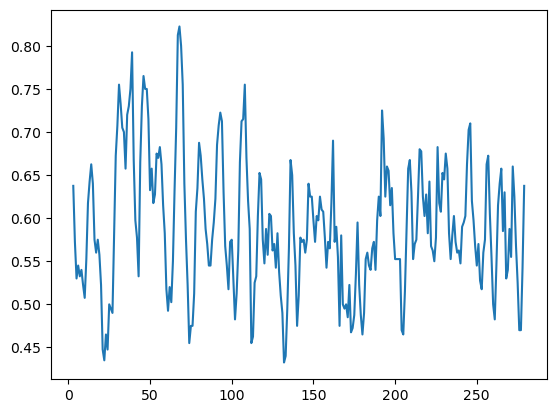

In [21]:
pd.Series(accs).rolling(4).mean().plot()

In [26]:
# Print results for each window
for result in results:
    print(f"Train period: {result['train_period_start']} - {result['train_period_end']}, Test period: {result['test_period_start']} - {result['test_period_end']}")
    print(f"Accuracy on high confidence predictions: {result['accuracy']}\n")

Train period: 2020-01-01 00:00:00 - 2020-01-01 00:00:00, Test period: 2020-01-01 00:00:00 - 2020-01-06 00:00:00


KeyError: 'accuracy'

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd

def train_and_evaluate(merged_df):
    # Handle missing values
    merged_df.fillna(0, inplace=True)
    merged_df.replace([np.inf, -np.inf], 0, inplace=True)

    # Select features and target variable
    features = merged_df.columns[8:].tolist()
    X = merged_df[features].copy()
    y = merged_df['SignificantPriceJump']

    # Data scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

    # Model training
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Model evaluation
    y_pred = model.predict(X_test)
    classification_report_output = classification_report(y_test, y_pred)
    confusion_matrix_output = confusion_matrix(y_test, y_pred)

    # Display results
    print(classification_report_output)
    print(confusion_matrix_output)

    # Predictions and probabilities
    probabilities = model.predict_proba(X_test)
    prob_df = pd.DataFrame(probabilities, columns=['Prob_Negative', 'Prob_Positive'])
    
    return float(classification_report_output.split('\n')[5][-14:-10])

    return classification_report_output, confusion_matrix_output, prob_df

# Usage Example
# merged_df = ... # Your DataFrame
acc = train_and_evaluate(merged_df)


              precision    recall  f1-score   support

       False       0.62      0.66      0.64       363
        True       0.63      0.59      0.61       360

    accuracy                           0.62       723
   macro avg       0.62      0.62      0.62       723
weighted avg       0.62      0.62      0.62       723

[[239 124]
 [149 211]]


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
false = merged_df[merged_df['SignificantPriceJump'] == False].copy()
results = []

for i in range(20):
    for days in [2, 3, 4, 5, 6, 7, 8]:

        df_ = merged_df[merged_df['DaysAfterTrigger'] == days]
        print('Lag days: ', days)
        df_ = pd.concat([df_, false.sample(df_.shape[0])])
        res = train_and_evaluate(df_)
        results.append([days, res])
        print()

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Lag days:  2
              precision    recall  f1-score   support

       False       0.65      0.58      0.61        59
        True       0.62      0.69      0.66        59

    accuracy                           0.64       118
   macro avg       0.64      0.64      0.63       118
weighted avg       0.64      0.64      0.63       118

[[34 25]
 [18 41]]

Lag days:  3
              precision    recall  f1-score   support

       False       0.60      0.49      0.54        55
        True       0.57      0.67      0.62        55

    accuracy                           0.58       110
   macro avg       0.58      0.58      0.58       110
weighted avg       0.58      0.58      0.58       110

[[27 28]
 [18 37]]

Lag days:  4
              precision    recall  f1-score   support

       False       0.59      0.59      0.59        51
        True       0.59      0.59      0.59        51

    accuracy                           0.59       102
   macro avg       0.59      0.59      0.59      

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.60      0.59      0.59        51
        True       0.60      0.61      0.60        51

    accuracy                           0.60       102
   macro avg       0.60      0.60      0.60       102
weighted avg       0.60      0.60      0.60       102

[[30 21]
 [20 31]]

Lag days:  5
              precision    recall  f1-score   support

       False       0.54      0.61      0.57        57
        True       0.54      0.46      0.50        56

    accuracy                           0.54       113
   macro avg       0.54      0.54      0.54       113
weighted avg       0.54      0.54      0.54       113

[[35 22]
 [30 26]]

Lag days:  6
              precision    recall  f1-score   support

       False       0.55      0.51      0.53        43
        True       0.54      0.58      0.56        43

    accuracy                           0.55        86
   macro avg       0.55      0.55      0.55        86
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.59      0.61      0.60        57
        True       0.59      0.57      0.58        56

    accuracy                           0.59       113
   macro avg       0.59      0.59      0.59       113
weighted avg       0.59      0.59      0.59       113

[[35 22]
 [24 32]]

Lag days:  6
              precision    recall  f1-score   support

       False       0.52      0.51      0.52        43
        True       0.52      0.53      0.53        43

    accuracy                           0.52        86
   macro avg       0.52      0.52      0.52        86
weighted avg       0.52      0.52      0.52        86

[[22 21]
 [20 23]]

Lag days:  7
              precision    recall  f1-score   support

       False       0.56      0.53      0.54        47
        True       0.55      0.57      0.56        47

    accuracy                           0.55        94
   macro avg       0.55      0.55      0.55        94
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.55      0.47      0.51        47
        True       0.54      0.62      0.57        47

    accuracy                           0.54        94
   macro avg       0.54      0.54      0.54        94
weighted avg       0.54      0.54      0.54        94

[[22 25]
 [18 29]]

Lag days:  8
              precision    recall  f1-score   support

       False       0.58      0.62      0.60        50
        True       0.60      0.56      0.58        50

    accuracy                           0.59       100
   macro avg       0.59      0.59      0.59       100
weighted avg       0.59      0.59      0.59       100

[[31 19]
 [22 28]]

Lag days:  2
              precision    recall  f1-score   support

       False       0.66      0.66      0.66        59
        True       0.66      0.66      0.66        59

    accuracy                           0.66       118
   macro avg       0.66      0.66      0.66       118
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.60      0.58      0.59        57
        True       0.59      0.61      0.60        56

    accuracy                           0.59       113
   macro avg       0.59      0.59      0.59       113
weighted avg       0.59      0.59      0.59       113

[[33 24]
 [22 34]]

Lag days:  6
              precision    recall  f1-score   support

       False       0.64      0.58      0.61        43
        True       0.62      0.67      0.64        43

    accuracy                           0.63        86
   macro avg       0.63      0.63      0.63        86
weighted avg       0.63      0.63      0.63        86

[[25 18]
 [14 29]]

Lag days:  7
              precision    recall  f1-score   support

       False       0.59      0.55      0.57        47
        True       0.58      0.62      0.60        47

    accuracy                           0.59        94
   macro avg       0.59      0.59      0.58        94
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

              precision    recall  f1-score   support

       False       0.68      0.75      0.71        59
        True       0.72      0.64      0.68        59

    accuracy                           0.69       118
   macro avg       0.70      0.69      0.69       118
weighted avg       0.70      0.69      0.69       118

[[44 15]
 [21 38]]

Lag days:  3
              precision    recall  f1-score   support

       False       0.70      0.60      0.65        55
        True       0.65      0.75      0.69        55

    accuracy                           0.67       110
   macro avg       0.68      0.67      0.67       110
weighted avg       0.68      0.67      0.67       110

[[33 22]
 [14 41]]

Lag days:  4
              precision    recall  f1-score   support

       False       0.59      0.57      0.58        51
        True       0.58      0.61      0.60        51

    accuracy                           0.59       102
   macro avg       0.59      0.59      0.59       102
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

              precision    recall  f1-score   support

       False       0.59      0.67      0.62        51
        True       0.61      0.53      0.57        51

    accuracy                           0.60       102
   macro avg       0.60      0.60      0.60       102
weighted avg       0.60      0.60      0.60       102

[[34 17]
 [24 27]]

Lag days:  5
              precision    recall  f1-score   support

       False       0.53      0.54      0.54        57
        True       0.53      0.52      0.52        56

    accuracy                           0.53       113
   macro avg       0.53      0.53      0.53       113
weighted avg       0.53      0.53      0.53       113

[[31 26]
 [27 29]]

Lag days:  6
              precision    recall  f1-score   support

       False       0.64      0.63      0.64        43
        True       0.64      0.65      0.64        43

    accuracy                           0.64        86
   macro avg       0.64      0.64      0.64        86
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.62      0.47      0.54        55
        True       0.57      0.71      0.63        55

    accuracy                           0.59       110
   macro avg       0.60      0.59      0.59       110
weighted avg       0.60      0.59      0.59       110

[[26 29]
 [16 39]]

Lag days:  4
              precision    recall  f1-score   support

       False       0.58      0.63      0.60        51
        True       0.60      0.55      0.57        51

    accuracy                           0.59       102
   macro avg       0.59      0.59      0.59       102
weighted avg       0.59      0.59      0.59       102

[[32 19]
 [23 28]]

Lag days:  5
              precision    recall  f1-score   support

       False       0.55      0.53      0.54        57
        True       0.53      0.55      0.54        56

    accuracy                           0.54       113
   macro avg       0.54      0.54      0.54       113
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.57      0.49      0.53        43
        True       0.55      0.63      0.59        43

    accuracy                           0.56        86
   macro avg       0.56      0.56      0.56        86
weighted avg       0.56      0.56      0.56        86

[[21 22]
 [16 27]]

Lag days:  7
              precision    recall  f1-score   support

       False       0.56      0.57      0.57        47
        True       0.57      0.55      0.56        47

    accuracy                           0.56        94
   macro avg       0.56      0.56      0.56        94
weighted avg       0.56      0.56      0.56        94

[[27 20]
 [21 26]]

Lag days:  8
              precision    recall  f1-score   support

       False       0.47      0.44      0.45        50
        True       0.47      0.50      0.49        50

    accuracy                           0.47       100
   macro avg       0.47      0.47      0.47       100
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.63      0.65      0.64        51
        True       0.64      0.63      0.63        51

    accuracy                           0.64       102
   macro avg       0.64      0.64      0.64       102
weighted avg       0.64      0.64      0.64       102

[[33 18]
 [19 32]]

Lag days:  5
              precision    recall  f1-score   support

       False       0.61      0.65      0.63        57
        True       0.62      0.57      0.59        56

    accuracy                           0.61       113
   macro avg       0.61      0.61      0.61       113
weighted avg       0.61      0.61      0.61       113

[[37 20]
 [24 32]]

Lag days:  6
              precision    recall  f1-score   support

       False       0.63      0.51      0.56        43
        True       0.59      0.70      0.64        43

    accuracy                           0.60        86
   macro avg       0.61      0.60      0.60        86
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.60      0.57      0.59        47
        True       0.59      0.62      0.60        47

    accuracy                           0.60        94
   macro avg       0.60      0.60      0.60        94
weighted avg       0.60      0.60      0.60        94

[[27 20]
 [18 29]]

Lag days:  8
              precision    recall  f1-score   support

       False       0.55      0.56      0.55        50
        True       0.55      0.54      0.55        50

    accuracy                           0.55       100
   macro avg       0.55      0.55      0.55       100
weighted avg       0.55      0.55      0.55       100

[[28 22]
 [23 27]]

Lag days:  2
              precision    recall  f1-score   support

       False       0.55      0.47      0.51        59
        True       0.54      0.61      0.57        59

    accuracy                           0.54       118
   macro avg       0.54      0.54      0.54       118
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.60      0.58      0.59        55
        True       0.60      0.62      0.61        55

    accuracy                           0.60       110
   macro avg       0.60      0.60      0.60       110
weighted avg       0.60      0.60      0.60       110

[[32 23]
 [21 34]]

Lag days:  4
              precision    recall  f1-score   support

       False       0.51      0.49      0.50        51
        True       0.51      0.53      0.52        51

    accuracy                           0.51       102
   macro avg       0.51      0.51      0.51       102
weighted avg       0.51      0.51      0.51       102

[[25 26]
 [24 27]]

Lag days:  5
              precision    recall  f1-score   support

       False       0.55      0.53      0.54        57
        True       0.53      0.55      0.54        56

    accuracy                           0.54       113
   macro avg       0.54      0.54      0.54       113
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.60      0.63      0.61        43
        True       0.61      0.58      0.60        43

    accuracy                           0.60        86
   macro avg       0.60      0.60      0.60        86
weighted avg       0.60      0.60      0.60        86

[[27 16]
 [18 25]]

Lag days:  7
              precision    recall  f1-score   support

       False       0.65      0.66      0.65        47
        True       0.65      0.64      0.65        47

    accuracy                           0.65        94
   macro avg       0.65      0.65      0.65        94
weighted avg       0.65      0.65      0.65        94

[[31 16]
 [17 30]]

Lag days:  8
              precision    recall  f1-score   support

       False       0.52      0.54      0.53        50
        True       0.52      0.50      0.51        50

    accuracy                           0.52       100
   macro avg       0.52      0.52      0.52       100
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.65      0.59      0.62        51
        True       0.62      0.69      0.65        51

    accuracy                           0.64       102
   macro avg       0.64      0.64      0.64       102
weighted avg       0.64      0.64      0.64       102

[[30 21]
 [16 35]]

Lag days:  5
              precision    recall  f1-score   support

       False       0.62      0.67      0.64        57
        True       0.63      0.59      0.61        56

    accuracy                           0.63       113
   macro avg       0.63      0.63      0.63       113
weighted avg       0.63      0.63      0.63       113

[[38 19]
 [23 33]]

Lag days:  6
              precision    recall  f1-score   support

       False       0.58      0.60      0.59        43
        True       0.59      0.56      0.57        43

    accuracy                           0.58        86
   macro avg       0.58      0.58      0.58        86
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

              precision    recall  f1-score   support

       False       0.62      0.57      0.59        51
        True       0.60      0.65      0.62        51

    accuracy                           0.61       102
   macro avg       0.61      0.61      0.61       102
weighted avg       0.61      0.61      0.61       102

[[29 22]
 [18 33]]

Lag days:  5
              precision    recall  f1-score   support

       False       0.53      0.54      0.53        57
        True       0.52      0.50      0.51        56

    accuracy                           0.52       113
   macro avg       0.52      0.52      0.52       113
weighted avg       0.52      0.52      0.52       113

[[31 26]
 [28 28]]

Lag days:  6
              precision    recall  f1-score   support

       False       0.54      0.51      0.52        43
        True       0.53      0.56      0.55        43

    accuracy                           0.53        86
   macro avg       0.53      0.53      0.53        86
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

              precision    recall  f1-score   support

       False       0.69      0.63      0.65        59
        True       0.66      0.71      0.68        59

    accuracy                           0.67       118
   macro avg       0.67      0.67      0.67       118
weighted avg       0.67      0.67      0.67       118

[[37 22]
 [17 42]]

Lag days:  3
              precision    recall  f1-score   support

       False       0.65      0.55      0.59        55
        True       0.61      0.71      0.66        55

    accuracy                           0.63       110
   macro avg       0.63      0.63      0.62       110
weighted avg       0.63      0.63      0.62       110

[[30 25]
 [16 39]]

Lag days:  4
              precision    recall  f1-score   support

       False       0.52      0.49      0.51        51
        True       0.52      0.55      0.53        51

    accuracy                           0.52       102
   macro avg       0.52      0.52      0.52       102
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.65      0.55      0.59        55
        True       0.61      0.71      0.66        55

    accuracy                           0.63       110
   macro avg       0.63      0.63      0.62       110
weighted avg       0.63      0.63      0.62       110

[[30 25]
 [16 39]]

Lag days:  4
              precision    recall  f1-score   support

       False       0.62      0.69      0.65        51
        True       0.65      0.59      0.62        51

    accuracy                           0.64       102
   macro avg       0.64      0.64      0.64       102
weighted avg       0.64      0.64      0.64       102

[[35 16]
 [21 30]]

Lag days:  5
              precision    recall  f1-score   support

       False       0.47      0.44      0.45        57
        True       0.47      0.50      0.48        56

    accuracy                           0.47       113
   macro avg       0.47      0.47      0.47       113
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.69      0.68      0.68        59
        True       0.68      0.69      0.69        59

    accuracy                           0.69       118
   macro avg       0.69      0.69      0.69       118
weighted avg       0.69      0.69      0.69       118

[[40 19]
 [18 41]]

Lag days:  3
              precision    recall  f1-score   support

       False       0.60      0.58      0.59        55
        True       0.60      0.62      0.61        55

    accuracy                           0.60       110
   macro avg       0.60      0.60      0.60       110
weighted avg       0.60      0.60      0.60       110

[[32 23]
 [21 34]]

Lag days:  4
              precision    recall  f1-score   support

       False       0.61      0.59      0.60        51
        True       0.60      0.63      0.62        51

    accuracy                           0.61       102
   macro avg       0.61      0.61      0.61       102
weighted

<AxesSubplot:ylabel='period'>

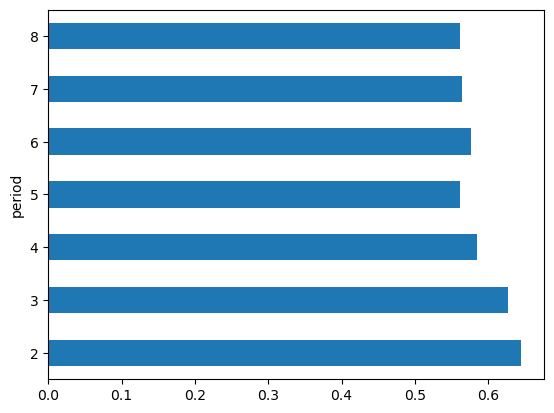

In [36]:
pd.DataFrame(results, columns = ['period', 'acc']).groupby('period')['acc'].mean().plot.barh()

In [37]:
#!pip install lightgbm

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from lightgbm import LGBMClassifier

def train_and_evaluate_lgbm(merged_df):
    # Handle missing values
    merged_df.fillna(0, inplace=True)
    merged_df.replace([np.inf, -np.inf], 0, inplace=True)

    # Select features and target variable
    features = merged_df.columns[8:].tolist()
    X = merged_df[features].copy()
    y = merged_df['SignificantPriceJump']

    # Data scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

    # Model training with LightGBM Classifier
    model = LGBMClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Model evaluation
    y_pred = model.predict(X_test)
    classification_report_output = classification_report(y_test, y_pred)
    confusion_matrix_output = confusion_matrix(y_test, y_pred)

    # Display results
    print(classification_report_output)
    print(confusion_matrix_output)

    # Predictions and probabilities
    probabilities = model.predict_proba(X_test)
    prob_df = pd.DataFrame(probabilities, columns=['Prob_Negative', 'Prob_Positive'])
    
    return float(classification_report_output.split('\n')[5][-14:-10])

    return classification_report_output, confusion_matrix_output, prob_df

# Usage Example
# merged_df = ... # Your DataFrame
classification_report, confusion_matrix, prob_df = train_and_evaluate_lgbm(merged_df)


[LightGBM] [Info] Number of positive: 840, number of negative: 845
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44362
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 174
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498516 -> initscore=-0.005935
[LightGBM] [Info] Start training from score -0.005935
              precision    recall  f1-score   support

       False       0.62      0.61      0.62       363
        True       0.61      0.61      0.61       360

    accuracy                           0.61       723
   macro avg       0.61      0.61      0.61       723
weighted avg       0.61      0.61      0.61       723

[[223 140]
 [139 221]]


TypeError: cannot unpack non-iterable float object

0.57

In [40]:
false = merged_df[merged_df['SignificantPriceJump'] == False].copy()
results_gbm = []

for i in range(20):
    for days in [2, 3, 4, 5, 6, 7, 8]:

        df_ = merged_df[merged_df['DaysAfterTrigger'] == days]
        print('Lag days: ', days)
        df_ = pd.concat([df_, false.sample(df_.shape[0])])
        res = train_and_evaluate_lgbm(df_)
        results_gbm.append([days, res])
        print()

Lag days:  2
[LightGBM] [Info] Number of positive: 137, number of negative: 137
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14408
[LightGBM] [Info] Number of data points in the train set: 274, number of used features: 174
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

<AxesSubplot:ylabel='period'>

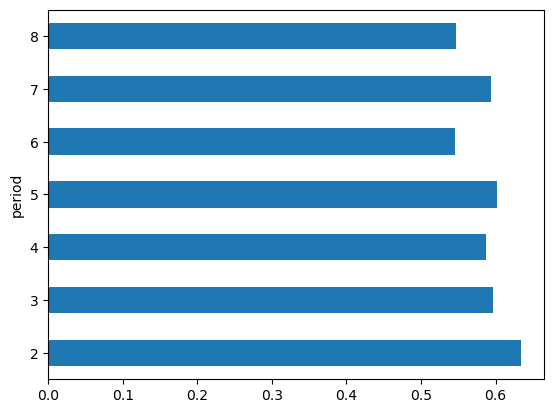

In [41]:
pd.DataFrame(results_gbm, columns = ['period', 'acc']).groupby('period')['acc'].mean().plot.barh()

<AxesSubplot:ylabel='period'>

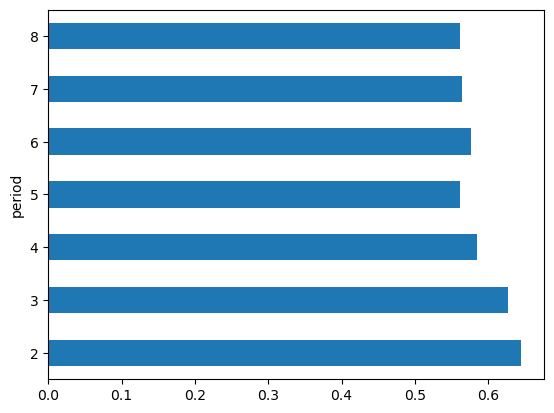

In [42]:
pd.DataFrame(results, columns = ['period', 'acc']).groupby('period')['acc'].mean().plot.barh()

In [132]:
df_

Empty DataFrame
Columns: [TriggerDate, TriggerClose, PriceJumpDate, Close, PriceJumpZScore, DaysAfterTrigger, SignificantPriceJump, Ticker, short_ratio_mean_1, short_ratio_mean_5, short_ratio_mean_10, short_ratio_mean_21, short_ratio_mean_42, short_ratio_mean_1_div_mean_5, short_ratio_mean_5_div_mean_1, short_ratio_mean_1_div_mean_10, short_ratio_mean_10_div_mean_1, short_ratio_mean_1_div_mean_21, short_ratio_mean_21_div_mean_1, short_ratio_mean_1_div_mean_42, short_ratio_mean_42_div_mean_1, short_ratio_mean_5_div_mean_10, short_ratio_mean_10_div_mean_5, short_ratio_mean_5_div_mean_21, short_ratio_mean_21_div_mean_5, short_ratio_mean_5_div_mean_42, short_ratio_mean_42_div_mean_5, short_ratio_mean_10_div_mean_21, short_ratio_mean_21_div_mean_10, short_ratio_mean_10_div_mean_42, short_ratio_mean_42_div_mean_10, short_ratio_mean_21_div_mean_42, short_ratio_mean_42_div_mean_21, short_ratio_mean_1_roc, short_ratio_mean_5_roc, short_ratio_mean_10_roc, short_ratio_mean_21_roc, short_ratio_mean_42_roc, short_ratio_mean_1_div_mean_5_roc, short_ratio_mean_5_div_mean_1_roc, short_ratio_mean_1_div_mean_10_roc, short_ratio_mean_10_div_mean_1_roc, short_ratio_mean_1_div_mean_21_roc, short_ratio_mean_21_div_mean_1_roc, short_ratio_mean_1_div_mean_42_roc, short_ratio_mean_42_div_mean_1_roc, short_ratio_mean_5_div_mean_10_roc, short_ratio_mean_10_div_mean_5_roc, short_ratio_mean_5_div_mean_21_roc, short_ratio_mean_21_div_mean_5_roc, short_ratio_mean_5_div_mean_42_roc, short_ratio_mean_42_div_mean_5_roc, short_ratio_mean_10_div_mean_21_roc, short_ratio_mean_21_div_mean_10_roc, short_ratio_mean_10_div_mean_42_roc, short_ratio_mean_42_div_mean_10_roc, short_ratio_mean_21_div_mean_42_roc, short_ratio_mean_42_div_mean_21_roc, short_exempt_percent_mean_1, short_exempt_percent_mean_5, short_exempt_percent_mean_10, short_exempt_percent_mean_21, short_exempt_percent_mean_42, short_exempt_percent_mean_1_div_mean_5, short_exempt_percent_mean_5_div_mean_1, short_exempt_percent_mean_1_div_mean_10, short_exempt_percent_mean_10_div_mean_1, short_exempt_percent_mean_1_div_mean_21, short_exempt_percent_mean_21_div_mean_1, short_exempt_percent_mean_1_div_mean_42, short_exempt_percent_mean_42_div_mean_1, short_exempt_percent_mean_5_div_mean_10, short_exempt_percent_mean_10_div_mean_5, short_exempt_percent_mean_5_div_mean_21, short_exempt_percent_mean_21_div_mean_5, short_exempt_percent_mean_5_div_mean_42, short_exempt_percent_mean_42_div_mean_5, short_exempt_percent_mean_10_div_mean_21, short_exempt_percent_mean_21_div_mean_10, short_exempt_percent_mean_10_div_mean_42, short_exempt_percent_mean_42_div_mean_10, short_exempt_percent_mean_21_div_mean_42, short_exempt_percent_mean_42_div_mean_21, short_exempt_percent_mean_1_roc, short_exempt_percent_mean_5_roc, short_exempt_percent_mean_10_roc, short_exempt_percent_mean_21_roc, short_exempt_percent_mean_42_roc, short_exempt_percent_mean_1_div_mean_5_roc, short_exempt_percent_mean_5_div_mean_1_roc, short_exempt_percent_mean_1_div_mean_10_roc, short_exempt_percent_mean_10_div_mean_1_roc, short_exempt_percent_mean_1_div_mean_21_roc, short_exempt_percent_mean_21_div_mean_1_roc, short_exempt_percent_mean_1_div_mean_42_roc, short_exempt_percent_mean_42_div_mean_1_roc, short_exempt_percent_mean_5_div_mean_10_roc, short_exempt_percent_mean_10_div_mean_5_roc, short_exempt_percent_mean_5_div_mean_21_roc, short_exempt_percent_mean_21_div_mean_5_roc, ...]
Index: []

[0 rows x 178 columns]

In [130]:
false.sample(4)

TriggerDate  TriggerClose PriceJumpDate  Close  PriceJumpZScore  \
2952  2019-06-17    105.201796             0    0.0              0.0   
2560  2020-10-01    122.778283             0    0.0              0.0   
3453  2020-05-12    139.828484             0    0.0              0.0   
850   2020-06-08     24.139427             0    0.0              0.0   

      DaysAfterTrigger  SignificantPriceJump Ticker  short_ratio_mean_1  \
2952               0.0                 False    TXN            0.565732   
2560               0.0                 False    FIS            0.800535   
3453               0.0                 False    DHR            0.650610   
850                0.0                 False    GLW            0.409967   

      short_ratio_mean_5  ...  gamma_Time_Spread_rolling_1  \
2952            0.709533  ...                     0.999723   
2560            0.716849  ...                     0.411696   
3453            0.501056  ...                     0.270159   
850             0.376533  ...                     0.296431   

      gamma_Time_Spread_rolling_5  gamma_Time_Spread_rolling_10  \
2952                     0.986916                      0.959672   
2560                     0.549573                      0.739984   
3453                     0.339773                      0.426694   
850                      0.545335                      0.515216   

      gamma_Time_Spread_rolling_21  gamma_Time_Spread_rolling_42  \
2952                      0.905909                      0.892003   
2560                      0.814202                      0.717582   
3453                      0.461351                      0.500603   
850                       0.636980                      0.657751   

      gamma_30_z_score  gamma_Skew_z_score  gamma_Time_Spread_z_score  \
2952         -1.021639            0.840944                   0.891127   
2560          0.080717            0.474371                  -0.246056   
3453          0.075622            0.446046                  -0.513665   
850          -0.186298           -0.936628                  -0.242352   

      IV_HV_Difference  vwap_close_pct  
2952          0.035765        0.971348  
2560          0.063672        1.034233  
3453         -0.002715        1.073022  
850          -0.032355        1.195963  

[4 rows x 178 columns]

In [126]:
train_and_evaluate(merged_df[merged_df['DaysAfterTrigger'] == 2])

/tmp/ipykernel_4976/1927117639.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.fillna(0, inplace=True)
/tmp/ipykernel_4976/1927117639.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.replace([np.inf, -np.inf], 0, inplace=True)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: True

In [124]:
merged_df

TriggerDate  TriggerClose PriceJumpDate      Close  PriceJumpZScore  \
0     2019-03-11     52.226633    2019-03-21  52.756691         2.987785   
1     2019-03-12     51.400575    2019-03-21  52.756691         2.987785   
2     2019-03-13     50.732777    2019-03-21  52.756691         2.987785   
3     2019-03-15     49.820675    2019-03-21  52.756691         2.987785   
4     2019-03-18     49.751754    2019-03-21  52.756691         2.987785   
...          ...           ...           ...        ...              ...   
6069  2019-03-08     48.012203             0   0.000000         0.000000   
6070  2023-08-16     47.434397             0   0.000000         0.000000   
6071  2019-06-19     49.776811             0   0.000000         0.000000   
6072  2019-02-11     47.079677             0   0.000000         0.000000   
6073  2022-06-01     56.629056             0   0.000000         0.000000   

      DaysAfterTrigger  SignificantPriceJump Ticker  short_ratio_mean_1  \
0                  8.0                  True    WDC            0.455417   
1                  7.0                  True    WDC            0.525774   
2                  6.0                  True    WDC            0.446586   
3                  4.0                  True    WDC            0.464885   
4                  3.0                  True    WDC            0.469127   
...                ...                   ...    ...                 ...   
6069               0.0                 False    NEE            0.632799   
6070               0.0                 False    NEE            0.580631   
6071               0.0                 False    NEE            0.500347   
6072               0.0                 False    NEE            0.622944   
6073               0.0                 False    NEE            0.612841   

      short_ratio_mean_5  ...  gamma_Time_Spread_rolling_1  \
0               0.483421  ...                     0.482897   
1               0.486444  ...                     0.712365   
2               0.467740  ...                     0.769523   
3               0.450175  ...                     0.464030   
4               0.452917  ...                     0.557502   
...                  ...  ...                          ...   
6069            0.589095  ...                     0.365565   
6070            0.562677  ...                     0.977674   
6071            0.484958  ...                     0.832385   
6072            0.478840  ...                     1.000000   
6073            0.552248  ...                     0.217258   

      gamma_Time_Spread_rolling_5  gamma_Time_Spread_rolling_10  \
0                        0.017609                      0.330419   
1                       -0.073976                      0.266560   
2                        0.026879                      0.290122   
3                        0.525051                      0.271330   
4                        0.629489                      0.263258   
...                           ...                           ...   
6069                     0.359239                      0.354477   
6070                     0.985784                      0.847894   
6071                     0.807328                      0.796801   
6072                     0.882248                      0.640062   
6073                    -0.036280                      0.206339   

      gamma_Time_Spread_rolling_21  gamma_Time_Spread_rolling_42  \
0                         0.446315                      0.662673   
1                         0.447807                      0.620506   
2                         0.453415                      0.612013   
3                         0.428324                      0.608803   
4                         0.415457                      0.601810   
...                            ...                           ...   
6069                      0.609318                      0.585392   
6070                      0.741979                      0.986332   
6071                      0.8

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Assuming your DataFrame is named 'merged_df'
# Handle missing values (if any)
merged_df.fillna(0, inplace=True)
merged_df.replace([np.inf, -np.inf], 0, inplace=True)

# Feature selection: Choose columns that are relevant as features
# Exclude columns like 'PriceJumpDate' which are not available at prediction time
features = merged_df.columns[8:].tolist()

# Extract the features and labels
X = merged_df[features]
y = merged_df['SignificantPriceJump']

# Data Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# First, extract the indices of the rows
indices = merged_df.index

# Split the indices
X_train_idx, X_test_idx, y_train, y_test = train_test_split(
    indices, y, test_size=0.3, random_state=42, stratify=y
)

# Using the indices to create the actual training and test sets
X_train = merged_df.loc[X_train_idx, features]
X_test = merged_df.loc[X_test_idx, features]

# Scaling the split data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Model Evaluation
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Predictions can be made using model.predict() on new data
probabilities = model.predict_proba(X_test_scaled)# [:, 1]

# Create a DataFrame from the probabilities and the original index
prob_df = pd.DataFrame(probabilities, index=X_test_idx, columns=['Prob_Negative', 'Prob_Positive'])
print(prob_df.head()) # Display the first few entries of probability DataFrame



              precision    recall  f1-score   support

       False       0.58      0.63      0.60      1041
        True       0.59      0.55      0.57      1035

    accuracy                           0.59      2076
   macro avg       0.59      0.59      0.59      2076
weighted avg       0.59      0.59      0.59      2076

[[653 388]
 [465 570]]
      Prob_Negative  Prob_Positive
3064       0.560609       0.439391
6876       0.500251       0.499749
4031       0.273586       0.726414
4849       0.362094       0.637906
6571       0.613354       0.386646


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [112]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

def fetch_and_preprocess_data(ticker, sdate, edate, beta_adjust):
    # Example function to mimic data fetching and preprocessing
    df_data = get_data(ticker, sdate, edate, beta_adjust)
    # Add any preprocessing steps here
    return df_data


def feature_engineering(df_data, ticker, lag_period, analysis, greek_analysis, price_iv_analysis):
    # Example feature engineering steps
    price_jumps_df = identify_price_jumps(
        df_data, z_score_threshold=2.5, stability_threshold=1, 
        include_negative_class=True, remove_duplicate_price_jump_dates=False, 
        lag_days_start=lag_period, lag_days_end=lag_period
    )
    
    # Set as index
    price_jumps_df.set_index('TriggerDate', inplace = True)
    price_jumps_df.index = pd.to_datetime(price_jumps_df.index)

    df_short_ratio = analysis.calculate_short_ratio_means(ticker, include_diff=True, include_roc=True)
    df_short_sale_exempt = analysis.calculate_short_exempt_means(ticker, include_diff=True, include_roc=True)
    df_investment_values = analysis.calculate_investment_values(ticker, include_diff=True, include_roc=True)
    df_iv = greek_analysis.get_analysis_for_ticker(ticker, 'iv', include_rolling=True, include_z_score=True)
    df_gamma = greek_analysis.get_analysis_for_ticker(ticker, 'gamma', include_rolling=True, include_z_score=True)
    df_iv_hv = price_iv_analysis.compare_iv_hv(ticker)
    df_vwap = price_iv_analysis.compare_price_to_vwap(ticker)

    return price_jumps_df, [df_short_ratio, df_short_sale_exempt, df_investment_values, df_iv, df_gamma, df_iv_hv, df_vwap]


def merge_data(price_jumps_df, additional_dfs):
    # Merge the dataframes together
    for df_ in additional_dfs:
        df_.index = pd.to_datetime(df_.index)
        price_jumps_df = price_jumps_df.merge(df_, left_index=True, right_index=True, how='left')
    return price_jumps_df


def train_and_evaluate_model(merged_df):
    features = merged_df.columns[8:].tolist()
    X = merged_df[features].copy()
    y = merged_df['SignificantPriceJump']

    # Replace inf/-inf with NaN
    X.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Cap extreme values if needed (optional, customize as per your data's needs)
    X = np.clip(X, a_min=-1e9, a_max=1e9)  # Example capping

    # Impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # Use RobustScaler to handle outliers better
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probabilities = model.predict_proba(X_test)

    evaluation_metrics = {
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    prob_df = pd.DataFrame(probabilities, columns=['Prob_Negative', 'Prob_Positive'])

    return model, prob_df, evaluation_metrics


def main_pipeline(tickers, sdate, edate, beta_adjust, lag_periods, analysis, greek_analysis, price_iv_analysis):
    
    # Pre-fetch and preprocess data for all tickers
    pre_fetched_data = pre_fetch_data(tickers, sdate, edate, beta_adjust)

    for lag_period in lag_periods:
        df_repo = []
        for ticker in tqdm(tickers):
            try:
                df_data = pre_fetched_data.get(ticker)
                if df_data is not None:
                    # df_data = fetch_and_preprocess_data(ticker, sdate, edate, beta_adjust)
                    price_jumps_df, additional_dfs = feature_engineering(df_data, ticker, lag_period, analysis, greek_analysis, price_iv_analysis)
                    merged_df = merge_data(price_jumps_df, additional_dfs)
                    df_repo.append(merged_df)
                else:
                    print(f"No data available for {ticker}")
            except Exception as e:
                print(ticker, type(e), e)

        combined_df = pd.concat(df_repo).reset_index(drop=True)
        model, prob_df, eval_metrics = train_and_evaluate_model(combined_df)
        print(f"Lag Period: {lag_period}")
        print(f"Evaluation Metrics: {eval_metrics['classification_report']}", end = '\n\n')


In [113]:
def pre_fetch_data(tickers, sdate, edate, beta_adjust):
    data_repo = {}
    for ticker in tqdm(tickers):
        try:
            data_repo[ticker] = fetch_and_preprocess_data(ticker, sdate, edate, beta_adjust)
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
    return data_repo


In [114]:
# Initialize your analysis classes
# analysis = ShortSaleVolume()
greek_analysis = GreekAnalysis()
price_iv_analysis = VolatilityAnalysis()

# Define your tickers and other parameters
# tickers = ['AAPL', 'TSLA', 'MMM', 'NVDA', 'AMZN']
sdate = '20180816'
edate = '20231115'
beta_adjust = True
lag_periods = [2, 3, 4, 5, 6, 7, 8]

# Run the pipeline
main_pipeline(tickers, sdate, edate, beta_adjust, lag_periods, analysis, greek_analysis, price_iv_analysis)


  2%|▏         | 1/51 [00:02<01:56,  2.34s/it]

J <class 'ValueError'> NaTType does not support timestamp


 25%|██▌       | 13/51 [01:07<02:49,  4.47s/it]

BKR <class 'ValueError'> NaTType does not support timestamp


 61%|██████    | 31/51 [02:45<01:32,  4.64s/it]

EG <class 'ValueError'> NaTType does not support timestamp


 88%|████████▊ | 45/51 [04:04<00:28,  4.75s/it]

BBWI <class 'ValueError'> NaTType does not support timestamp


100%|██████████| 51/51 [04:40<00:00,  5.49s/it]
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Lag Period: 2
Evaluation Metrics:               precision    recall  f1-score   support

       False       0.57      0.49      0.53       148
        True       0.48      0.56      0.52       125

    accuracy                           0.52       273
   macro avg       0.53      0.53      0.52       273
weighted avg       0.53      0.52      0.52       273




  2%|▏         | 1/51 [00:01<01:37,  1.94s/it]

J <class 'ValueError'> NaTType does not support timestamp


 25%|██▌       | 13/51 [01:05<02:49,  4.47s/it]

BKR <class 'ValueError'> NaTType does not support timestamp


 61%|██████    | 31/51 [02:43<01:32,  4.60s/it]

EG <class 'ValueError'> NaTType does not support timestamp


 88%|████████▊ | 45/51 [04:02<00:29,  4.86s/it]

BBWI <class 'ValueError'> NaTType does not support timestamp


100%|██████████| 51/51 [04:36<00:00,  5.43s/it]


Lag Period: 3
Evaluation Metrics:               precision    recall  f1-score   support

       False       0.48      0.55      0.51       133
        True       0.50      0.44      0.47       140

    accuracy                           0.49       273
   macro avg       0.49      0.49      0.49       273
weighted avg       0.49      0.49      0.49       273




  2%|▏         | 1/51 [00:02<01:52,  2.25s/it]

J <class 'ValueError'> NaTType does not support timestamp


 25%|██▌       | 13/51 [01:06<02:50,  4.49s/it]

BKR <class 'ValueError'> NaTType does not support timestamp


 41%|████      | 21/51 [01:52<02:40,  5.36s/it]


KeyboardInterrupt: 

In [41]:
# !pip install yahoo_fin

In [1]:
import pandas as pd
import numpy as np
from yahoo_fin import stock_info as finance

# Get SPY data
df_spy = finance.get_data('SPY', '20100101', '20231115')
df_spy_returns = df_spy['close'].pct_change().dropna()

# Mock function to mimic the behavior of finance.get_data
def get_data(ticker, sdate = '20180101', edate = '20231115', beta_adjust = True):
    # Assume this function returns a DataFrame similar to the one produced by finance.get_data
    # For demonstration, we're generating a DataFrame with a date range and mock data
    df = finance.get_data(ticker, sdate, edate)
    stock_returns = df.close.pct_change().dropna()
    
    if beta_adjust:
        global df_spy_returns
        
        # Align dates for stock and market returns
        aligned_returns = pd.concat([stock_returns, df_spy_returns], axis=1, join='inner')
        aligned_returns.columns = ['stock', 'market']
        
        # Calculate Beta
        cov_matrix = np.cov(aligned_returns['stock'], aligned_returns['market'])
        beta = cov_matrix[0, 1] / cov_matrix[1, 1]

        # Calculate Beta-Adjusted Returns
        adjusted_returns = aligned_returns['stock'] - beta * aligned_returns['market']
        
        # Reconstruct beta-adjusted close price series
        adjusted_close = [df['close'].iloc[0]]
        for ret in adjusted_returns[1:]:
            adjusted_close.append(adjusted_close[-1] * (1 + ret))

        adjusted_close = pd.Series(adjusted_close, index=adjusted_returns.index)
        adjusted_close.name = 'close'
        
        # Join and return 
        return df.drop('close', axis = 1).join(adjusted_close)
    
    return df
        
        
        


In [2]:
def identify_price_jumps(df, z_score_threshold=2, stability_threshold=1, lookback_period=90, lag_days_start=2, lag_days_end=5, 
                         include_negative_class=False, remove_duplicate_price_jump_dates=False):
    # Calculating daily price changes
    df['PriceChange'] = df['close'].pct_change()
    
    # Calculating rolling statistics
    rolling_mean = df['PriceChange'].rolling(window=lookback_period).mean()
    rolling_std = df['PriceChange'].rolling(window=lookback_period).std()
    
    # Identifying potential price jumps
    positive_results = []
    for i in range(lookback_period, len(df) - lag_days_end):
        current_z_score = (df.iloc[i]['PriceChange'] - rolling_mean[i]) / rolling_std[i]
        if abs(current_z_score) < stability_threshold:
            for lag_day in range(lag_days_start, lag_days_end+1):
                if i+lag_day < len(df):
                    future_price_change = df.iloc[i+lag_day]['PriceChange']
                    future_z_score = (future_price_change - rolling_mean[i+lag_day]) / rolling_std[i+lag_day]
                    if future_z_score > z_score_threshold:
                        positive_results.append({
                            'TriggerDate': df.index[i].date(),
                            'TriggerClose': df.iloc[i]['close'],
                            'PriceJumpDate': df.index[i+lag_day].date(),
                            'Close': df.iloc[i+lag_day]['close'],
                            'PriceJumpZScore': future_z_score,
                            'DaysAfterTrigger': lag_day,
                            'SignificantPriceJump': True,
                            'Ticker': df.iloc[0]['ticker']
                        })
                        break
                        
    # Convert positive results to DataFrame
    positive_results_df = pd.DataFrame(positive_results)

    # If remove_duplicate_price_jump_dates flag is set, remove duplicates
    if remove_duplicate_price_jump_dates:
        # Group by PriceJumpDate and randomly keep one record per group
        positive_results_df = positive_results_df.groupby('PriceJumpDate').apply(lambda x: x.sample(1)).reset_index(drop=True)


    # Sample negative class instances if required
    negative_results = []
    if include_negative_class:
        num_positive = len(positive_results_df)
        sampled_rows = df.iloc[lookback_period:len(df) - lag_days_end].sample(n=num_positive)
        for _, row in sampled_rows.iterrows():
            negative_results.append({
                'TriggerDate': row.name.date(),
                'TriggerClose': row['close'],
                'PriceJumpDate': None,  # No price jump date for negative class
                'Close': None,
                'PriceJumpZScore': None,
                'DaysAfterTrigger': None,
                'SignificantPriceJump': False,
                'Ticker': df.iloc[0]['ticker']
            })

    # Combine positive and negative results
    combined_results = pd.DataFrame(positive_results_df.to_dict('records') + negative_results).fillna(0)


    return combined_results

# Example usage
df = get_data('GME', '2019-01-01', '2023-11-15')
price_jumps_df = identify_price_jumps(df, z_score_threshold=2.5, stability_threshold=1, include_negative_class=True, remove_duplicate_price_jump_dates = True)
price_jumps_df.sample(5)


TriggerDate  TriggerClose PriceJumpDate      Close  PriceJumpZScore  \
3   2020-06-03      0.843991    2020-06-08   0.914322         2.658270   
18  2022-05-20     13.781922    2022-05-25  16.263550         3.766836   
7   2020-10-01      1.713877    2020-10-08   2.321686         5.423451   
0   2020-04-08      0.741725    2020-04-13   1.023979         3.941324   
25  2021-05-21     22.956775             0   0.000000         0.000000   

    DaysAfterTrigger  SignificantPriceJump Ticker  
3                3.0                  True    GME  
18               3.0                  True    GME  
7                5.0                  True    GME  
0                2.0                  True    GME  
25               0.0                 False    GME

In [5]:
# Short sale volume

class ShortSaleVolume:
    
    bucket = 'mads-capstone-2023' 
    data_key = 'FINRA_Short_Sale_Data2.csv' 
    data_location = 's3://{}/{}'.format(bucket, data_key) 
    
    def __init__(self):
        self.has_downloaded = False 
    
    # Function to download data from S3
    def get_data(self):
        if not self.has_downloaded:
            self.df = pd.read_csv(self.data_location)
            self.df.drop(['Unnamed: 0'], axis = 1, inplace = True)
            self.df['shortvolume'] = self.df['totalvolume'] - self.df['shortvolume']
            self.df['longvolume'] = self.df['totalvolume'] - self.df['shortvolume']
            self.df['short_ratio'] = 1 - self.df['short_ratio']
            self.has_downloaded = True
        else:
            pass
        
    def short_ratio(self, ticker):
        # Check if data has been downloaded locally
        self.get_data()
        
        # Return data for ticker 
        df_ = self.df[self.df['ticker'] == ticker].copy()
        df_['date'] = pd.to_datetime(df_['date'])
        df_.set_index('date', inplace=True)
        return df_

    
    def calculate_short_ratio_means(self, ticker='GME', include_diff=False, include_roc=False):
        df = self.short_ratio(ticker)
        periods = [1, 5, 10, 21, 42]
        for period in periods:
            df[f'short_ratio_mean_{period}'] = df['short_ratio'].rolling(window=period).mean()

        if include_diff:
            for i in range(len(periods)):
                for j in range(i + 1, len(periods)):
                    df[f'short_ratio_mean_{periods[i]}_div_mean_{periods[j]}'] = df[f'short_ratio_mean_{periods[i]}'] / df[f'short_ratio_mean_{periods[j]}']
                    df[f'short_ratio_mean_{periods[j]}_div_mean_{periods[i]}'] = df[f'short_ratio_mean_{periods[j]}'] / df[f'short_ratio_mean_{periods[i]}']

        if include_roc:
            # print('working')
            for col in df.columns:
                if 'short_ratio_mean_' in col:
                    df[f'{col}_roc'] = df[col].pct_change() * 100

        result_df = df[[col for col in df.columns if 'short_ratio_mean_' in col or ('roc' in col and 'short_ratio_mean_' in col)]]
        return result_df

    def calculate_short_exempt_means(self, ticker='GME', include_diff=False, include_roc=False):
        df = self.short_ratio(ticker)
        periods = [1, 5, 10, 21, 42]

        df['short_exempt_percent'] = (df['shortexemptvolume'] / df['totalvolume'])

        for period in periods:
            df[f'short_exempt_percent_mean_{period}'] = df['short_exempt_percent'].rolling(window=period).mean()

        if include_diff:
            for i in range(len(periods)):
                for j in range(i + 1, len(periods)):
                    df[f'short_exempt_percent_mean_{periods[i]}_div_mean_{periods[j]}'] = df[f'short_exempt_percent_mean_{periods[i]}'] / df[f'short_exempt_percent_mean_{periods[j]}']
                    df[f'short_exempt_percent_mean_{periods[j]}_div_mean_{periods[i]}'] = df[f'short_exempt_percent_mean_{periods[j]}'] / df[f'short_exempt_percent_mean_{periods[i]}']

        if include_roc:
            for col in df.columns:
                if 'short_exempt_percent_mean_' in col:
                    df[f'{col}_roc'] = df[col].pct_change() * 100

        result_df = df[[col for col in df.columns if 'short_exempt_percent_mean_' in col or ('roc' in col and 'short_exempt_percent_mean_' in col)]]
        return result_df
    
    def calculate_investment_values(self, ticker='GME', days=20, investment_amount=1_000_000, include_diff=False, include_roc=False):
        df = self.short_ratio(ticker)

        # Retrieve closing prices from finance API
        closing_prices = finance.get_data(ticker, df.index.min(), df.index.max())['close']
        
        # Merge closing prices with short ratio data
        df = df.merge(closing_prices, left_index=True, right_index=True, how='left')

        # Ensure short_exempt_percent column is calculated before its usage
        df['short_exempt_percent'] = df['shortexemptvolume'] / df['totalvolume']

        # Calculate net short volume and net short shares
        df['net_short_volume'] = df['shortvolume'] - df['longvolume']
        df['net_short_shares'] = investment_amount / df['close']

        # Calculate cumulative net short volume and short exempt volume
        df['cumulative_net_short'] = (df['net_short_volume'] * df['net_short_shares']).rolling(window=days).sum()
        df['cumulative_short_exempt'] = (df['short_exempt_percent'] * df['net_short_shares']).rolling(window=days).sum()

        # Calculate the cumulative values as a percent of total volume
        df['cumulative_net_short_percent'] = df['cumulative_net_short'] / (df['totalvolume'] * df['net_short_shares']).rolling(window=days).sum() * 100
        df['cumulative_short_exempt_percent'] = df['cumulative_short_exempt'] / (df['totalvolume'] * df['net_short_shares']).rolling(window=days).sum() * 100

        if include_diff:
            periods = [1, 5, 10, 21, 42]
            for i in range(len(periods)):
                for j in range(i + 1, len(periods)):
                    df[f'cumulative_net_short_percent_{periods[i]}_div_{periods[j]}'] = df['cumulative_net_short_percent'].rolling(window=periods[i]).mean() / df['cumulative_net_short_percent'].rolling(window=periods[j]).mean()
                    df[f'cumulative_short_exempt_percent_{periods[i]}_div_{periods[j]}'] = df['cumulative_short_exempt_percent'].rolling(window=periods[i]).mean() / df['cumulative_short_exempt_percent'].rolling(window=periods[j]).mean()

        if include_roc:
            for col in ['cumulative_net_short_percent', 'cumulative_short_exempt_percent']:
                df[f'{col}_roc'] = df[col].pct_change() * 100

        selected_cols = ['cumulative_net_short_percent', 'cumulative_short_exempt_percent']
        if include_diff or include_roc:
            selected_cols += [col for col in df.columns if 'cumulative_net_short_percent' in col or 'cumulative_short_exempt_percent' in col]

        return df[selected_cols]

# Example usage 
analysis = ShortSaleVolume()
df_gme_short_ratio = analysis.calculate_short_ratio_means('GME', include_roc = True)
df_gme_short_sale_exempt = analysis.calculate_short_exempt_means('GME', include_roc = False)
df_gme_investment_values = analysis.calculate_investment_values('GME', include_roc = False)


/opt/conda/lib/python3.10/site-packages/fsspec/registry.py:272: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


In [6]:
analysis.df

ticker        date  shortvolume  shortexemptvolume  totalvolume  \
0            A  2018-08-01     530852.0               14.0     658064.0   
1           AA  2018-08-01    1034435.0              817.0    1549350.0   
2         AABA  2018-08-01    2633158.0              370.0    3608955.0   
3          AAC  2018-08-01      50700.0                0.0      93929.0   
4         AADR  2018-08-01       6407.0                0.0       9620.0   
...        ...         ...          ...                ...          ...   
8219451    ZTR  2023-11-28      56733.0                0.0     111235.0   
8219452    ZTS  2023-11-28     337228.0              100.0     543948.0   
8219453   ZUMZ  2023-11-28      23043.0              251.0      55083.0   
8219454    ZUO  2023-11-28      67657.0              120.0     146939.0   
8219455   ZYME  2023-11-28      43317.0               41.0      89479.0   

        market  short_ratio  longvolume  
0          Q,N     0.806687    127212.0  
1          Q,N     0.667657    514915.0  
2          Q,N     0.729618    975797.0  
3          Q,N     0.539769     43229.0  
4          Q,N     0.666008      3213.0  
...        ...          ...         ...  
8219451  B,Q,N     0.510028     54502.0  
8219452  B,Q,N     0.619964    206720.0  
8219453    Q,N     0.418332     32040.0  
8219454    Q,N     0.460443     79282.0  
8219455  B,Q,N     0.484102     46162.0  

[8219456 rows x 8 columns]

In [7]:
df_gme_short_ratio.head()

short_ratio_mean_1  short_ratio_mean_5  short_ratio_mean_10  \
date                                                                      
2018-08-01            0.491204                 NaN                  NaN   
2018-08-02            0.400319                 NaN                  NaN   
2018-08-03            0.302492                 NaN                  NaN   
2018-08-06            0.345414                 NaN                  NaN   
2018-08-07            0.524622             0.41281                  NaN   

            short_ratio_mean_21  short_ratio_mean_42  short_ratio_mean_1_roc  \
date                                                                           
2018-08-01                  NaN                  NaN                     NaN   
2018-08-02                  NaN                  NaN              -18.502450   
2018-08-03                  NaN                  NaN              -24.437208   
2018-08-06                  NaN                  NaN               14.189309   
2018-08-07                  NaN                  NaN               51.882097   

            short_ratio_mean_5_roc  short_ratio_mean_10_roc  \
date                                                          
2018-08-01                     NaN                      NaN   
2018-08-02                     NaN                      NaN   
2018-08-03                     NaN                      NaN   
2018-08-06                     NaN                      NaN   
2018-08-07                     NaN                      NaN   

            short_ratio_mean_21_roc  short_ratio_mean_42_roc  
date                                                          
2018-08-01                      NaN                      NaN  
2018-08-02                      NaN                      NaN  
2018-08-03                      NaN                      NaN  
2018-08-06                      NaN                      NaN  
2018-08-07                      NaN                      NaN

In [8]:
import psycopg2
import pandas as pd

class GreekAnalysis:
    def __init__(self):
        self.db_params = {
            'user': 'USER_STRING',    #Removed for Git
            'password': 'PW_STRING',  #Removed for Git
            'host': 'mads-capstone.cmohac77hep9.eu-north-1.rds.amazonaws.com',
            'port': 5432,
            'database': 'mads'
        }

    def get_greeks_data(self, ticker, greek_type):
        with psycopg2.connect(**self.db_params) as db_connection:
            db_connection.autocommit = True
            with db_connection.cursor() as cursor:
                select_query = "SELECT * FROM greeks3 WHERE ticker=%s AND GREEK=%s"
                cursor.execute(select_query, (ticker, greek_type))
                rows = cursor.fetchall()
                df = pd.DataFrame(rows, columns=["ID", "DATE", "INCREMENT", "VALUE", "TICKER", "GREEK", "OPTION_TYPE"])
        return df

    def analyze_data(self, df, greek_type):
        merged_df = self._prepare_merged_dataframe(df, greek_type)
        merged_df[f'{greek_type}_Skew'] = merged_df[f'{greek_type}_Call'] / merged_df[f'{greek_type}_Put']
        merged_df[f'{greek_type}_Time_Spread'] = merged_df[f'{greek_type}_30'] / merged_df[f'{greek_type}_90']
        return merged_df[[f'{greek_type}_30', f'{greek_type}_Skew', f'{greek_type}_Time_Spread']]

    def _prepare_merged_dataframe(self, df, greek_type):
        inc30_all = df[(df['INCREMENT'] == 30) & (df['OPTION_TYPE'] == 'all')]
        inc30_call = df[(df['INCREMENT'] == 30) & (df['OPTION_TYPE'] == 'call')]
        inc30_put = df[(df['INCREMENT'] == 30) & (df['OPTION_TYPE'] == 'put')]
        inc90_all = df[(df['INCREMENT'] == 90) & (df['OPTION_TYPE'] == 'all')]

        merged_df = pd.DataFrame(index=inc30_all['DATE'].unique())
        merged_df[f'{greek_type}_30'] = inc30_all.groupby('DATE')['VALUE'].mean()
        merged_df[f'{greek_type}_Call'] = inc30_call.groupby('DATE')['VALUE'].mean()
        merged_df[f'{greek_type}_Put'] = inc30_put.groupby('DATE')['VALUE'].mean()
        merged_df[f'{greek_type}_90'] = inc90_all.groupby('DATE')['VALUE'].mean()

        return merged_df

    def _add_rolling_features(self, df, greek_type):
        periods = [1, 5, 10, 21, 42]
        for col in [f'{greek_type}_30', f'{greek_type}_Skew', f'{greek_type}_Time_Spread']:
            for period in periods:
                df[f'{col}_rolling_{period}'] = df[col].rolling(window=period).mean()
        return df

    def _add_z_score_features(self, df, greek_type):
        rolling_window = 90
        for col in [f'{greek_type}_30', f'{greek_type}_Skew', f'{greek_type}_Time_Spread']:
            df[f'{col}_z_score'] = (df[col] - df[col].rolling(window=rolling_window).mean()) / df[col].rolling(window=rolling_window).std()
        return df

    def get_analysis_for_ticker(self, ticker, greek_type='iv', include_rolling=False, include_z_score=False):
        df = self.get_greeks_data(ticker, greek_type)
        analysis_df = self.analyze_data(df, greek_type)
        if include_rolling:
            analysis_df = self._add_rolling_features(analysis_df, greek_type)
        if include_z_score:
            analysis_df = self._add_z_score_features(analysis_df, greek_type)
        return analysis_df.sort_index()

# Example usage:
greek_analysis = GreekAnalysis()
# df_gme_iv = greek_analysis.get_analysis_for_ticker('GME', 'iv', include_rolling = True, include_z_score = True)
# df_gme_gamma = greek_analysis.get_analysis_for_ticker('GME', 'gamma', include_rolling = True, include_z_score = True)


In [9]:
class VolatilityAnalysis(GreekAnalysis):
    def __init__(self):
        super().__init__()
        self.sdate = '20160101'
        self.edate = '20231110'
        
    # Function to calculate HV for a given OHLCV DataFrame
    def calculate_hv(self, ohlcv_df, look_forward=30):
        # Calculate daily returns
        daily_returns = ohlcv_df['close'].pct_change()

        # Compute rolling standard deviation of daily returns
        rolling_std = daily_returns.rolling(window = look_forward).std()

        # HV is the annualized standard deviation
        hv = rolling_std * np.sqrt(252)

        return hv

    def compare_iv_hv(self, ticker, shift_hv = False):
        
        # Get ticker data
        ohlcv_df = finance.get_data(ticker, self.sdate, self.edate)
        
        # Pull IV30 data
        iv30_df = self.get_greeks_data(ticker, 'iv')
        iv30_df = iv30_df[(iv30_df['GREEK'] == 'iv') & (iv30_df['OPTION_TYPE'] == 'all') & (iv30_df['INCREMENT'] == 30)].copy()
        iv30_df['date'] = pd.to_datetime(iv30_df['DATE'])
        iv30_df.rename({'VALUE':'iv30'}, inplace = True, axis = 1)

        # Calculate HV
        hv_df = self.calculate_hv(ohlcv_df)

        # Align and compare IV30 and HV
        # Ensure iv30_df and hv_df have the same date index
        comparison_df = pd.DataFrame()
        comparison_df['IV30'] = iv30_df.set_index('date').sort_index()['iv30']
        
        # Are we shifting HV? 
        if shift_hv:
            comparison_df['HV'] = hv_df.shift(-30)  # Adjust as necessary
        else:
            comparison_df['HV'] = hv_df
        
        # Add to dataframe and return 
        comparison_df['IV_HV_Difference'] = comparison_df['IV30'] - comparison_df['HV']

        return comparison_df['IV_HV_Difference']
    
    def calculate_vwap(self, ohlcv_df, rolling_window = 90):  
        ohlcv_df['Typical_Price'] = (ohlcv_df['high'] + ohlcv_df['low'] + ohlcv_df['close']) / 3
        ohlcv_df['TP_Volume'] = ohlcv_df['Typical_Price'] * ohlcv_df['volume']

        # Calculate rolling TP_Volume and rolling volume
        ohlcv_df['Rolling_TP_Volume'] = ohlcv_df['TP_Volume'].rolling(window=rolling_window).sum()
        ohlcv_df['Rolling_Volume'] = ohlcv_df['volume'].rolling(window=rolling_window).sum()

        # Compute rolling VWAP
        ohlcv_df['VWAP'] = ohlcv_df['Rolling_TP_Volume'] / ohlcv_df['Rolling_Volume']

        # Calculate the percentage difference between close and VWAP
        ohlcv_df['vwap_close_pct'] = ohlcv_df['close'] / ohlcv_df['VWAP']

        return ohlcv_df

    def compare_price_to_vwap(self, ticker = None, ohlcv_df = None):
        
        # Optionally, grab data
        if not isinstance(ohlcv_df, pd.DataFrame):
            ohlcv_df = finance.get_data(ticker, self.sdate, self.edate)
            
        ohlcv_df = self.calculate_vwap(ohlcv_df)
        return ohlcv_df['vwap_close_pct']
    
# Example usage
price_iv_analysis = VolatilityAnalysis()
# df_iv_hv = price_iv_analysis.compare_iv_hv('GME')
# df_vwap = price_iv_analysis.compare_price_to_vwap('GME')

In [10]:
# Function for merging data together

# Merge additional data into price_jumps_df
def merge_additional_data(price_jumps_df, additional_dfs):
    for additional_df in additional_dfs:
        # Convert TriggerDate to datetime for merging
        price_jumps_df['TriggerDate'] = pd.to_datetime(price_jumps_df['TriggerDate'])
        
        # Merge each additional dataframe
        price_jumps_df = price_jumps_df.merge(additional_df, left_on='TriggerDate', right_index=True, how='left')
    
    return price_jumps_df

In [11]:
def return_etf_holdings(ticker = 'SPTM'):

    headers = requests.utils.default_headers()
    headers['User-Agent'] = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36'
    res = requests.get("https://www.zacks.com/funds/etf/%s/holding"%ticker,  headers=headers)
    soup = BeautifulSoup(res.text, 'html.parser')

    js = None
    for script in soup.find_all("script"):
        if "etf_holdings.formatted_data = " in str(script):
    #    if "etf_holdings" in str(script):
            js = str(script)
    holdings = []
    # for line in js.text.split("["):
    for line in js.split("["):
        if "rel=" in line:
            line_soup = BeautifulSoup(line, 'html.parser')
            #holding = line_soup.find("a")["alt"].strip('\\"')
            holding = line_soup.find('a')['rel'][0].strip('\\"')
            holdings.append(holding)

    return holdings

### Sample 50 tickers from the S&P 500 to build training data

In [12]:
import random
import requests
from bs4 import BeautifulSoup

tickers = return_etf_holdings('SPTM')
tickers = random.sample(tickers, k = 100)
tickers.append('GME')
tickers = list(set(tickers))
tickers[:5]

['MDLZ', 'ACM', 'NGVT', 'HSIC', 'ENPH']

In [13]:
from tqdm import tqdm
sdate = '20180816'
edate = '20231115'
beta_adjust = False

# What are our day forward / day back ranges
lag_days_start, lag_days_end = 2, 8
static_lag_period = 2


df_repo = []
for ticker in tqdm(tickers):
    
    try:
        # Get data
        df_data = get_data(ticker, sdate, edate, beta_adjust = beta_adjust)

        # Calc positive and negative classes
        price_jumps_df = identify_price_jumps(df_data, 
                                              z_score_threshold=2.5, 
                                              stability_threshold=1, 
                                              include_negative_class=True, 
                                              remove_duplicate_price_jump_dates = False,
                                              lag_days_start=lag_days_start, 
                                              lag_days_end=lag_days_end)

        # Get other data
        df_short_ratio = analysis.calculate_short_ratio_means(ticker, include_diff=True, include_roc=True)
        df_short_sale_exempt = analysis.calculate_short_exempt_means(ticker, include_diff=True, include_roc=True)
        df_investment_values = analysis.calculate_investment_values(ticker, include_diff=True, include_roc=True)

        df_iv = greek_analysis.get_analysis_for_ticker(ticker, 'iv', include_rolling = True, include_z_score = True)
        df_gamma = greek_analysis.get_analysis_for_ticker(ticker, 'gamma', include_rolling = True, include_z_score = True)

        df_iv_hv = price_iv_analysis.compare_iv_hv(ticker)
        df_vwap = price_iv_analysis.compare_price_to_vwap(ticker)

        # Merge datasets together
        additional_dfs = [df_short_ratio, df_short_sale_exempt, df_investment_values, df_iv, df_gamma, df_iv_hv, df_vwap]
        for df_ in additional_dfs:
            df_.index = pd.to_datetime(df_.index)
        merged_df = merge_additional_data(price_jumps_df, additional_dfs)

        # Save to repo and continue
        df_repo.append(merged_df)
        
    except Exception as e:
        print(ticker, type(e), e)

 33%|███▎      | 33/101 [03:32<06:09,  5.44s/it]

ETD <class 'ValueError'> NaTType does not support timestamp


 37%|███▋      | 37/101 [03:56<05:33,  5.22s/it]

GEHC <class 'ValueError'> NaTType does not support timestamp


 41%|████      | 41/101 [04:16<04:48,  4.80s/it]

PECO <class 'ValueError'> NaTType does not support timestamp


 45%|████▍     | 45/101 [04:39<04:43,  5.05s/it]

GXO <class 'ValueError'> NaTType does not support timestamp


 59%|█████▉    | 60/101 [06:14<03:46,  5.51s/it]

FTDR <class 'ValueError'> NaTType does not support timestamp


 61%|██████▏   | 62/101 [06:23<03:09,  4.85s/it]

ENOV <class 'ValueError'> NaTType does not support timestamp


 71%|███████▏  | 72/101 [07:29<02:46,  5.73s/it]

CXT <class 'ValueError'> NaTType does not support timestamp


 77%|███████▋  | 78/101 [08:05<02:03,  5.39s/it]

ESAB <class 'ValueError'> NaTType does not support timestamp


 84%|████████▍ | 85/101 [08:50<01:30,  5.65s/it]

CHRD <class 'ValueError'> NaTType does not support timestamp


100%|██████████| 101/101 [10:35<00:00,  6.29s/it]


In [14]:
# Merge into singular dataset

merged_df = pd.concat(df_repo).reset_index(drop = True)
print(merged_df.shape)
merged_df.head()

(10040, 178)


TriggerDate  TriggerClose PriceJumpDate      Close  PriceJumpZScore  \
0  2019-01-18     43.360001    2019-01-31  46.259998         4.253387   
1  2019-01-22     43.130001    2019-01-31  46.259998         4.253387   
2  2019-01-23     43.509998    2019-01-31  46.259998         4.253387   
3  2019-01-24     43.029999    2019-01-31  46.259998         4.253387   
4  2019-01-25     42.720001    2019-01-31  46.259998         4.253387   

   DaysAfterTrigger  SignificantPriceJump Ticker  short_ratio_mean_1  \
0               8.0                  True   MDLZ            0.526680   
1               7.0                  True   MDLZ            0.425321   
2               6.0                  True   MDLZ            0.499175   
3               5.0                  True   MDLZ            0.575442   
4               4.0                  True   MDLZ            0.568316   

   short_ratio_mean_5  ...  gamma_Time_Spread_rolling_1  \
0            0.529569  ...                     0.691095   
1            0.497968  ...                     0.685816   
2            0.516611  ...                     0.666199   
3            0.521693  ...                     0.645586   
4            0.518987  ...                     0.285642   

   gamma_Time_Spread_rolling_5  gamma_Time_Spread_rolling_10  \
0                     0.865399                      0.985092   
1                     0.824491                      0.952129   
2                     0.778723                      0.862517   
3                     0.720318                      0.798008   
4                     0.594868                      0.743786   

   gamma_Time_Spread_rolling_21  gamma_Time_Spread_rolling_42  \
0                      0.988995                      0.957386   
1                      0.973552                      0.949899   
2                      0.957249                      0.942084   
3                      0.940364                      0.923708   
4                      0.906959                      0.880778   

   gamma_30_z_score  gamma_Skew_z_score  gamma_Time_Spread_z_score  \
0          0.562974           -0.152538                  -0.223775   
1          0.532646           -0.067221                  -0.241522   
2          0.586984           -0.131559                  -0.272631   
3          0.551440           -0.023679                  -0.304779   
4          0.468940            0.074901                  -0.926180   

   IV_HV_Difference  vwap_close_pct  
0          0.044225        1.019712  
1          0.066157        1.014156  
2          0.068238        1.023005  
3          0.073508        1.011779  
4          0.068757        1.004626  

[5 rows x 178 columns]

In [15]:
features = merged_df.columns[8:]
merged_df = merged_df.set_index('TriggerDate').sort_index()
# Handle missing values
merged_df.fillna(0, inplace=True)
merged_df.replace([np.inf, -np.inf], 0, inplace=True)

In [69]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier

# Assuming 'merged_df' is a DataFrame with a DateTime index
# merged_df = merged_df.sort_index()  # Make sure the DataFrame is sorted by time

# Split the data into features and target
# features = merged_df.columns.difference(['SignificantPriceJump'])
X = merged_df[features]
y = merged_df['SignificantPriceJump']

# Data Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)


for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Print the start and end index for each set
    print(f"Train index range: {train_index[0]} - {train_index[-1]}")
    print(f"Test index range: {test_index[0]} - {test_index[-1]}")

    # Train the model
    model = LGBMClassifier(random_state=42, verbose = -1)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("\n")


Train index range: 0 - 1687
Test index range: 1688 - 3374
              precision    recall  f1-score   support

       False       0.51      0.74      0.61       784
        True       0.63      0.40      0.49       903

    accuracy                           0.55      1687
   macro avg       0.57      0.57      0.55      1687
weighted avg       0.58      0.55      0.54      1687

[[577 207]
 [545 358]]


Train index range: 0 - 3374
Test index range: 3375 - 5061
              precision    recall  f1-score   support

       False       0.59      0.82      0.69       910
        True       0.61      0.32      0.42       777

    accuracy                           0.59      1687
   macro avg       0.60      0.57      0.55      1687
weighted avg       0.60      0.59      0.56      1687

[[750 160]
 [526 251]]


Train index range: 0 - 5061
Test index range: 5062 - 6748
              precision    recall  f1-score   support

       False       0.53      0.66      0.59       763
        True 

In [22]:
import pandas as pd
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np

def rolling_window_pipeline(data, start_date, end_date, train_window, test_window, features, target):
    # Initialize a container for storing evaluation metrics
    evaluation_results = []

    current_start = start_date
    while current_start + train_window + test_window <= end_date:
        train_end = current_start + train_window
        test_end = train_end + test_window

        # Select training and test data based on current window
        train_data = data[(data.index >= current_start) & (data.index < train_end)]
        test_data = data[(data.index >= train_end) & (data.index < test_end)]

        # Print the start and end of each split
        print(f"Training period: {current_start.date()} to {train_end.date()}")
        print(f"Testing period: {train_end.date()} to {test_end.date()}")

        # Extract features and labels
        X_train, y_train = train_data[features].copy(), train_data[target].copy()
        X_test, y_test = test_data[features].copy(), test_data[target].copy()

        # Replace inf/-inf with NaN and handle missing values
        X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
        X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
        X_train.fillna(0, inplace=True)
        X_test.fillna(0, inplace=True)

        # Data scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Model training
        model = LogisticRegression()
        model.fit(X_train_scaled, y_train)

        # Model evaluation
        y_pred = model.predict(X_test_scaled)
        report = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        # Store evaluation results
        evaluation_results.append({'train_period_start': current_start,
                                   'train_period_end': train_end,
                                   'test_period_start': train_end,
                                   'test_period_end': test_end,
                                   'classification_report': report,
                                   'confusion_matrix': cm})

        # Move the window forward
        current_start += test_window

    return evaluation_results

# Example usage
start_date = pd.to_datetime('2018-09-01')
end_date = pd.to_datetime('2023-11-10')
train_window = timedelta(days=365)  # 1 year
test_window = timedelta(days=5)    # 1 month
# features = ['feature1', 'feature2', 'feature3']  # Replace with your actual feature names
target = 'SignificantPriceJump'  # Replace with your actual target column name

# Assume merged_df is your DataFrame with DateTime index
results = rolling_window_pipeline(merged_df, start_date, end_date, train_window, test_window, features, target)

# Print results for each window
for result in results:
    print(result['classification_report'])
    print(result['confusion_matrix'])


Training period: 2018-09-01 to 2019-09-01
Testing period: 2019-09-01 to 2019-09-06
Training period: 2018-09-06 to 2019-09-06
Testing period: 2019-09-06 to 2019-09-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-09-11 to 2019-09-11
Testing period: 2019-09-11 to 2019-09-16
Training period: 2018-09-16 to 2019-09-16
Testing period: 2019-09-16 to 2019-09-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-09-21 to 2019-09-21
Testing period: 2019-09-21 to 2019-09-26
Training period: 2018-09-26 to 2019-09-26
Testing period: 2019-09-26 to 2019-10-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-10-01 to 2019-10-01
Testing period: 2019-10-01 to 2019-10-06
Training period: 2018-10-06 to 2019-10-06
Testing period: 2019-10-06 to 2019-10-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-10-11 to 2019-10-11
Testing period: 2019-10-11 to 2019-10-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-10-16 to 2019-10-16
Testing period: 2019-10-16 to 2019-10-21
Training period: 2018-10-21 to 2019-10-21
Testing period: 2019-10-21 to 2019-10-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-10-26 to 2019-10-26
Testing period: 2019-10-26 to 2019-10-31
Training period: 2018-10-31 to 2019-10-31
Testing period: 2019-10-31 to 2019-11-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-11-05 to 2019-11-05
Testing period: 2019-11-05 to 2019-11-10
Training period: 2018-11-10 to 2019-11-10
Testing period: 2019-11-10 to 2019-11-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-11-15 to 2019-11-15
Testing period: 2019-11-15 to 2019-11-20
Training period: 2018-11-20 to 2019-11-20
Testing period: 2019-11-20 to 2019-11-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-11-25 to 2019-11-25
Testing period: 2019-11-25 to 2019-11-30
Training period: 2018-11-30 to 2019-11-30
Testing period: 2019-11-30 to 2019-12-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-12-05 to 2019-12-05
Testing period: 2019-12-05 to 2019-12-10
Training period: 2018-12-10 to 2019-12-10
Testing period: 2019-12-10 to 2019-12-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2018-12-15 to 2019-12-15
Testing period: 2019-12-15 to 2019-12-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-12-20 to 2019-12-20
Testing period: 2019-12-20 to 2019-12-25
Training period: 2018-12-25 to 2019-12-25
Testing period: 2019-12-25 to 2019-12-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2018-12-30 to 2019-12-30
Testing period: 2019-12-30 to 2020-01-04
Training period: 2019-01-04 to 2020-01-04
Testing period: 2020-01-04 to 2020-01-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-01-09 to 2020-01-09
Testing period: 2020-01-09 to 2020-01-14
Training period: 2019-01-14 to 2020-01-14
Testing period: 2020-01-14 to 2020-01-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-01-19 to 2020-01-19
Testing period: 2020-01-19 to 2020-01-24
Training period: 2019-01-24 to 2020-01-24
Testing period: 2020-01-24 to 2020-01-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-01-29 to 2020-01-29
Testing period: 2020-01-29 to 2020-02-03
Training period: 2019-02-03 to 2020-02-03
Testing period: 2020-02-03 to 2020-02-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-02-08 to 2020-02-08
Testing period: 2020-02-08 to 2020-02-13
Training period: 2019-02-13 to 2020-02-13
Testing period: 2020-02-13 to 2020-02-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-02-18 to 2020-02-18
Testing period: 2020-02-18 to 2020-02-23
Training period: 2019-02-23 to 2020-02-23
Testing period: 2020-02-23 to 2020-02-28


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-02-28 to 2020-02-28
Testing period: 2020-02-28 to 2020-03-04
Training period: 2019-03-05 to 2020-03-04
Testing period: 2020-03-04 to 2020-03-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-03-10 to 2020-03-09
Testing period: 2020-03-09 to 2020-03-14
Training period: 2019-03-15 to 2020-03-14
Testing period: 2020-03-14 to 2020-03-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-03-20 to 2020-03-19
Testing period: 2020-03-19 to 2020-03-24
Training period: 2019-03-25 to 2020-03-24
Testing period: 2020-03-24 to 2020-03-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2019-03-30 to 2020-03-29
Testing period: 2020-03-29 to 2020-04-03


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2019-04-04 to 2020-04-03
Testing period: 2020-04-03 to 2020-04-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-04-09 to 2020-04-08
Testing period: 2020-04-08 to 2020-04-13
Training period: 2019-04-14 to 2020-04-13
Testing period: 2020-04-13 to 2020-04-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-04-19 to 2020-04-18
Testing period: 2020-04-18 to 2020-04-23
Training period: 2019-04-24 to 2020-04-23
Testing period: 2020-04-23 to 2020-04-28


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-04-29 to 2020-04-28
Testing period: 2020-04-28 to 2020-05-03
Training period: 2019-05-04 to 2020-05-03
Testing period: 2020-05-03 to 2020-05-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-05-09 to 2020-05-08
Testing period: 2020-05-08 to 2020-05-13
Training period: 2019-05-14 to 2020-05-13
Testing period: 2020-05-13 to 2020-05-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-05-19 to 2020-05-18
Testing period: 2020-05-18 to 2020-05-23
Training period: 2019-05-24 to 2020-05-23
Testing period: 2020-05-23 to 2020-05-28


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Training period: 2019-05-29 to 2020-05-28
Testing period: 2020-05-28 to 2020-06-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Training period: 2019-06-03 to 2020-06-02
Testing period: 2020-06-02 to 2020-06-07
Training period: 2019-06-08 to 2020-06-07
Testing period: 2020-06-07 to 2020-06-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-06-13 to 2020-06-12
Testing period: 2020-06-12 to 2020-06-17
Training period: 2019-06-18 to 2020-06-17
Testing period: 2020-06-17 to 2020-06-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2019-06-23 to 2020-06-22
Testing period: 2020-06-22 to 2020-06-27
Training period: 2019-06-28 to 2020-06-27
Testing period: 2020-06-27 to 2020-07-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2019-07-03 to 2020-07-02
Testing period: 2020-07-02 to 2020-07-07
Training period: 2019-07-08 to 2020-07-07
Testing period: 2020-07-07 to 2020-07-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-07-13 to 2020-07-12
Testing period: 2020-07-12 to 2020-07-17
Training period: 2019-07-18 to 2020-07-17
Testing period: 2020-07-17 to 2020-07-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-07-23 to 2020-07-22
Testing period: 2020-07-22 to 2020-07-27
Training period: 2019-07-28 to 2020-07-27
Testing period: 2020-07-27 to 2020-08-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-08-02 to 2020-08-01
Testing period: 2020-08-01 to 2020-08-06
Training period: 2019-08-07 to 2020-08-06
Testing period: 2020-08-06 to 2020-08-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-08-12 to 2020-08-11
Testing period: 2020-08-11 to 2020-08-16
Training period: 2019-08-17 to 2020-08-16
Testing period: 2020-08-16 to 2020-08-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-08-22 to 2020-08-21
Testing period: 2020-08-21 to 2020-08-26
Training period: 2019-08-27 to 2020-08-26
Testing period: 2020-08-26 to 2020-08-31


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-09-01 to 2020-08-31
Testing period: 2020-08-31 to 2020-09-05
Training period: 2019-09-06 to 2020-09-05
Testing period: 2020-09-05 to 2020-09-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-09-11 to 2020-09-10
Testing period: 2020-09-10 to 2020-09-15
Training period: 2019-09-16 to 2020-09-15
Testing period: 2020-09-15 to 2020-09-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-09-21 to 2020-09-20
Testing period: 2020-09-20 to 2020-09-25
Training period: 2019-09-26 to 2020-09-25
Testing period: 2020-09-25 to 2020-09-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-10-01 to 2020-09-30
Testing period: 2020-09-30 to 2020-10-05
Training period: 2019-10-06 to 2020-10-05
Testing period: 2020-10-05 to 2020-10-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-10-11 to 2020-10-10
Testing period: 2020-10-10 to 2020-10-15
Training period: 2019-10-16 to 2020-10-15
Testing period: 2020-10-15 to 2020-10-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-10-21 to 2020-10-20
Testing period: 2020-10-20 to 2020-10-25
Training period: 2019-10-26 to 2020-10-25
Testing period: 2020-10-25 to 2020-10-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-10-31 to 2020-10-30
Testing period: 2020-10-30 to 2020-11-04
Training period: 2019-11-05 to 2020-11-04
Testing period: 2020-11-04 to 2020-11-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-11-10 to 2020-11-09
Testing period: 2020-11-09 to 2020-11-14
Training period: 2019-11-15 to 2020-11-14
Testing period: 2020-11-14 to 2020-11-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-11-20 to 2020-11-19
Testing period: 2020-11-19 to 2020-11-24
Training period: 2019-11-25 to 2020-11-24
Testing period: 2020-11-24 to 2020-11-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-11-30 to 2020-11-29
Testing period: 2020-11-29 to 2020-12-04
Training period: 2019-12-05 to 2020-12-04
Testing period: 2020-12-04 to 2020-12-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-12-10 to 2020-12-09
Testing period: 2020-12-09 to 2020-12-14
Training period: 2019-12-15 to 2020-12-14
Testing period: 2020-12-14 to 2020-12-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-12-20 to 2020-12-19
Testing period: 2020-12-19 to 2020-12-24
Training period: 2019-12-25 to 2020-12-24
Testing period: 2020-12-24 to 2020-12-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2019-12-30 to 2020-12-29
Testing period: 2020-12-29 to 2021-01-03
Training period: 2020-01-04 to 2021-01-03
Testing period: 2021-01-03 to 2021-01-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-09 to 2021-01-08
Testing period: 2021-01-08 to 2021-01-13
Training period: 2020-01-14 to 2021-01-13
Testing period: 2021-01-13 to 2021-01-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-19 to 2021-01-18
Testing period: 2021-01-18 to 2021-01-23
Training period: 2020-01-24 to 2021-01-23
Testing period: 2021-01-23 to 2021-01-28


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-29 to 2021-01-28
Testing period: 2021-01-28 to 2021-02-02
Training period: 2020-02-03 to 2021-02-02
Testing period: 2021-02-02 to 2021-02-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-02-08 to 2021-02-07
Testing period: 2021-02-07 to 2021-02-12
Training period: 2020-02-13 to 2021-02-12
Testing period: 2021-02-12 to 2021-02-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-02-18 to 2021-02-17
Testing period: 2021-02-17 to 2021-02-22
Training period: 2020-02-23 to 2021-02-22
Testing period: 2021-02-22 to 2021-02-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-02-28 to 2021-02-27
Testing period: 2021-02-27 to 2021-03-04
Training period: 2020-03-04 to 2021-03-04
Testing period: 2021-03-04 to 2021-03-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-03-09 to 2021-03-09
Testing period: 2021-03-09 to 2021-03-14
Training period: 2020-03-14 to 2021-03-14
Testing period: 2021-03-14 to 2021-03-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-03-19 to 2021-03-19
Testing period: 2021-03-19 to 2021-03-24
Training period: 2020-03-24 to 2021-03-24
Testing period: 2021-03-24 to 2021-03-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-03-29 to 2021-03-29
Testing period: 2021-03-29 to 2021-04-03
Training period: 2020-04-03 to 2021-04-03
Testing period: 2021-04-03 to 2021-04-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-04-08 to 2021-04-08
Testing period: 2021-04-08 to 2021-04-13
Training period: 2020-04-13 to 2021-04-13
Testing period: 2021-04-13 to 2021-04-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-04-18 to 2021-04-18
Testing period: 2021-04-18 to 2021-04-23
Training period: 2020-04-23 to 2021-04-23
Testing period: 2021-04-23 to 2021-04-28


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-04-28 to 2021-04-28
Testing period: 2021-04-28 to 2021-05-03
Training period: 2020-05-03 to 2021-05-03
Testing period: 2021-05-03 to 2021-05-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-05-08 to 2021-05-08
Testing period: 2021-05-08 to 2021-05-13
Training period: 2020-05-13 to 2021-05-13
Testing period: 2021-05-13 to 2021-05-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-05-18 to 2021-05-18
Testing period: 2021-05-18 to 2021-05-23
Training period: 2020-05-23 to 2021-05-23
Testing period: 2021-05-23 to 2021-05-28


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-05-28 to 2021-05-28
Testing period: 2021-05-28 to 2021-06-02
Training period: 2020-06-02 to 2021-06-02
Testing period: 2021-06-02 to 2021-06-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-06-07 to 2021-06-07
Testing period: 2021-06-07 to 2021-06-12
Training period: 2020-06-12 to 2021-06-12
Testing period: 2021-06-12 to 2021-06-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-06-17 to 2021-06-17
Testing period: 2021-06-17 to 2021-06-22
Training period: 2020-06-22 to 2021-06-22
Testing period: 2021-06-22 to 2021-06-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-06-27 to 2021-06-27
Testing period: 2021-06-27 to 2021-07-02
Training period: 2020-07-02 to 2021-07-02
Testing period: 2021-07-02 to 2021-07-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-07-07 to 2021-07-07
Testing period: 2021-07-07 to 2021-07-12
Training period: 2020-07-12 to 2021-07-12
Testing period: 2021-07-12 to 2021-07-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-07-17 to 2021-07-17
Testing period: 2021-07-17 to 2021-07-22
Training period: 2020-07-22 to 2021-07-22
Testing period: 2021-07-22 to 2021-07-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-07-27 to 2021-07-27
Testing period: 2021-07-27 to 2021-08-01
Training period: 2020-08-01 to 2021-08-01
Testing period: 2021-08-01 to 2021-08-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-08-06 to 2021-08-06
Testing period: 2021-08-06 to 2021-08-11
Training period: 2020-08-11 to 2021-08-11
Testing period: 2021-08-11 to 2021-08-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-08-16 to 2021-08-16
Testing period: 2021-08-16 to 2021-08-21
Training period: 2020-08-21 to 2021-08-21
Testing period: 2021-08-21 to 2021-08-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-08-26 to 2021-08-26
Testing period: 2021-08-26 to 2021-08-31
Training period: 2020-08-31 to 2021-08-31
Testing period: 2021-08-31 to 2021-09-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-09-05 to 2021-09-05
Testing period: 2021-09-05 to 2021-09-10
Training period: 2020-09-10 to 2021-09-10
Testing period: 2021-09-10 to 2021-09-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-09-15 to 2021-09-15
Testing period: 2021-09-15 to 2021-09-20
Training period: 2020-09-20 to 2021-09-20
Testing period: 2021-09-20 to 2021-09-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-09-25 to 2021-09-25
Testing period: 2021-09-25 to 2021-09-30
Training period: 2020-09-30 to 2021-09-30
Testing period: 2021-09-30 to 2021-10-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-10-05 to 2021-10-05
Testing period: 2021-10-05 to 2021-10-10
Training period: 2020-10-10 to 2021-10-10
Testing period: 2021-10-10 to 2021-10-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-10-15 to 2021-10-15
Testing period: 2021-10-15 to 2021-10-20
Training period: 2020-10-20 to 2021-10-20
Testing period: 2021-10-20 to 2021-10-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-10-25 to 2021-10-25
Testing period: 2021-10-25 to 2021-10-30
Training period: 2020-10-30 to 2021-10-30
Testing period: 2021-10-30 to 2021-11-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-11-04 to 2021-11-04
Testing period: 2021-11-04 to 2021-11-09
Training period: 2020-11-09 to 2021-11-09
Testing period: 2021-11-09 to 2021-11-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-11-14 to 2021-11-14
Testing period: 2021-11-14 to 2021-11-19
Training period: 2020-11-19 to 2021-11-19
Testing period: 2021-11-19 to 2021-11-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-11-24 to 2021-11-24
Testing period: 2021-11-24 to 2021-11-29
Training period: 2020-11-29 to 2021-11-29
Testing period: 2021-11-29 to 2021-12-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-12-04 to 2021-12-04
Testing period: 2021-12-04 to 2021-12-09
Training period: 2020-12-09 to 2021-12-09
Testing period: 2021-12-09 to 2021-12-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-12-14 to 2021-12-14
Testing period: 2021-12-14 to 2021-12-19
Training period: 2020-12-19 to 2021-12-19
Testing period: 2021-12-19 to 2021-12-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-12-24 to 2021-12-24
Testing period: 2021-12-24 to 2021-12-29
Training period: 2020-12-29 to 2021-12-29
Testing period: 2021-12-29 to 2022-01-03


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-01-03 to 2022-01-03
Testing period: 2022-01-03 to 2022-01-08
Training period: 2021-01-08 to 2022-01-08
Testing period: 2022-01-08 to 2022-01-13


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-01-13 to 2022-01-13
Testing period: 2022-01-13 to 2022-01-18
Training period: 2021-01-18 to 2022-01-18
Testing period: 2022-01-18 to 2022-01-23


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-01-23 to 2022-01-23
Testing period: 2022-01-23 to 2022-01-28
Training period: 2021-01-28 to 2022-01-28
Testing period: 2022-01-28 to 2022-02-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-02-02 to 2022-02-02
Testing period: 2022-02-02 to 2022-02-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-02-07 to 2022-02-07
Testing period: 2022-02-07 to 2022-02-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-02-12 to 2022-02-12
Testing period: 2022-02-12 to 2022-02-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-02-17 to 2022-02-17
Testing period: 2022-02-17 to 2022-02-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-02-22 to 2022-02-22
Testing period: 2022-02-22 to 2022-02-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-02-27 to 2022-02-27
Testing period: 2022-02-27 to 2022-03-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-03-04 to 2022-03-04
Testing period: 2022-03-04 to 2022-03-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-03-09 to 2022-03-09
Testing period: 2022-03-09 to 2022-03-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-03-14 to 2022-03-14
Testing period: 2022-03-14 to 2022-03-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-03-19 to 2022-03-19
Testing period: 2022-03-19 to 2022-03-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-03-24 to 2022-03-24
Testing period: 2022-03-24 to 2022-03-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-03-29 to 2022-03-29
Testing period: 2022-03-29 to 2022-04-03


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-04-03 to 2022-04-03
Testing period: 2022-04-03 to 2022-04-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2021-04-08 to 2022-04-08
Testing period: 2022-04-08 to 2022-04-13


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-04-13 to 2022-04-13
Testing period: 2022-04-13 to 2022-04-18
Training period: 2021-04-18 to 2022-04-18
Testing period: 2022-04-18 to 2022-04-23


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-04-23 to 2022-04-23
Testing period: 2022-04-23 to 2022-04-28
Training period: 2021-04-28 to 2022-04-28
Testing period: 2022-04-28 to 2022-05-03


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-05-03 to 2022-05-03
Testing period: 2022-05-03 to 2022-05-08
Training period: 2021-05-08 to 2022-05-08
Testing period: 2022-05-08 to 2022-05-13


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-05-13 to 2022-05-13
Testing period: 2022-05-13 to 2022-05-18
Training period: 2021-05-18 to 2022-05-18
Testing period: 2022-05-18 to 2022-05-23


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-05-23 to 2022-05-23
Testing period: 2022-05-23 to 2022-05-28
Training period: 2021-05-28 to 2022-05-28
Testing period: 2022-05-28 to 2022-06-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-06-02 to 2022-06-02
Testing period: 2022-06-02 to 2022-06-07
Training period: 2021-06-07 to 2022-06-07
Testing period: 2022-06-07 to 2022-06-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-06-12 to 2022-06-12
Testing period: 2022-06-12 to 2022-06-17
Training period: 2021-06-17 to 2022-06-17
Testing period: 2022-06-17 to 2022-06-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-06-22 to 2022-06-22
Testing period: 2022-06-22 to 2022-06-27
Training period: 2021-06-27 to 2022-06-27
Testing period: 2022-06-27 to 2022-07-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-07-02 to 2022-07-02
Testing period: 2022-07-02 to 2022-07-07
Training period: 2021-07-07 to 2022-07-07
Testing period: 2022-07-07 to 2022-07-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-07-12 to 2022-07-12
Testing period: 2022-07-12 to 2022-07-17
Training period: 2021-07-17 to 2022-07-17
Testing period: 2022-07-17 to 2022-07-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-07-22 to 2022-07-22
Testing period: 2022-07-22 to 2022-07-27
Training period: 2021-07-27 to 2022-07-27
Testing period: 2022-07-27 to 2022-08-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-08-01 to 2022-08-01
Testing period: 2022-08-01 to 2022-08-06
Training period: 2021-08-06 to 2022-08-06
Testing period: 2022-08-06 to 2022-08-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-08-11 to 2022-08-11
Testing period: 2022-08-11 to 2022-08-16
Training period: 2021-08-16 to 2022-08-16
Testing period: 2022-08-16 to 2022-08-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-08-21 to 2022-08-21
Testing period: 2022-08-21 to 2022-08-26
Training period: 2021-08-26 to 2022-08-26
Testing period: 2022-08-26 to 2022-08-31


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-08-31 to 2022-08-31
Testing period: 2022-08-31 to 2022-09-05
Training period: 2021-09-05 to 2022-09-05
Testing period: 2022-09-05 to 2022-09-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-09-10 to 2022-09-10
Testing period: 2022-09-10 to 2022-09-15
Training period: 2021-09-15 to 2022-09-15
Testing period: 2022-09-15 to 2022-09-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-09-20 to 2022-09-20
Testing period: 2022-09-20 to 2022-09-25
Training period: 2021-09-25 to 2022-09-25
Testing period: 2022-09-25 to 2022-09-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-09-30 to 2022-09-30
Testing period: 2022-09-30 to 2022-10-05
Training period: 2021-10-05 to 2022-10-05
Testing period: 2022-10-05 to 2022-10-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-10-10 to 2022-10-10
Testing period: 2022-10-10 to 2022-10-15
Training period: 2021-10-15 to 2022-10-15
Testing period: 2022-10-15 to 2022-10-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-10-20 to 2022-10-20
Testing period: 2022-10-20 to 2022-10-25
Training period: 2021-10-25 to 2022-10-25
Testing period: 2022-10-25 to 2022-10-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-10-30 to 2022-10-30
Testing period: 2022-10-30 to 2022-11-04
Training period: 2021-11-04 to 2022-11-04
Testing period: 2022-11-04 to 2022-11-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-11-09 to 2022-11-09
Testing period: 2022-11-09 to 2022-11-14
Training period: 2021-11-14 to 2022-11-14
Testing period: 2022-11-14 to 2022-11-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-11-19 to 2022-11-19
Testing period: 2022-11-19 to 2022-11-24
Training period: 2021-11-24 to 2022-11-24
Testing period: 2022-11-24 to 2022-11-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2021-11-29 to 2022-11-29
Testing period: 2022-11-29 to 2022-12-04
Training period: 2021-12-04 to 2022-12-04
Testing period: 2022-12-04 to 2022-12-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2021-12-09 to 2022-12-09
Testing period: 2022-12-09 to 2022-12-14
Training period: 2021-12-14 to 2022-12-14
Testing period: 2022-12-14 to 2022-12-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-12-19 to 2022-12-19
Testing period: 2022-12-19 to 2022-12-24
Training period: 2021-12-24 to 2022-12-24
Testing period: 2022-12-24 to 2022-12-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2021-12-29 to 2022-12-29
Testing period: 2022-12-29 to 2023-01-03
Training period: 2022-01-03 to 2023-01-03
Testing period: 2023-01-03 to 2023-01-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-01-08 to 2023-01-08
Testing period: 2023-01-08 to 2023-01-13
Training period: 2022-01-13 to 2023-01-13
Testing period: 2023-01-13 to 2023-01-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-01-18 to 2023-01-18
Testing period: 2023-01-18 to 2023-01-23
Training period: 2022-01-23 to 2023-01-23
Testing period: 2023-01-23 to 2023-01-28


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-01-28 to 2023-01-28
Testing period: 2023-01-28 to 2023-02-02
Training period: 2022-02-02 to 2023-02-02
Testing period: 2023-02-02 to 2023-02-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2022-02-07 to 2023-02-07
Testing period: 2023-02-07 to 2023-02-12
Training period: 2022-02-12 to 2023-02-12
Testing period: 2023-02-12 to 2023-02-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-02-17 to 2023-02-17
Testing period: 2023-02-17 to 2023-02-22
Training period: 2022-02-22 to 2023-02-22
Testing period: 2023-02-22 to 2023-02-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-02-27 to 2023-02-27
Testing period: 2023-02-27 to 2023-03-04
Training period: 2022-03-04 to 2023-03-04
Testing period: 2023-03-04 to 2023-03-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-03-09 to 2023-03-09
Testing period: 2023-03-09 to 2023-03-14
Training period: 2022-03-14 to 2023-03-14
Testing period: 2023-03-14 to 2023-03-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-03-19 to 2023-03-19
Testing period: 2023-03-19 to 2023-03-24
Training period: 2022-03-24 to 2023-03-24
Testing period: 2023-03-24 to 2023-03-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-03-29 to 2023-03-29
Testing period: 2023-03-29 to 2023-04-03
Training period: 2022-04-03 to 2023-04-03
Testing period: 2023-04-03 to 2023-04-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-04-08 to 2023-04-08
Testing period: 2023-04-08 to 2023-04-13
Training period: 2022-04-13 to 2023-04-13
Testing period: 2023-04-13 to 2023-04-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2022-04-18 to 2023-04-18
Testing period: 2023-04-18 to 2023-04-23


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-04-23 to 2023-04-23
Testing period: 2023-04-23 to 2023-04-28
Training period: 2022-04-28 to 2023-04-28
Testing period: 2023-04-28 to 2023-05-03


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-05-03 to 2023-05-03
Testing period: 2023-05-03 to 2023-05-08
Training period: 2022-05-08 to 2023-05-08
Testing period: 2023-05-08 to 2023-05-13


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-05-13 to 2023-05-13
Testing period: 2023-05-13 to 2023-05-18
Training period: 2022-05-18 to 2023-05-18
Testing period: 2023-05-18 to 2023-05-23


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-05-23 to 2023-05-23
Testing period: 2023-05-23 to 2023-05-28
Training period: 2022-05-28 to 2023-05-28
Testing period: 2023-05-28 to 2023-06-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-06-02 to 2023-06-02
Testing period: 2023-06-02 to 2023-06-07
Training period: 2022-06-07 to 2023-06-07
Testing period: 2023-06-07 to 2023-06-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-06-12 to 2023-06-12
Testing period: 2023-06-12 to 2023-06-17
Training period: 2022-06-17 to 2023-06-17
Testing period: 2023-06-17 to 2023-06-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-06-22 to 2023-06-22
Testing period: 2023-06-22 to 2023-06-27
Training period: 2022-06-27 to 2023-06-27
Testing period: 2023-06-27 to 2023-07-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-07-02 to 2023-07-02
Testing period: 2023-07-02 to 2023-07-07
Training period: 2022-07-07 to 2023-07-07
Testing period: 2023-07-07 to 2023-07-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-07-12 to 2023-07-12
Testing period: 2023-07-12 to 2023-07-17
Training period: 2022-07-17 to 2023-07-17
Testing period: 2023-07-17 to 2023-07-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-07-22 to 2023-07-22
Testing period: 2023-07-22 to 2023-07-27
Training period: 2022-07-27 to 2023-07-27
Testing period: 2023-07-27 to 2023-08-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-08-01 to 2023-08-01
Testing period: 2023-08-01 to 2023-08-06
Training period: 2022-08-06 to 2023-08-06
Testing period: 2023-08-06 to 2023-08-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-08-11 to 2023-08-11
Testing period: 2023-08-11 to 2023-08-16
Training period: 2022-08-16 to 2023-08-16
Testing period: 2023-08-16 to 2023-08-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-08-21 to 2023-08-21
Testing period: 2023-08-21 to 2023-08-26
Training period: 2022-08-26 to 2023-08-26
Testing period: 2023-08-26 to 2023-08-31


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-08-31 to 2023-08-31
Testing period: 2023-08-31 to 2023-09-05
Training period: 2022-09-05 to 2023-09-05
Testing period: 2023-09-05 to 2023-09-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-09-10 to 2023-09-10
Testing period: 2023-09-10 to 2023-09-15
Training period: 2022-09-15 to 2023-09-15
Testing period: 2023-09-15 to 2023-09-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-09-20 to 2023-09-20
Testing period: 2023-09-20 to 2023-09-25
Training period: 2022-09-25 to 2023-09-25
Testing period: 2023-09-25 to 2023-09-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-09-30 to 2023-09-30
Testing period: 2023-09-30 to 2023-10-05
Training period: 2022-10-05 to 2023-10-05
Testing period: 2023-10-05 to 2023-10-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-10-10 to 2023-10-10
Testing period: 2023-10-10 to 2023-10-15
Training period: 2022-10-15 to 2023-10-15
Testing period: 2023-10-15 to 2023-10-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-10-20 to 2023-10-20
Testing period: 2023-10-20 to 2023-10-25
Training period: 2022-10-25 to 2023-10-25
Testing period: 2023-10-25 to 2023-10-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2022-10-30 to 2023-10-30
Testing period: 2023-10-30 to 2023-11-04
Training period: 2022-11-04 to 2023-11-04
Testing period: 2023-11-04 to 2023-11-09


ValueError: Found array with 0 sample(s) (shape=(0, 174)) while a minimum of 1 is required by StandardScaler.

In [ ]:
results[0]['classification_report'].split('\n')[5][-14:-10]

In [23]:
# Print results for each window
accs = []
for result in results:
    # print(result['classification_report'])
    # print(result['confusion_matrix'])
    accs.append(float(result['classification_report'].split('\n')[5][-14:-10]))

In [24]:
pd.Series(accs).describe()

count    280.000000
mean       0.592893
std        0.135836
min        0.250000
25%        0.500000
50%        0.590000
75%        0.680000
max        0.880000
dtype: float64

In [16]:
import pandas as pd
from datetime import timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np

def rolling_window_pipeline(data, start_date, end_date, test_window, features, target):
    # Initialize a container for storing evaluation metrics
    evaluation_results = []

    current_start = start_date
    while current_start + test_window <= end_date:
        train_end = current_start
        test_end = current_start + test_window

        # Select training and test data based on current window
        train_data = data[data.index < train_end]
        test_data = data[(data.index >= train_end) & (data.index < test_end)]

        # Print the start and end of each split
        print(f"Training period: {start_date.date()} to {train_end.date()}")
        print(f"Testing period: {train_end.date()} to {test_end.date()}")

        # Extract features and labels
        X_train, y_train = train_data[features].copy(), train_data[target].copy()
        X_test, y_test = test_data[features].copy(), test_data[target].copy()

        # Replace inf/-inf with NaN and handle missing values
        X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
        X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
        X_train.fillna(0, inplace=True)
        X_test.fillna(0, inplace=True)

        # Data scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Model training
        model = LogisticRegression()
        model.fit(X_train_scaled, y_train)

        # Model evaluation
        y_pred = model.predict(X_test_scaled)
        report = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        # Store evaluation results
        evaluation_results.append({'train_period_start': start_date,
                                   'train_period_end': train_end,
                                   'test_period_start': train_end,
                                   'test_period_end': test_end,
                                   'classification_report': report,
                                   'confusion_matrix': cm})

        # Move the window forward
        current_start += test_window

    return evaluation_results

# Example usage
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2023-11-01')
test_window = timedelta(days=5)  # 5 days
# features = ['feature1', 'feature2', 'feature3']  # Replace with your actual feature names
target = 'SignificantPriceJump'  # Replace with your actual target column name

# Assume merged_df is your DataFrame with DateTime index
results = rolling_window_pipeline(merged_df, start_date, end_date, test_window, features, target)

# Print results for each window
for result in results:
    print(result['classification_report'])
    print(result['confusion_matrix'])


Training period: 2020-01-01 to 2020-01-01
Testing period: 2020-01-01 to 2020-01-06
Training period: 2020-01-01 to 2020-01-06
Testing period: 2020-01-06 to 2020-01-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-01-11
Testing period: 2020-01-11 to 2020-01-16
Training period: 2020-01-01 to 2020-01-16
Testing period: 2020-01-16 to 2020-01-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-01-21
Testing period: 2020-01-21 to 2020-01-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-01-26
Testing period: 2020-01-26 to 2020-01-31
Training period: 2020-01-01 to 2020-01-31
Testing period: 2020-01-31 to 2020-02-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-02-05
Testing period: 2020-02-05 to 2020-02-10
Training period: 2020-01-01 to 2020-02-10
Testing period: 2020-02-10 to 2020-02-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-02-15
Testing period: 2020-02-15 to 2020-02-20
Training period: 2020-01-01 to 2020-02-20
Testing period: 2020-02-20 to 2020-02-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-02-25
Testing period: 2020-02-25 to 2020-03-01
Training period: 2020-01-01 to 2020-03-01
Testing period: 2020-03-01 to 2020-03-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-03-06
Testing period: 2020-03-06 to 2020-03-11
Training period: 2020-01-01 to 2020-03-11
Testing period: 2020-03-11 to 2020-03-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-03-16
Testing period: 2020-03-16 to 2020-03-21
Training period: 2020-01-01 to 2020-03-21
Testing period: 2020-03-21 to 2020-03-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-03-26
Testing period: 2020-03-26 to 2020-03-31
Training period: 2020-01-01 to 2020-03-31
Testing period: 2020-03-31 to 2020-04-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-04-05
Testing period: 2020-04-05 to 2020-04-10
Training period: 2020-01-01 to 2020-04-10
Testing period: 2020-04-10 to 2020-04-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-04-15
Testing period: 2020-04-15 to 2020-04-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-04-20
Testing period: 2020-04-20 to 2020-04-25
Training period: 2020-01-01 to 2020-04-25
Testing period: 2020-04-25 to 2020-04-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-04-30
Testing period: 2020-04-30 to 2020-05-05
Training period: 2020-01-01 to 2020-05-05
Testing period: 2020-05-05 to 2020-05-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-05-10
Testing period: 2020-05-10 to 2020-05-15
Training period: 2020-01-01 to 2020-05-15
Testing period: 2020-05-15 to 2020-05-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-05-20
Testing period: 2020-05-20 to 2020-05-25
Training period: 2020-01-01 to 2020-05-25
Testing period: 2020-05-25 to 2020-05-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Training period: 2020-01-01 to 2020-05-30
Testing period: 2020-05-30 to 2020-06-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-06-04
Testing period: 2020-06-04 to 2020-06-09
Training period: 2020-01-01 to 2020-06-09
Testing period: 2020-06-09 to 2020-06-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-06-14
Testing period: 2020-06-14 to 2020-06-19
Training period: 2020-01-01 to 2020-06-19
Testing period: 2020-06-19 to 2020-06-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2020-01-01 to 2020-06-24
Testing period: 2020-06-24 to 2020-06-29
Training period: 2020-01-01 to 2020-06-29
Testing period: 2020-06-29 to 2020-07-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-07-04
Testing period: 2020-07-04 to 2020-07-09
Training period: 2020-01-01 to 2020-07-09
Testing period: 2020-07-09 to 2020-07-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-07-14
Testing period: 2020-07-14 to 2020-07-19
Training period: 2020-01-01 to 2020-07-19
Testing period: 2020-07-19 to 2020-07-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Training period: 2020-01-01 to 2020-07-24
Testing period: 2020-07-24 to 2020-07-29
Training period: 2020-01-01 to 2020-07-29
Testing period: 2020-07-29 to 2020-08-03


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-08-03
Testing period: 2020-08-03 to 2020-08-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-08-08
Testing period: 2020-08-08 to 2020-08-13
Training period: 2020-01-01 to 2020-08-13
Testing period: 2020-08-13 to 2020-08-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-08-18
Testing period: 2020-08-18 to 2020-08-23


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-08-23
Testing period: 2020-08-23 to 2020-08-28
Training period: 2020-01-01 to 2020-08-28
Testing period: 2020-08-28 to 2020-09-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2020-01-01 to 2020-09-02
Testing period: 2020-09-02 to 2020-09-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-09-07
Testing period: 2020-09-07 to 2020-09-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-09-12
Testing period: 2020-09-12 to 2020-09-17
Training period: 2020-01-01 to 2020-09-17
Testing period: 2020-09-17 to 2020-09-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-09-22
Testing period: 2020-09-22 to 2020-09-27
Training period: 2020-01-01 to 2020-09-27
Testing period: 2020-09-27 to 2020-10-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-10-02
Testing period: 2020-10-02 to 2020-10-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-10-07
Testing period: 2020-10-07 to 2020-10-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-10-12
Testing period: 2020-10-12 to 2020-10-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-10-17
Testing period: 2020-10-17 to 2020-10-22
Training period: 2020-01-01 to 2020-10-22
Testing period: 2020-10-22 to 2020-10-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2020-10-27
Testing period: 2020-10-27 to 2020-11-01
Training period: 2020-01-01 to 2020-11-01
Testing period: 2020-11-01 to 2020-11-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-11-06
Testing period: 2020-11-06 to 2020-11-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-11-11
Testing period: 2020-11-11 to 2020-11-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-11-16
Testing period: 2020-11-16 to 2020-11-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-11-21
Testing period: 2020-11-21 to 2020-11-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-11-26
Testing period: 2020-11-26 to 2020-12-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-12-01
Testing period: 2020-12-01 to 2020-12-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-12-06
Testing period: 2020-12-06 to 2020-12-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-12-11
Testing period: 2020-12-11 to 2020-12-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-12-16
Testing period: 2020-12-16 to 2020-12-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-12-21
Testing period: 2020-12-21 to 2020-12-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-12-26
Testing period: 2020-12-26 to 2020-12-31


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2020-12-31
Testing period: 2020-12-31 to 2021-01-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-01-05
Testing period: 2021-01-05 to 2021-01-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training period: 2020-01-01 to 2021-01-10
Testing period: 2021-01-10 to 2021-01-15
Training period: 2020-01-01 to 2021-01-15
Testing period: 2021-01-15 to 2021-01-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-01-20
Testing period: 2021-01-20 to 2021-01-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-01-25
Testing period: 2021-01-25 to 2021-01-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-01-30
Testing period: 2021-01-30 to 2021-02-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-02-04
Testing period: 2021-02-04 to 2021-02-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-02-09
Testing period: 2021-02-09 to 2021-02-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-02-14
Testing period: 2021-02-14 to 2021-02-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-02-19
Testing period: 2021-02-19 to 2021-02-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-02-24
Testing period: 2021-02-24 to 2021-03-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-03-01
Testing period: 2021-03-01 to 2021-03-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-03-06
Testing period: 2021-03-06 to 2021-03-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-03-11
Testing period: 2021-03-11 to 2021-03-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-03-16
Testing period: 2021-03-16 to 2021-03-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-03-21
Testing period: 2021-03-21 to 2021-03-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-03-26
Testing period: 2021-03-26 to 2021-03-31


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-03-31
Testing period: 2021-03-31 to 2021-04-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-04-05
Testing period: 2021-04-05 to 2021-04-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-04-10
Testing period: 2021-04-10 to 2021-04-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2020-01-01 to 2021-04-15
Testing period: 2021-04-15 to 2021-04-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-04-20
Testing period: 2021-04-20 to 2021-04-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-04-25
Testing period: 2021-04-25 to 2021-04-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-04-30
Testing period: 2021-04-30 to 2021-05-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-05-05
Testing period: 2021-05-05 to 2021-05-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-05-10
Testing period: 2021-05-10 to 2021-05-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-05-15
Testing period: 2021-05-15 to 2021-05-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-05-20
Testing period: 2021-05-20 to 2021-05-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-05-25
Testing period: 2021-05-25 to 2021-05-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-05-30
Testing period: 2021-05-30 to 2021-06-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-06-04
Testing period: 2021-06-04 to 2021-06-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2020-01-01 to 2021-06-09
Testing period: 2021-06-09 to 2021-06-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Training period: 2020-01-01 to 2021-06-14
Testing period: 2021-06-14 to 2021-06-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-06-19
Testing period: 2021-06-19 to 2021-06-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-06-24
Testing period: 2021-06-24 to 2021-06-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-06-29
Testing period: 2021-06-29 to 2021-07-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-07-04
Testing period: 2021-07-04 to 2021-07-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-07-09
Testing period: 2021-07-09 to 2021-07-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-07-14
Testing period: 2021-07-14 to 2021-07-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-07-19
Testing period: 2021-07-19 to 2021-07-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-07-24
Testing period: 2021-07-24 to 2021-07-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-07-29
Testing period: 2021-07-29 to 2021-08-03


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-08-03
Testing period: 2021-08-03 to 2021-08-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-08-08
Testing period: 2021-08-08 to 2021-08-13


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-08-13
Testing period: 2021-08-13 to 2021-08-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-08-18
Testing period: 2021-08-18 to 2021-08-23


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-08-23
Testing period: 2021-08-23 to 2021-08-28


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-08-28
Testing period: 2021-08-28 to 2021-09-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-09-02
Testing period: 2021-09-02 to 2021-09-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-09-07
Testing period: 2021-09-07 to 2021-09-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-09-12
Testing period: 2021-09-12 to 2021-09-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-09-17
Testing period: 2021-09-17 to 2021-09-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-09-22
Testing period: 2021-09-22 to 2021-09-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-09-27
Testing period: 2021-09-27 to 2021-10-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-10-02
Testing period: 2021-10-02 to 2021-10-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-10-07
Testing period: 2021-10-07 to 2021-10-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-10-12
Testing period: 2021-10-12 to 2021-10-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-10-17
Testing period: 2021-10-17 to 2021-10-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-10-22
Testing period: 2021-10-22 to 2021-10-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-10-27
Testing period: 2021-10-27 to 2021-11-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-11-01
Testing period: 2021-11-01 to 2021-11-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-11-06
Testing period: 2021-11-06 to 2021-11-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-11-11
Testing period: 2021-11-11 to 2021-11-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-11-16
Testing period: 2021-11-16 to 2021-11-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-11-21
Testing period: 2021-11-21 to 2021-11-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-11-26
Testing period: 2021-11-26 to 2021-12-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-12-01
Testing period: 2021-12-01 to 2021-12-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-12-06
Testing period: 2021-12-06 to 2021-12-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-12-11
Testing period: 2021-12-11 to 2021-12-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-12-16
Testing period: 2021-12-16 to 2021-12-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-12-21
Testing period: 2021-12-21 to 2021-12-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-12-26
Testing period: 2021-12-26 to 2021-12-31


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2021-12-31
Testing period: 2021-12-31 to 2022-01-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-01-05
Testing period: 2022-01-05 to 2022-01-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-01-10
Testing period: 2022-01-10 to 2022-01-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-01-15
Testing period: 2022-01-15 to 2022-01-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-01-20
Testing period: 2022-01-20 to 2022-01-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-01-25
Testing period: 2022-01-25 to 2022-01-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-01-30
Testing period: 2022-01-30 to 2022-02-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-02-04
Testing period: 2022-02-04 to 2022-02-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-02-09
Testing period: 2022-02-09 to 2022-02-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-02-14
Testing period: 2022-02-14 to 2022-02-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-02-19
Testing period: 2022-02-19 to 2022-02-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-02-24
Testing period: 2022-02-24 to 2022-03-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-03-01
Testing period: 2022-03-01 to 2022-03-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-03-06
Testing period: 2022-03-06 to 2022-03-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-03-11
Testing period: 2022-03-11 to 2022-03-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-03-16
Testing period: 2022-03-16 to 2022-03-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-03-21
Testing period: 2022-03-21 to 2022-03-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-03-26
Testing period: 2022-03-26 to 2022-03-31


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-03-31
Testing period: 2022-03-31 to 2022-04-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-04-05
Testing period: 2022-04-05 to 2022-04-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-04-10
Testing period: 2022-04-10 to 2022-04-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-04-15
Testing period: 2022-04-15 to 2022-04-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-04-20
Testing period: 2022-04-20 to 2022-04-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-04-25
Testing period: 2022-04-25 to 2022-04-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-04-30
Testing period: 2022-04-30 to 2022-05-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-05-05
Testing period: 2022-05-05 to 2022-05-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-05-10
Testing period: 2022-05-10 to 2022-05-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-05-15
Testing period: 2022-05-15 to 2022-05-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-05-20
Testing period: 2022-05-20 to 2022-05-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-05-25
Testing period: 2022-05-25 to 2022-05-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-05-30
Testing period: 2022-05-30 to 2022-06-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-06-04
Testing period: 2022-06-04 to 2022-06-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-06-09
Testing period: 2022-06-09 to 2022-06-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-06-14
Testing period: 2022-06-14 to 2022-06-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-06-19
Testing period: 2022-06-19 to 2022-06-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-06-24
Testing period: 2022-06-24 to 2022-06-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-06-29
Testing period: 2022-06-29 to 2022-07-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-07-04
Testing period: 2022-07-04 to 2022-07-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-07-09
Testing period: 2022-07-09 to 2022-07-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-07-14
Testing period: 2022-07-14 to 2022-07-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-07-19
Testing period: 2022-07-19 to 2022-07-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-07-24
Testing period: 2022-07-24 to 2022-07-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-07-29
Testing period: 2022-07-29 to 2022-08-03


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-08-03
Testing period: 2022-08-03 to 2022-08-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-08-08
Testing period: 2022-08-08 to 2022-08-13


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-08-13
Testing period: 2022-08-13 to 2022-08-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-08-18
Testing period: 2022-08-18 to 2022-08-23


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Training period: 2020-01-01 to 2022-08-23
Testing period: 2022-08-23 to 2022-08-28


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-08-28
Testing period: 2022-08-28 to 2022-09-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-09-02
Testing period: 2022-09-02 to 2022-09-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-09-07
Testing period: 2022-09-07 to 2022-09-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-09-12
Testing period: 2022-09-12 to 2022-09-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-09-17
Testing period: 2022-09-17 to 2022-09-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-09-22
Testing period: 2022-09-22 to 2022-09-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-09-27
Testing period: 2022-09-27 to 2022-10-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-10-02
Testing period: 2022-10-02 to 2022-10-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-10-07
Testing period: 2022-10-07 to 2022-10-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-10-12
Testing period: 2022-10-12 to 2022-10-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-10-17
Testing period: 2022-10-17 to 2022-10-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-10-22
Testing period: 2022-10-22 to 2022-10-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-10-27
Testing period: 2022-10-27 to 2022-11-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-11-01
Testing period: 2022-11-01 to 2022-11-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-11-06
Testing period: 2022-11-06 to 2022-11-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-11-11
Testing period: 2022-11-11 to 2022-11-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-11-16
Testing period: 2022-11-16 to 2022-11-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-11-21
Testing period: 2022-11-21 to 2022-11-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2020-01-01 to 2022-11-26
Testing period: 2022-11-26 to 2022-12-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2020-01-01 to 2022-12-01
Testing period: 2022-12-01 to 2022-12-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true s

Training period: 2020-01-01 to 2022-12-06
Testing period: 2022-12-06 to 2022-12-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-12-11
Testing period: 2022-12-11 to 2022-12-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-12-16
Testing period: 2022-12-16 to 2022-12-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-12-21
Testing period: 2022-12-21 to 2022-12-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-12-26
Testing period: 2022-12-26 to 2022-12-31


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2022-12-31
Testing period: 2022-12-31 to 2023-01-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-01-05
Testing period: 2023-01-05 to 2023-01-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-01-10
Testing period: 2023-01-10 to 2023-01-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-01-15
Testing period: 2023-01-15 to 2023-01-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-01-20
Testing period: 2023-01-20 to 2023-01-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-01-25
Testing period: 2023-01-25 to 2023-01-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-01-30
Testing period: 2023-01-30 to 2023-02-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-02-04
Testing period: 2023-02-04 to 2023-02-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-02-09
Testing period: 2023-02-09 to 2023-02-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-02-14
Testing period: 2023-02-14 to 2023-02-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-02-19
Testing period: 2023-02-19 to 2023-02-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-02-24
Testing period: 2023-02-24 to 2023-03-01


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-03-01
Testing period: 2023-03-01 to 2023-03-06


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-03-06
Testing period: 2023-03-06 to 2023-03-11


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-03-11
Testing period: 2023-03-11 to 2023-03-16


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-03-16
Testing period: 2023-03-16 to 2023-03-21


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-03-21
Testing period: 2023-03-21 to 2023-03-26


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-03-26
Testing period: 2023-03-26 to 2023-03-31


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-03-31
Testing period: 2023-03-31 to 2023-04-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-04-05
Testing period: 2023-04-05 to 2023-04-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-04-10
Testing period: 2023-04-10 to 2023-04-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-04-15
Testing period: 2023-04-15 to 2023-04-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-04-20
Testing period: 2023-04-20 to 2023-04-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-04-25
Testing period: 2023-04-25 to 2023-04-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-04-30
Testing period: 2023-04-30 to 2023-05-05


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-05-05
Testing period: 2023-05-05 to 2023-05-10


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-05-10
Testing period: 2023-05-10 to 2023-05-15


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-05-15
Testing period: 2023-05-15 to 2023-05-20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-05-20
Testing period: 2023-05-20 to 2023-05-25


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-05-25
Testing period: 2023-05-25 to 2023-05-30


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-05-30
Testing period: 2023-05-30 to 2023-06-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-06-04
Testing period: 2023-06-04 to 2023-06-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-06-09
Testing period: 2023-06-09 to 2023-06-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-06-14
Testing period: 2023-06-14 to 2023-06-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-06-19
Testing period: 2023-06-19 to 2023-06-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-06-24
Testing period: 2023-06-24 to 2023-06-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-06-29
Testing period: 2023-06-29 to 2023-07-04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-07-04
Testing period: 2023-07-04 to 2023-07-09


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-07-09
Testing period: 2023-07-09 to 2023-07-14


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-07-14
Testing period: 2023-07-14 to 2023-07-19


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-07-19
Testing period: 2023-07-19 to 2023-07-24


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-07-24
Testing period: 2023-07-24 to 2023-07-29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-07-29
Testing period: 2023-07-29 to 2023-08-03


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-08-03
Testing period: 2023-08-03 to 2023-08-08


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-08-08
Testing period: 2023-08-08 to 2023-08-13


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-08-13
Testing period: 2023-08-13 to 2023-08-18


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-08-18
Testing period: 2023-08-18 to 2023-08-23


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-08-23
Testing period: 2023-08-23 to 2023-08-28


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-08-28
Testing period: 2023-08-28 to 2023-09-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-09-02
Testing period: 2023-09-02 to 2023-09-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-09-07
Testing period: 2023-09-07 to 2023-09-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-09-12
Testing period: 2023-09-12 to 2023-09-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-09-17
Testing period: 2023-09-17 to 2023-09-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-09-22
Testing period: 2023-09-22 to 2023-09-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-09-27
Testing period: 2023-09-27 to 2023-10-02


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-10-02
Testing period: 2023-10-02 to 2023-10-07


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-10-07
Testing period: 2023-10-07 to 2023-10-12


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-10-12
Testing period: 2023-10-12 to 2023-10-17


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-10-17
Testing period: 2023-10-17 to 2023-10-22


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-10-22
Testing period: 2023-10-22 to 2023-10-27


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training period: 2020-01-01 to 2023-10-27
Testing period: 2023-10-27 to 2023-11-01
              precision    recall  f1-score   support

       False       0.88      0.70      0.78        10
        True       0.62      0.83      0.71         6

    accuracy                           0.75        16
   macro avg       0.75      0.77      0.75        16
weighted avg       0.78      0.75      0.75        16

[[7 3]
 [1 5]]
              precision    recall  f1-score   support

       False       0.74      0.88      0.80        16
        True       0.87      0.72      0.79        18

    accuracy                           0.79        34
   macro avg       0.80      0.80      0.79        34
weighted avg       0.81      0.79      0.79        34

[[14  2]
 [ 5 13]]
              precision    recall  f1-score   support

       False       0.64      0.47      0.54        15
        True       0.33      0.50      0.40         8

    accuracy                           0.48        23
   macro av

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
# Print results for each window
accs = []
for result in results:
    # print(result['classification_report'])
    # print(result['confusion_matrix'])
    accs.append(float(result['classification_report'].split('\n')[5][-14:-10]))

In [18]:
pd.Series(accs).describe()

count    280.000000
mean       0.592893
std        0.135836
min        0.250000
25%        0.500000
50%        0.590000
75%        0.680000
max        0.880000
dtype: float64

<AxesSubplot:>

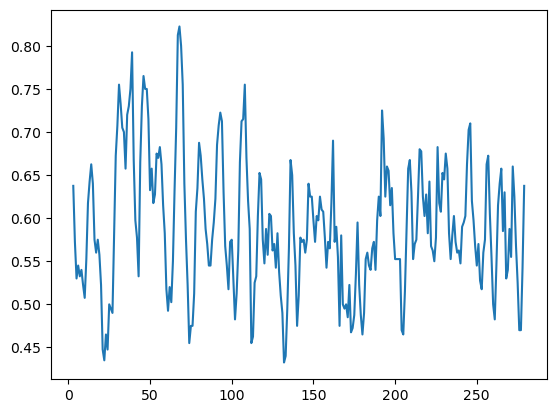

In [21]:
pd.Series(accs).rolling(4).mean().plot()

In [26]:
# Print results for each window
for result in results:
    print(f"Train period: {result['train_period_start']} - {result['train_period_end']}, Test period: {result['test_period_start']} - {result['test_period_end']}")
    print(f"Accuracy on high confidence predictions: {result['accuracy']}\n")

Train period: 2020-01-01 00:00:00 - 2020-01-01 00:00:00, Test period: 2020-01-01 00:00:00 - 2020-01-06 00:00:00


KeyError: 'accuracy'

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd

def train_and_evaluate(merged_df):
    # Handle missing values
    merged_df.fillna(0, inplace=True)
    merged_df.replace([np.inf, -np.inf], 0, inplace=True)

    # Select features and target variable
    features = merged_df.columns[8:].tolist()
    X = merged_df[features].copy()
    y = merged_df['SignificantPriceJump']

    # Data scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

    # Model training
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Model evaluation
    y_pred = model.predict(X_test)
    classification_report_output = classification_report(y_test, y_pred)
    confusion_matrix_output = confusion_matrix(y_test, y_pred)

    # Display results
    print(classification_report_output)
    print(confusion_matrix_output)

    # Predictions and probabilities
    probabilities = model.predict_proba(X_test)
    prob_df = pd.DataFrame(probabilities, columns=['Prob_Negative', 'Prob_Positive'])
    
    return float(classification_report_output.split('\n')[5][-14:-10])

    return classification_report_output, confusion_matrix_output, prob_df

# Usage Example
# merged_df = ... # Your DataFrame
acc = train_and_evaluate(merged_df)


              precision    recall  f1-score   support

       False       0.62      0.66      0.64       363
        True       0.63      0.59      0.61       360

    accuracy                           0.62       723
   macro avg       0.62      0.62      0.62       723
weighted avg       0.62      0.62      0.62       723

[[239 124]
 [149 211]]


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
false = merged_df[merged_df['SignificantPriceJump'] == False].copy()
results = []

for i in range(20):
    for days in [2, 3, 4, 5, 6, 7, 8]:

        df_ = merged_df[merged_df['DaysAfterTrigger'] == days]
        print('Lag days: ', days)
        df_ = pd.concat([df_, false.sample(df_.shape[0])])
        res = train_and_evaluate(df_)
        results.append([days, res])
        print()

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Lag days:  2
              precision    recall  f1-score   support

       False       0.65      0.58      0.61        59
        True       0.62      0.69      0.66        59

    accuracy                           0.64       118
   macro avg       0.64      0.64      0.63       118
weighted avg       0.64      0.64      0.63       118

[[34 25]
 [18 41]]

Lag days:  3
              precision    recall  f1-score   support

       False       0.60      0.49      0.54        55
        True       0.57      0.67      0.62        55

    accuracy                           0.58       110
   macro avg       0.58      0.58      0.58       110
weighted avg       0.58      0.58      0.58       110

[[27 28]
 [18 37]]

Lag days:  4
              precision    recall  f1-score   support

       False       0.59      0.59      0.59        51
        True       0.59      0.59      0.59        51

    accuracy                           0.59       102
   macro avg       0.59      0.59      0.59      

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.60      0.59      0.59        51
        True       0.60      0.61      0.60        51

    accuracy                           0.60       102
   macro avg       0.60      0.60      0.60       102
weighted avg       0.60      0.60      0.60       102

[[30 21]
 [20 31]]

Lag days:  5
              precision    recall  f1-score   support

       False       0.54      0.61      0.57        57
        True       0.54      0.46      0.50        56

    accuracy                           0.54       113
   macro avg       0.54      0.54      0.54       113
weighted avg       0.54      0.54      0.54       113

[[35 22]
 [30 26]]

Lag days:  6
              precision    recall  f1-score   support

       False       0.55      0.51      0.53        43
        True       0.54      0.58      0.56        43

    accuracy                           0.55        86
   macro avg       0.55      0.55      0.55        86
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.59      0.61      0.60        57
        True       0.59      0.57      0.58        56

    accuracy                           0.59       113
   macro avg       0.59      0.59      0.59       113
weighted avg       0.59      0.59      0.59       113

[[35 22]
 [24 32]]

Lag days:  6
              precision    recall  f1-score   support

       False       0.52      0.51      0.52        43
        True       0.52      0.53      0.53        43

    accuracy                           0.52        86
   macro avg       0.52      0.52      0.52        86
weighted avg       0.52      0.52      0.52        86

[[22 21]
 [20 23]]

Lag days:  7
              precision    recall  f1-score   support

       False       0.56      0.53      0.54        47
        True       0.55      0.57      0.56        47

    accuracy                           0.55        94
   macro avg       0.55      0.55      0.55        94
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.55      0.47      0.51        47
        True       0.54      0.62      0.57        47

    accuracy                           0.54        94
   macro avg       0.54      0.54      0.54        94
weighted avg       0.54      0.54      0.54        94

[[22 25]
 [18 29]]

Lag days:  8
              precision    recall  f1-score   support

       False       0.58      0.62      0.60        50
        True       0.60      0.56      0.58        50

    accuracy                           0.59       100
   macro avg       0.59      0.59      0.59       100
weighted avg       0.59      0.59      0.59       100

[[31 19]
 [22 28]]

Lag days:  2
              precision    recall  f1-score   support

       False       0.66      0.66      0.66        59
        True       0.66      0.66      0.66        59

    accuracy                           0.66       118
   macro avg       0.66      0.66      0.66       118
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.60      0.58      0.59        57
        True       0.59      0.61      0.60        56

    accuracy                           0.59       113
   macro avg       0.59      0.59      0.59       113
weighted avg       0.59      0.59      0.59       113

[[33 24]
 [22 34]]

Lag days:  6
              precision    recall  f1-score   support

       False       0.64      0.58      0.61        43
        True       0.62      0.67      0.64        43

    accuracy                           0.63        86
   macro avg       0.63      0.63      0.63        86
weighted avg       0.63      0.63      0.63        86

[[25 18]
 [14 29]]

Lag days:  7
              precision    recall  f1-score   support

       False       0.59      0.55      0.57        47
        True       0.58      0.62      0.60        47

    accuracy                           0.59        94
   macro avg       0.59      0.59      0.58        94
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

              precision    recall  f1-score   support

       False       0.68      0.75      0.71        59
        True       0.72      0.64      0.68        59

    accuracy                           0.69       118
   macro avg       0.70      0.69      0.69       118
weighted avg       0.70      0.69      0.69       118

[[44 15]
 [21 38]]

Lag days:  3
              precision    recall  f1-score   support

       False       0.70      0.60      0.65        55
        True       0.65      0.75      0.69        55

    accuracy                           0.67       110
   macro avg       0.68      0.67      0.67       110
weighted avg       0.68      0.67      0.67       110

[[33 22]
 [14 41]]

Lag days:  4
              precision    recall  f1-score   support

       False       0.59      0.57      0.58        51
        True       0.58      0.61      0.60        51

    accuracy                           0.59       102
   macro avg       0.59      0.59      0.59       102
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

              precision    recall  f1-score   support

       False       0.59      0.67      0.62        51
        True       0.61      0.53      0.57        51

    accuracy                           0.60       102
   macro avg       0.60      0.60      0.60       102
weighted avg       0.60      0.60      0.60       102

[[34 17]
 [24 27]]

Lag days:  5
              precision    recall  f1-score   support

       False       0.53      0.54      0.54        57
        True       0.53      0.52      0.52        56

    accuracy                           0.53       113
   macro avg       0.53      0.53      0.53       113
weighted avg       0.53      0.53      0.53       113

[[31 26]
 [27 29]]

Lag days:  6
              precision    recall  f1-score   support

       False       0.64      0.63      0.64        43
        True       0.64      0.65      0.64        43

    accuracy                           0.64        86
   macro avg       0.64      0.64      0.64        86
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.62      0.47      0.54        55
        True       0.57      0.71      0.63        55

    accuracy                           0.59       110
   macro avg       0.60      0.59      0.59       110
weighted avg       0.60      0.59      0.59       110

[[26 29]
 [16 39]]

Lag days:  4
              precision    recall  f1-score   support

       False       0.58      0.63      0.60        51
        True       0.60      0.55      0.57        51

    accuracy                           0.59       102
   macro avg       0.59      0.59      0.59       102
weighted avg       0.59      0.59      0.59       102

[[32 19]
 [23 28]]

Lag days:  5
              precision    recall  f1-score   support

       False       0.55      0.53      0.54        57
        True       0.53      0.55      0.54        56

    accuracy                           0.54       113
   macro avg       0.54      0.54      0.54       113
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.57      0.49      0.53        43
        True       0.55      0.63      0.59        43

    accuracy                           0.56        86
   macro avg       0.56      0.56      0.56        86
weighted avg       0.56      0.56      0.56        86

[[21 22]
 [16 27]]

Lag days:  7
              precision    recall  f1-score   support

       False       0.56      0.57      0.57        47
        True       0.57      0.55      0.56        47

    accuracy                           0.56        94
   macro avg       0.56      0.56      0.56        94
weighted avg       0.56      0.56      0.56        94

[[27 20]
 [21 26]]

Lag days:  8
              precision    recall  f1-score   support

       False       0.47      0.44      0.45        50
        True       0.47      0.50      0.49        50

    accuracy                           0.47       100
   macro avg       0.47      0.47      0.47       100
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.63      0.65      0.64        51
        True       0.64      0.63      0.63        51

    accuracy                           0.64       102
   macro avg       0.64      0.64      0.64       102
weighted avg       0.64      0.64      0.64       102

[[33 18]
 [19 32]]

Lag days:  5
              precision    recall  f1-score   support

       False       0.61      0.65      0.63        57
        True       0.62      0.57      0.59        56

    accuracy                           0.61       113
   macro avg       0.61      0.61      0.61       113
weighted avg       0.61      0.61      0.61       113

[[37 20]
 [24 32]]

Lag days:  6
              precision    recall  f1-score   support

       False       0.63      0.51      0.56        43
        True       0.59      0.70      0.64        43

    accuracy                           0.60        86
   macro avg       0.61      0.60      0.60        86
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.60      0.57      0.59        47
        True       0.59      0.62      0.60        47

    accuracy                           0.60        94
   macro avg       0.60      0.60      0.60        94
weighted avg       0.60      0.60      0.60        94

[[27 20]
 [18 29]]

Lag days:  8
              precision    recall  f1-score   support

       False       0.55      0.56      0.55        50
        True       0.55      0.54      0.55        50

    accuracy                           0.55       100
   macro avg       0.55      0.55      0.55       100
weighted avg       0.55      0.55      0.55       100

[[28 22]
 [23 27]]

Lag days:  2
              precision    recall  f1-score   support

       False       0.55      0.47      0.51        59
        True       0.54      0.61      0.57        59

    accuracy                           0.54       118
   macro avg       0.54      0.54      0.54       118
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.60      0.58      0.59        55
        True       0.60      0.62      0.61        55

    accuracy                           0.60       110
   macro avg       0.60      0.60      0.60       110
weighted avg       0.60      0.60      0.60       110

[[32 23]
 [21 34]]

Lag days:  4
              precision    recall  f1-score   support

       False       0.51      0.49      0.50        51
        True       0.51      0.53      0.52        51

    accuracy                           0.51       102
   macro avg       0.51      0.51      0.51       102
weighted avg       0.51      0.51      0.51       102

[[25 26]
 [24 27]]

Lag days:  5
              precision    recall  f1-score   support

       False       0.55      0.53      0.54        57
        True       0.53      0.55      0.54        56

    accuracy                           0.54       113
   macro avg       0.54      0.54      0.54       113
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.60      0.63      0.61        43
        True       0.61      0.58      0.60        43

    accuracy                           0.60        86
   macro avg       0.60      0.60      0.60        86
weighted avg       0.60      0.60      0.60        86

[[27 16]
 [18 25]]

Lag days:  7
              precision    recall  f1-score   support

       False       0.65      0.66      0.65        47
        True       0.65      0.64      0.65        47

    accuracy                           0.65        94
   macro avg       0.65      0.65      0.65        94
weighted avg       0.65      0.65      0.65        94

[[31 16]
 [17 30]]

Lag days:  8
              precision    recall  f1-score   support

       False       0.52      0.54      0.53        50
        True       0.52      0.50      0.51        50

    accuracy                           0.52       100
   macro avg       0.52      0.52      0.52       100
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.65      0.59      0.62        51
        True       0.62      0.69      0.65        51

    accuracy                           0.64       102
   macro avg       0.64      0.64      0.64       102
weighted avg       0.64      0.64      0.64       102

[[30 21]
 [16 35]]

Lag days:  5
              precision    recall  f1-score   support

       False       0.62      0.67      0.64        57
        True       0.63      0.59      0.61        56

    accuracy                           0.63       113
   macro avg       0.63      0.63      0.63       113
weighted avg       0.63      0.63      0.63       113

[[38 19]
 [23 33]]

Lag days:  6
              precision    recall  f1-score   support

       False       0.58      0.60      0.59        43
        True       0.59      0.56      0.57        43

    accuracy                           0.58        86
   macro avg       0.58      0.58      0.58        86
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

              precision    recall  f1-score   support

       False       0.62      0.57      0.59        51
        True       0.60      0.65      0.62        51

    accuracy                           0.61       102
   macro avg       0.61      0.61      0.61       102
weighted avg       0.61      0.61      0.61       102

[[29 22]
 [18 33]]

Lag days:  5
              precision    recall  f1-score   support

       False       0.53      0.54      0.53        57
        True       0.52      0.50      0.51        56

    accuracy                           0.52       113
   macro avg       0.52      0.52      0.52       113
weighted avg       0.52      0.52      0.52       113

[[31 26]
 [28 28]]

Lag days:  6
              precision    recall  f1-score   support

       False       0.54      0.51      0.52        43
        True       0.53      0.56      0.55        43

    accuracy                           0.53        86
   macro avg       0.53      0.53      0.53        86
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

              precision    recall  f1-score   support

       False       0.69      0.63      0.65        59
        True       0.66      0.71      0.68        59

    accuracy                           0.67       118
   macro avg       0.67      0.67      0.67       118
weighted avg       0.67      0.67      0.67       118

[[37 22]
 [17 42]]

Lag days:  3
              precision    recall  f1-score   support

       False       0.65      0.55      0.59        55
        True       0.61      0.71      0.66        55

    accuracy                           0.63       110
   macro avg       0.63      0.63      0.62       110
weighted avg       0.63      0.63      0.62       110

[[30 25]
 [16 39]]

Lag days:  4
              precision    recall  f1-score   support

       False       0.52      0.49      0.51        51
        True       0.52      0.55      0.53        51

    accuracy                           0.52       102
   macro avg       0.52      0.52      0.52       102
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.65      0.55      0.59        55
        True       0.61      0.71      0.66        55

    accuracy                           0.63       110
   macro avg       0.63      0.63      0.62       110
weighted avg       0.63      0.63      0.62       110

[[30 25]
 [16 39]]

Lag days:  4
              precision    recall  f1-score   support

       False       0.62      0.69      0.65        51
        True       0.65      0.59      0.62        51

    accuracy                           0.64       102
   macro avg       0.64      0.64      0.64       102
weighted avg       0.64      0.64      0.64       102

[[35 16]
 [21 30]]

Lag days:  5
              precision    recall  f1-score   support

       False       0.47      0.44      0.45        57
        True       0.47      0.50      0.48        56

    accuracy                           0.47       113
   macro avg       0.47      0.47      0.47       113
weighted

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.69      0.68      0.68        59
        True       0.68      0.69      0.69        59

    accuracy                           0.69       118
   macro avg       0.69      0.69      0.69       118
weighted avg       0.69      0.69      0.69       118

[[40 19]
 [18 41]]

Lag days:  3
              precision    recall  f1-score   support

       False       0.60      0.58      0.59        55
        True       0.60      0.62      0.61        55

    accuracy                           0.60       110
   macro avg       0.60      0.60      0.60       110
weighted avg       0.60      0.60      0.60       110

[[32 23]
 [21 34]]

Lag days:  4
              precision    recall  f1-score   support

       False       0.61      0.59      0.60        51
        True       0.60      0.63      0.62        51

    accuracy                           0.61       102
   macro avg       0.61      0.61      0.61       102
weighted

<AxesSubplot:ylabel='period'>

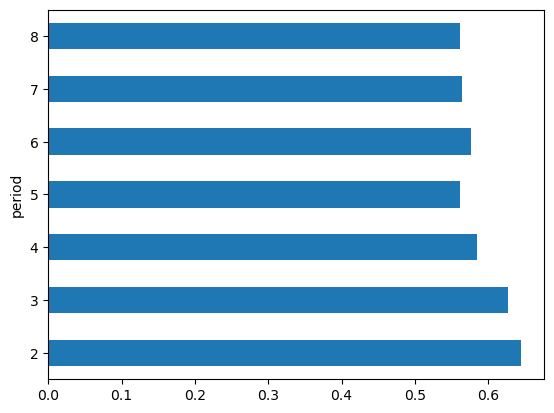

In [36]:
pd.DataFrame(results, columns = ['period', 'acc']).groupby('period')['acc'].mean().plot.barh()

In [37]:
#!pip install lightgbm

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from lightgbm import LGBMClassifier

def train_and_evaluate_lgbm(merged_df):
    # Handle missing values
    merged_df.fillna(0, inplace=True)
    merged_df.replace([np.inf, -np.inf], 0, inplace=True)

    # Select features and target variable
    features = merged_df.columns[8:].tolist()
    X = merged_df[features].copy()
    y = merged_df['SignificantPriceJump']

    # Data scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

    # Model training with LightGBM Classifier
    model = LGBMClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Model evaluation
    y_pred = model.predict(X_test)
    classification_report_output = classification_report(y_test, y_pred)
    confusion_matrix_output = confusion_matrix(y_test, y_pred)

    # Display results
    print(classification_report_output)
    print(confusion_matrix_output)

    # Predictions and probabilities
    probabilities = model.predict_proba(X_test)
    prob_df = pd.DataFrame(probabilities, columns=['Prob_Negative', 'Prob_Positive'])
    
    return float(classification_report_output.split('\n')[5][-14:-10])

    return classification_report_output, confusion_matrix_output, prob_df

# Usage Example
# merged_df = ... # Your DataFrame
classification_report, confusion_matrix, prob_df = train_and_evaluate_lgbm(merged_df)


[LightGBM] [Info] Number of positive: 840, number of negative: 845
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44362
[LightGBM] [Info] Number of data points in the train set: 1685, number of used features: 174
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498516 -> initscore=-0.005935
[LightGBM] [Info] Start training from score -0.005935
              precision    recall  f1-score   support

       False       0.62      0.61      0.62       363
        True       0.61      0.61      0.61       360

    accuracy                           0.61       723
   macro avg       0.61      0.61      0.61       723
weighted avg       0.61      0.61      0.61       723

[[223 140]
 [139 221]]


TypeError: cannot unpack non-iterable float object

0.57

In [40]:
false = merged_df[merged_df['SignificantPriceJump'] == False].copy()
results_gbm = []

for i in range(20):
    for days in [2, 3, 4, 5, 6, 7, 8]:

        df_ = merged_df[merged_df['DaysAfterTrigger'] == days]
        print('Lag days: ', days)
        df_ = pd.concat([df_, false.sample(df_.shape[0])])
        res = train_and_evaluate_lgbm(df_)
        results_gbm.append([days, res])
        print()

Lag days:  2
[LightGBM] [Info] Number of positive: 137, number of negative: 137
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14408
[LightGBM] [Info] Number of data points in the train set: 274, number of used features: 174
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

<AxesSubplot:ylabel='period'>

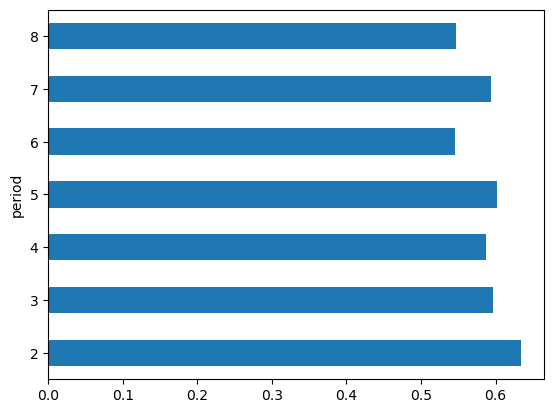

In [41]:
pd.DataFrame(results_gbm, columns = ['period', 'acc']).groupby('period')['acc'].mean().plot.barh()

<AxesSubplot:ylabel='period'>

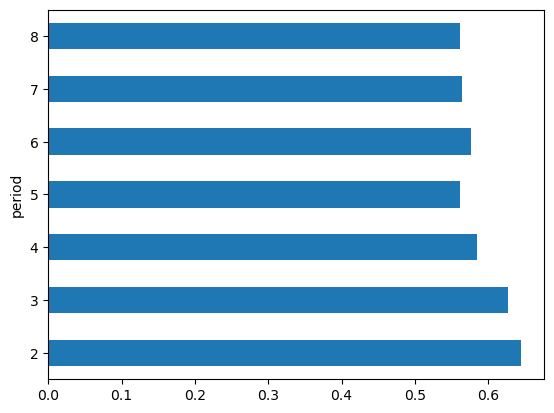

In [42]:
pd.DataFrame(results, columns = ['period', 'acc']).groupby('period')['acc'].mean().plot.barh()

In [132]:
df_

Empty DataFrame
Columns: [TriggerDate, TriggerClose, PriceJumpDate, Close, PriceJumpZScore, DaysAfterTrigger, SignificantPriceJump, Ticker, short_ratio_mean_1, short_ratio_mean_5, short_ratio_mean_10, short_ratio_mean_21, short_ratio_mean_42, short_ratio_mean_1_div_mean_5, short_ratio_mean_5_div_mean_1, short_ratio_mean_1_div_mean_10, short_ratio_mean_10_div_mean_1, short_ratio_mean_1_div_mean_21, short_ratio_mean_21_div_mean_1, short_ratio_mean_1_div_mean_42, short_ratio_mean_42_div_mean_1, short_ratio_mean_5_div_mean_10, short_ratio_mean_10_div_mean_5, short_ratio_mean_5_div_mean_21, short_ratio_mean_21_div_mean_5, short_ratio_mean_5_div_mean_42, short_ratio_mean_42_div_mean_5, short_ratio_mean_10_div_mean_21, short_ratio_mean_21_div_mean_10, short_ratio_mean_10_div_mean_42, short_ratio_mean_42_div_mean_10, short_ratio_mean_21_div_mean_42, short_ratio_mean_42_div_mean_21, short_ratio_mean_1_roc, short_ratio_mean_5_roc, short_ratio_mean_10_roc, short_ratio_mean_21_roc, short_ratio_mean_42_roc, short_ratio_mean_1_div_mean_5_roc, short_ratio_mean_5_div_mean_1_roc, short_ratio_mean_1_div_mean_10_roc, short_ratio_mean_10_div_mean_1_roc, short_ratio_mean_1_div_mean_21_roc, short_ratio_mean_21_div_mean_1_roc, short_ratio_mean_1_div_mean_42_roc, short_ratio_mean_42_div_mean_1_roc, short_ratio_mean_5_div_mean_10_roc, short_ratio_mean_10_div_mean_5_roc, short_ratio_mean_5_div_mean_21_roc, short_ratio_mean_21_div_mean_5_roc, short_ratio_mean_5_div_mean_42_roc, short_ratio_mean_42_div_mean_5_roc, short_ratio_mean_10_div_mean_21_roc, short_ratio_mean_21_div_mean_10_roc, short_ratio_mean_10_div_mean_42_roc, short_ratio_mean_42_div_mean_10_roc, short_ratio_mean_21_div_mean_42_roc, short_ratio_mean_42_div_mean_21_roc, short_exempt_percent_mean_1, short_exempt_percent_mean_5, short_exempt_percent_mean_10, short_exempt_percent_mean_21, short_exempt_percent_mean_42, short_exempt_percent_mean_1_div_mean_5, short_exempt_percent_mean_5_div_mean_1, short_exempt_percent_mean_1_div_mean_10, short_exempt_percent_mean_10_div_mean_1, short_exempt_percent_mean_1_div_mean_21, short_exempt_percent_mean_21_div_mean_1, short_exempt_percent_mean_1_div_mean_42, short_exempt_percent_mean_42_div_mean_1, short_exempt_percent_mean_5_div_mean_10, short_exempt_percent_mean_10_div_mean_5, short_exempt_percent_mean_5_div_mean_21, short_exempt_percent_mean_21_div_mean_5, short_exempt_percent_mean_5_div_mean_42, short_exempt_percent_mean_42_div_mean_5, short_exempt_percent_mean_10_div_mean_21, short_exempt_percent_mean_21_div_mean_10, short_exempt_percent_mean_10_div_mean_42, short_exempt_percent_mean_42_div_mean_10, short_exempt_percent_mean_21_div_mean_42, short_exempt_percent_mean_42_div_mean_21, short_exempt_percent_mean_1_roc, short_exempt_percent_mean_5_roc, short_exempt_percent_mean_10_roc, short_exempt_percent_mean_21_roc, short_exempt_percent_mean_42_roc, short_exempt_percent_mean_1_div_mean_5_roc, short_exempt_percent_mean_5_div_mean_1_roc, short_exempt_percent_mean_1_div_mean_10_roc, short_exempt_percent_mean_10_div_mean_1_roc, short_exempt_percent_mean_1_div_mean_21_roc, short_exempt_percent_mean_21_div_mean_1_roc, short_exempt_percent_mean_1_div_mean_42_roc, short_exempt_percent_mean_42_div_mean_1_roc, short_exempt_percent_mean_5_div_mean_10_roc, short_exempt_percent_mean_10_div_mean_5_roc, short_exempt_percent_mean_5_div_mean_21_roc, short_exempt_percent_mean_21_div_mean_5_roc, ...]
Index: []

[0 rows x 178 columns]

In [130]:
false.sample(4)

TriggerDate  TriggerClose PriceJumpDate  Close  PriceJumpZScore  \
2952  2019-06-17    105.201796             0    0.0              0.0   
2560  2020-10-01    122.778283             0    0.0              0.0   
3453  2020-05-12    139.828484             0    0.0              0.0   
850   2020-06-08     24.139427             0    0.0              0.0   

      DaysAfterTrigger  SignificantPriceJump Ticker  short_ratio_mean_1  \
2952               0.0                 False    TXN            0.565732   
2560               0.0                 False    FIS            0.800535   
3453               0.0                 False    DHR            0.650610   
850                0.0                 False    GLW            0.409967   

      short_ratio_mean_5  ...  gamma_Time_Spread_rolling_1  \
2952            0.709533  ...                     0.999723   
2560            0.716849  ...                     0.411696   
3453            0.501056  ...                     0.270159   
850             0.376533  ...                     0.296431   

      gamma_Time_Spread_rolling_5  gamma_Time_Spread_rolling_10  \
2952                     0.986916                      0.959672   
2560                     0.549573                      0.739984   
3453                     0.339773                      0.426694   
850                      0.545335                      0.515216   

      gamma_Time_Spread_rolling_21  gamma_Time_Spread_rolling_42  \
2952                      0.905909                      0.892003   
2560                      0.814202                      0.717582   
3453                      0.461351                      0.500603   
850                       0.636980                      0.657751   

      gamma_30_z_score  gamma_Skew_z_score  gamma_Time_Spread_z_score  \
2952         -1.021639            0.840944                   0.891127   
2560          0.080717            0.474371                  -0.246056   
3453          0.075622            0.446046                  -0.513665   
850          -0.186298           -0.936628                  -0.242352   

      IV_HV_Difference  vwap_close_pct  
2952          0.035765        0.971348  
2560          0.063672        1.034233  
3453         -0.002715        1.073022  
850          -0.032355        1.195963  

[4 rows x 178 columns]

In [126]:
train_and_evaluate(merged_df[merged_df['DaysAfterTrigger'] == 2])

/tmp/ipykernel_4976/1927117639.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.fillna(0, inplace=True)
/tmp/ipykernel_4976/1927117639.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.replace([np.inf, -np.inf], 0, inplace=True)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: True

In [124]:
merged_df

TriggerDate  TriggerClose PriceJumpDate      Close  PriceJumpZScore  \
0     2019-03-11     52.226633    2019-03-21  52.756691         2.987785   
1     2019-03-12     51.400575    2019-03-21  52.756691         2.987785   
2     2019-03-13     50.732777    2019-03-21  52.756691         2.987785   
3     2019-03-15     49.820675    2019-03-21  52.756691         2.987785   
4     2019-03-18     49.751754    2019-03-21  52.756691         2.987785   
...          ...           ...           ...        ...              ...   
6069  2019-03-08     48.012203             0   0.000000         0.000000   
6070  2023-08-16     47.434397             0   0.000000         0.000000   
6071  2019-06-19     49.776811             0   0.000000         0.000000   
6072  2019-02-11     47.079677             0   0.000000         0.000000   
6073  2022-06-01     56.629056             0   0.000000         0.000000   

      DaysAfterTrigger  SignificantPriceJump Ticker  short_ratio_mean_1  \
0                  8.0                  True    WDC            0.455417   
1                  7.0                  True    WDC            0.525774   
2                  6.0                  True    WDC            0.446586   
3                  4.0                  True    WDC            0.464885   
4                  3.0                  True    WDC            0.469127   
...                ...                   ...    ...                 ...   
6069               0.0                 False    NEE            0.632799   
6070               0.0                 False    NEE            0.580631   
6071               0.0                 False    NEE            0.500347   
6072               0.0                 False    NEE            0.622944   
6073               0.0                 False    NEE            0.612841   

      short_ratio_mean_5  ...  gamma_Time_Spread_rolling_1  \
0               0.483421  ...                     0.482897   
1               0.486444  ...                     0.712365   
2               0.467740  ...                     0.769523   
3               0.450175  ...                     0.464030   
4               0.452917  ...                     0.557502   
...                  ...  ...                          ...   
6069            0.589095  ...                     0.365565   
6070            0.562677  ...                     0.977674   
6071            0.484958  ...                     0.832385   
6072            0.478840  ...                     1.000000   
6073            0.552248  ...                     0.217258   

      gamma_Time_Spread_rolling_5  gamma_Time_Spread_rolling_10  \
0                        0.017609                      0.330419   
1                       -0.073976                      0.266560   
2                        0.026879                      0.290122   
3                        0.525051                      0.271330   
4                        0.629489                      0.263258   
...                           ...                           ...   
6069                     0.359239                      0.354477   
6070                     0.985784                      0.847894   
6071                     0.807328                      0.796801   
6072                     0.882248                      0.640062   
6073                    -0.036280                      0.206339   

      gamma_Time_Spread_rolling_21  gamma_Time_Spread_rolling_42  \
0                         0.446315                      0.662673   
1                         0.447807                      0.620506   
2                         0.453415                      0.612013   
3                         0.428324                      0.608803   
4                         0.415457                      0.601810   
...                            ...                           ...   
6069                      0.609318                      0.585392   
6070                      0.741979                      0.986332   
6071                      0.8

In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Assuming your DataFrame is named 'merged_df'
# Handle missing values (if any)
merged_df.fillna(0, inplace=True)
merged_df.replace([np.inf, -np.inf], 0, inplace=True)

# Feature selection: Choose columns that are relevant as features
# Exclude columns like 'PriceJumpDate' which are not available at prediction time
features = merged_df.columns[8:].tolist()

# Extract the features and labels
X = merged_df[features]
y = merged_df['SignificantPriceJump']

# Data Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# First, extract the indices of the rows
indices = merged_df.index

# Split the indices
X_train_idx, X_test_idx, y_train, y_test = train_test_split(
    indices, y, test_size=0.3, random_state=42, stratify=y
)

# Using the indices to create the actual training and test sets
X_train = merged_df.loc[X_train_idx, features]
X_test = merged_df.loc[X_test_idx, features]

# Scaling the split data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Model Evaluation
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Predictions can be made using model.predict() on new data
probabilities = model.predict_proba(X_test_scaled)# [:, 1]

# Create a DataFrame from the probabilities and the original index
prob_df = pd.DataFrame(probabilities, index=X_test_idx, columns=['Prob_Negative', 'Prob_Positive'])
print(prob_df.head()) # Display the first few entries of probability DataFrame



              precision    recall  f1-score   support

       False       0.58      0.63      0.60      1041
        True       0.59      0.55      0.57      1035

    accuracy                           0.59      2076
   macro avg       0.59      0.59      0.59      2076
weighted avg       0.59      0.59      0.59      2076

[[653 388]
 [465 570]]
      Prob_Negative  Prob_Positive
3064       0.560609       0.439391
6876       0.500251       0.499749
4031       0.273586       0.726414
4849       0.362094       0.637906
6571       0.613354       0.386646


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [112]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

def fetch_and_preprocess_data(ticker, sdate, edate, beta_adjust):
    # Example function to mimic data fetching and preprocessing
    df_data = get_data(ticker, sdate, edate, beta_adjust)
    # Add any preprocessing steps here
    return df_data


def feature_engineering(df_data, ticker, lag_period, analysis, greek_analysis, price_iv_analysis):
    # Example feature engineering steps
    price_jumps_df = identify_price_jumps(
        df_data, z_score_threshold=2.5, stability_threshold=1, 
        include_negative_class=True, remove_duplicate_price_jump_dates=False, 
        lag_days_start=lag_period, lag_days_end=lag_period
    )
    
    # Set as index
    price_jumps_df.set_index('TriggerDate', inplace = True)
    price_jumps_df.index = pd.to_datetime(price_jumps_df.index)

    df_short_ratio = analysis.calculate_short_ratio_means(ticker, include_diff=True, include_roc=True)
    df_short_sale_exempt = analysis.calculate_short_exempt_means(ticker, include_diff=True, include_roc=True)
    df_investment_values = analysis.calculate_investment_values(ticker, include_diff=True, include_roc=True)
    df_iv = greek_analysis.get_analysis_for_ticker(ticker, 'iv', include_rolling=True, include_z_score=True)
    df_gamma = greek_analysis.get_analysis_for_ticker(ticker, 'gamma', include_rolling=True, include_z_score=True)
    df_iv_hv = price_iv_analysis.compare_iv_hv(ticker)
    df_vwap = price_iv_analysis.compare_price_to_vwap(ticker)

    return price_jumps_df, [df_short_ratio, df_short_sale_exempt, df_investment_values, df_iv, df_gamma, df_iv_hv, df_vwap]


def merge_data(price_jumps_df, additional_dfs):
    # Merge the dataframes together
    for df_ in additional_dfs:
        df_.index = pd.to_datetime(df_.index)
        price_jumps_df = price_jumps_df.merge(df_, left_index=True, right_index=True, how='left')
    return price_jumps_df


def train_and_evaluate_model(merged_df):
    features = merged_df.columns[8:].tolist()
    X = merged_df[features].copy()
    y = merged_df['SignificantPriceJump']

    # Replace inf/-inf with NaN
    X.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Cap extreme values if needed (optional, customize as per your data's needs)
    X = np.clip(X, a_min=-1e9, a_max=1e9)  # Example capping

    # Impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # Use RobustScaler to handle outliers better
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probabilities = model.predict_proba(X_test)

    evaluation_metrics = {
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    prob_df = pd.DataFrame(probabilities, columns=['Prob_Negative', 'Prob_Positive'])

    return model, prob_df, evaluation_metrics


def main_pipeline(tickers, sdate, edate, beta_adjust, lag_periods, analysis, greek_analysis, price_iv_analysis):
    
    # Pre-fetch and preprocess data for all tickers
    pre_fetched_data = pre_fetch_data(tickers, sdate, edate, beta_adjust)

    for lag_period in lag_periods:
        df_repo = []
        for ticker in tqdm(tickers):
            try:
                df_data = pre_fetched_data.get(ticker)
                if df_data is not None:
                    # df_data = fetch_and_preprocess_data(ticker, sdate, edate, beta_adjust)
                    price_jumps_df, additional_dfs = feature_engineering(df_data, ticker, lag_period, analysis, greek_analysis, price_iv_analysis)
                    merged_df = merge_data(price_jumps_df, additional_dfs)
                    df_repo.append(merged_df)
                else:
                    print(f"No data available for {ticker}")
            except Exception as e:
                print(ticker, type(e), e)

        combined_df = pd.concat(df_repo).reset_index(drop=True)
        model, prob_df, eval_metrics = train_and_evaluate_model(combined_df)
        print(f"Lag Period: {lag_period}")
        print(f"Evaluation Metrics: {eval_metrics['classification_report']}", end = '\n\n')


In [113]:
def pre_fetch_data(tickers, sdate, edate, beta_adjust):
    data_repo = {}
    for ticker in tqdm(tickers):
        try:
            data_repo[ticker] = fetch_and_preprocess_data(ticker, sdate, edate, beta_adjust)
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
    return data_repo


In [114]:
# Initialize your analysis classes
# analysis = ShortSaleVolume()
greek_analysis = GreekAnalysis()
price_iv_analysis = VolatilityAnalysis()

# Define your tickers and other parameters
# tickers = ['AAPL', 'TSLA', 'MMM', 'NVDA', 'AMZN']
sdate = '20180816'
edate = '20231115'
beta_adjust = True
lag_periods = [2, 3, 4, 5, 6, 7, 8]

# Run the pipeline
main_pipeline(tickers, sdate, edate, beta_adjust, lag_periods, analysis, greek_analysis, price_iv_analysis)


  2%|▏         | 1/51 [00:02<01:56,  2.34s/it]

J <class 'ValueError'> NaTType does not support timestamp


 25%|██▌       | 13/51 [01:07<02:49,  4.47s/it]

BKR <class 'ValueError'> NaTType does not support timestamp


 61%|██████    | 31/51 [02:45<01:32,  4.64s/it]

EG <class 'ValueError'> NaTType does not support timestamp


 88%|████████▊ | 45/51 [04:04<00:28,  4.75s/it]

BBWI <class 'ValueError'> NaTType does not support timestamp


100%|██████████| 51/51 [04:40<00:00,  5.49s/it]
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Lag Period: 2
Evaluation Metrics:               precision    recall  f1-score   support

       False       0.57      0.49      0.53       148
        True       0.48      0.56      0.52       125

    accuracy                           0.52       273
   macro avg       0.53      0.53      0.52       273
weighted avg       0.53      0.52      0.52       273




  2%|▏         | 1/51 [00:01<01:37,  1.94s/it]

J <class 'ValueError'> NaTType does not support timestamp


 25%|██▌       | 13/51 [01:05<02:49,  4.47s/it]

BKR <class 'ValueError'> NaTType does not support timestamp


 61%|██████    | 31/51 [02:43<01:32,  4.60s/it]

EG <class 'ValueError'> NaTType does not support timestamp


 88%|████████▊ | 45/51 [04:02<00:29,  4.86s/it]

BBWI <class 'ValueError'> NaTType does not support timestamp


100%|██████████| 51/51 [04:36<00:00,  5.43s/it]


Lag Period: 3
Evaluation Metrics:               precision    recall  f1-score   support

       False       0.48      0.55      0.51       133
        True       0.50      0.44      0.47       140

    accuracy                           0.49       273
   macro avg       0.49      0.49      0.49       273
weighted avg       0.49      0.49      0.49       273




  2%|▏         | 1/51 [00:02<01:52,  2.25s/it]

J <class 'ValueError'> NaTType does not support timestamp


 25%|██▌       | 13/51 [01:06<02:50,  4.49s/it]

BKR <class 'ValueError'> NaTType does not support timestamp


 41%|████      | 21/51 [01:52<02:40,  5.36s/it]


KeyboardInterrupt: 